In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.optimize import curve_fit
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
import seaborn as sns
import pymc as pm
import pytensor.tensor as pt
import warnings
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
warnings.filterwarnings('ignore')

In [2]:
# =============================================================================
# LANGUAGE PAIR DEFINITIONS
# =============================================================================

LANGUAGE_PAIRS = {
    'en_es': {'ui': 'en', 'learning': 'es', 'label': 'EN → ES'},
    'en_fr': {'ui': 'en', 'learning': 'fr', 'label': 'EN → FR'},
    'en_de': {'ui': 'en', 'learning': 'de', 'label': 'EN → DE'},
    'en_it': {'ui': 'en', 'learning': 'it', 'label': 'EN → IT'},
    'en_pt': {'ui': 'en', 'learning': 'pt', 'label': 'EN → PT'},
    'es_en': {'ui': 'es', 'learning': 'en', 'label': 'ES → EN'},
    'it_en': {'ui': 'it', 'learning': 'en', 'label': 'IT → EN'},
    'pt_en': {'ui': 'pt', 'learning': 'en', 'label': 'PT → EN'},
}

In [3]:
# =============================================================================
# STEP 0 — DATA LOADING & FILTERING
# =============================================================================

def load_and_filter(filepath, delta_min=100, delta_max=14*24*3600, min_reviews=50):
    """
    Load the Duolingo HLR dataset and apply delta filtering.

    Parameters
    ----------
    filepath     : path to settles.acl16.learning_traces.13m.csv
    delta_min    : minimum seconds since last review (default: 100s)
    delta_max    : maximum seconds since last review (default: 2 weeks)
    min_reviews  : minimum reviews per user to be included (default: 50)

    Returns
    -------
    df_filtered  : filtered DataFrame
    """
    print("Loading dataset...")
    df = pd.read_csv(filepath)
    df = df[df['delta'] > 0].copy()

    df_filtered = df[(df['delta'] >= delta_min) & (df['delta'] <= delta_max)].copy()

    user_counts = df_filtered.groupby('user_id').size()
    eligible = user_counts[user_counts >= min_reviews].index
    df_filtered = df_filtered[df_filtered['user_id'].isin(eligible)]

    print(f"Original rows:  {len(df):,}")
    print(f"Filtered rows:  {len(df_filtered):,} ({100*len(df_filtered)/len(df):.1f}%)")
    print(f"Eligible users: {len(eligible):,}")

    if 'ui_language' in df_filtered.columns and 'learning_language' in df_filtered.columns:
        pair_counts = df_filtered.groupby(['ui_language', 'learning_language'])['user_id'].nunique()
        print("\nUsers per language pair:")
        print(pair_counts.to_string())

    return df_filtered

In [4]:
def filter_by_language_pair(df, ui_language, learning_language):
    """
    Filter dataset to a specific language pair.

    Parameters
    ----------
    df               : full filtered DataFrame from load_and_filter()
    ui_language      : interface language code (e.g. 'en')
    learning_language: target language code (e.g. 'es')

    Returns
    -------
    Filtered DataFrame for the given language pair
    """
    mask = (df['ui_language'] == ui_language) & (df['learning_language'] == learning_language)
    subset = df[mask].copy()
    print(f"Language pair {ui_language} → {learning_language}: "
          f"{len(subset):,} rows, {subset['user_id'].nunique():,} users")
    return subset

In [5]:
# =============================================================================
# STEP 1 — DESCRIPTIVE FORGETTING CURVES
# =============================================================================

def plot_forgetting_curves(df, n_users=50, min_reviews=200, title_suffix='', ax=None):
    """
    Plot individual learner forgetting curves vs. population average.

    Parameters
    ----------
    df           : filtered DataFrame
    n_users      : number of individual users to overlay
    min_reviews  : minimum reviews for a user to be eligible for overlay
    title_suffix : string appended to plot title (e.g. language pair label)
    ax           : optional matplotlib axis; creates new figure if None
    """
    df = df.copy()
    df['log_delta'] = np.log10(df['delta'])
    df['delta_bin'] = pd.cut(df['log_delta'], bins=20)

    pop_curve = df.groupby('delta_bin', observed=True)['p_recall'].mean().reset_index()
    pop_curve['bin_mid'] = pop_curve['delta_bin'].apply(lambda x: x.mid)

    user_counts = df.groupby('user_id').size()
    eligible = user_counts[user_counts >= min_reviews].index
    if len(eligible) == 0:
        print("Not enough users with sufficient reviews for overlay.")
        return
    sampled = np.random.choice(eligible, size=min(n_users, len(eligible)), replace=False)

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))

    for user in sampled:
        udf = df[df['user_id'] == user]
        curve = udf.groupby('delta_bin', observed=True)['p_recall'].mean().reset_index()
        curve['bin_mid'] = curve['delta_bin'].apply(lambda x: x.mid)
        ax.plot(curve['bin_mid'], curve['p_recall'], color='steelblue', alpha=0.15, linewidth=1)

    ax.plot(pop_curve['bin_mid'], pop_curve['p_recall'],
            color='red', linewidth=2.5, label='Population average')
    ax.set_xlabel('log10(seconds since last review)')
    ax.set_ylabel('Average p_recall')
    ax.set_title(f'Forgetting Curves: Individual vs. Population {title_suffix}')
    ax.legend()

    return ax

In [6]:
# =============================================================================
# STEP 2 — NAIVE PER-LEARNER HALF-LIFE FITTING
# =============================================================================

def _forgetting_curve(t, h):
    return np.exp(-t / h)


def fit_naive_halflife(df, initial_guess=86400):
    """
    Fit exponential forgetting curve p = exp(-t/h) independently per learner.

    Parameters
    ----------
    df           : filtered DataFrame
    initial_guess: initial half-life guess in seconds (default: 1 day)

    Returns
    -------
    results_df   : DataFrame with columns [user_id, half_life, half_life_days,
                   n_reviews, mean_p_recall]
    """
    print("Fitting per-learner half-life...")
    results = []

    for user_id, udf in df.groupby('user_id'):
        t = udf['delta'].values
        p = udf['p_recall'].values
        try:
            popt, _ = curve_fit(_forgetting_curve, t, p,
                                p0=[initial_guess], bounds=(1, np.inf))
            results.append({
                'user_id': user_id,
                'half_life': popt[0],
                'half_life_days': popt[0] / 86400,
                'n_reviews': len(udf),
                'mean_p_recall': p.mean()
            })
        except RuntimeError:
            pass

    results_df = pd.DataFrame(results)
    print(f"Successfully fit: {len(results_df):,} users")
    print(f"\nHalf-life summary (days):")
    print(results_df['half_life_days'].describe().round(1))
    return results_df

In [7]:
def plot_halflife_distribution(results_df, title_suffix='', ax=None):
    """
    Plot distribution of per-learner half-lives and half-life vs. mean recall.

    Parameters
    ----------
    results_df   : output of fit_naive_halflife()
    title_suffix : string appended to plot titles
    ax           : optional list of 2 axes; creates new figure if None
    """
    if ax is None:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    else:
        axes = ax

    # Left: distribution
    axes[0].hist(np.log10(results_df['half_life_days']), bins=80,
                 color='steelblue', edgecolor='white')
    axes[0].set_xlabel('log10(half-life in days)')
    axes[0].set_ylabel('Number of users')
    axes[0].set_title(f'Half-Life Distribution {title_suffix}')
    for val, label in [(1, '10d'), (1.7, '50d'), (2, '100d')]:
        axes[0].axvline(val, color='red', linestyle='--', alpha=0.5)
        axes[0].text(val+0.03, axes[0].get_ylim()[1]*0.85, label, color='red', fontsize=8)

    # Right: half-life vs recall
    axes[1].scatter(np.log10(results_df['half_life_days']),
                    results_df['mean_p_recall'], alpha=0.05, s=5, color='steelblue')
    r, pval = spearmanr(np.log10(results_df['half_life_days']), results_df['mean_p_recall'])
    axes[1].set_xlabel('log10(half-life in days)')
    axes[1].set_ylabel('Mean p_recall')
    axes[1].set_title(f'Half-Life vs. Recall {title_suffix}')
    axes[1].text(0.05, 0.95, f'r = {r:.3f}, p = {pval:.2e}',
                 transform=axes[1].transAxes, fontsize=10, verticalalignment='top')

    plt.tight_layout()
    return axes

In [8]:
# =============================================================================
# STEP 3 — BAYESIAN HIERARCHICAL MODEL (PyMC)
# =============================================================================

def sample_users_stratified(results_df, df_filtered, n_per_quintile=100, random_state=42):
    """
    Stratified sample of users across half-life quintiles.

    Parameters
    ----------
    results_df    : output of fit_naive_halflife()
    df_filtered   : filtered DataFrame from load_and_filter()
    n_per_quintile: users to sample per quintile (default: 100)
    random_state  : random seed

    Returns
    -------
    df_model      : filtered DataFrame for sampled users
    user_codes    : array of user_id values (index → user_id mapping)
    user_idx      : integer index array aligned with df_model rows
    """
    results_df = results_df.copy()
    results_df['hl_quintile'] = pd.qcut(results_df['half_life_days'], q=5, labels=False)

    sampled_users = (
        results_df.groupby('hl_quintile')
        .apply(lambda x: x.sample(min(n_per_quintile, len(x)), random_state=random_state))
        .reset_index(drop=True)
    )['user_id'].values

    df_model = df_filtered[df_filtered['user_id'].isin(sampled_users)].copy()
    df_model['delta_days'] = df_model['delta'] / 86400
    user_idx, user_codes = pd.factorize(df_model['user_id'])
    df_model['user_idx'] = user_idx

    print(f"Sampled {len(sampled_users)} users, {len(df_model):,} rows")
    return df_model, user_codes, user_idx

In [9]:
def fit_hierarchical_model(df_model, user_codes, user_idx,
                            draws=1000, tune=1000, chains=4,
                            target_accept=0.9, random_seed=42):
    """
    Fit Bayesian hierarchical forgetting model with PyMC.

    Model: p_recall ~ Normal(exp(-delta / exp(mu + sigma * z_i)), sigma_obs)
    where z_i ~ Normal(0,1) per learner (non-centered parameterization)

    Parameters
    ----------
    df_model     : output of sample_users_stratified()
    user_codes   : user_id mapping array
    user_idx     : integer index array
    draws        : MCMC draws per chain
    tune         : tuning steps per chain
    chains       : number of chains
    target_accept: NUTS target acceptance rate
    random_seed  : random seed

    Returns
    -------
    trace        : ArviZ InferenceData object
    """
    n_users = len(user_codes)
    t = df_model['delta_days'].values
    p = df_model['p_recall'].values

    with pm.Model() as forgetting_model:
        mu_log_h    = pm.Normal('mu_log_h', mu=3.7, sigma=1.0)
        sigma_log_h = pm.HalfNormal('sigma_log_h', sigma=1.0)
        z           = pm.Normal('z', mu=0, sigma=1, shape=n_users)
        log_h_i     = pm.Deterministic('log_h_i', mu_log_h + sigma_log_h * z)
        h_i         = pm.Deterministic('h_i', pt.exp(log_h_i))
        p_pred      = pt.exp(-t / h_i[user_idx])
        sigma_obs   = pm.HalfNormal('sigma_obs', sigma=0.1)
        _           = pm.Normal('likelihood', mu=p_pred, sigma=sigma_obs, observed=p)

        trace = pm.sample(draws, tune=tune, chains=chains,
                          target_accept=target_accept,
                          random_seed=random_seed, progressbar=True)

    print(pm.summary(trace, var_names=['mu_log_h', 'sigma_log_h', 'sigma_obs']))
    return trace

In [10]:
# =============================================================================
# STEP 4 — SHRINKAGE & POSTERIOR VISUALIZATION
# =============================================================================

def build_hierarchical_df(trace, df_model, user_codes, results_naive):
    """
    Build a per-learner DataFrame combining hierarchical posteriors and naive estimates.

    Parameters
    ----------
    trace        : output of fit_hierarchical_model()
    df_model     : output of sample_users_stratified()
    user_codes   : user_id mapping array
    results_naive: output of fit_naive_halflife()

    Returns
    -------
    hierarchical_df : DataFrame with posterior means, HDIs, naive estimates
    """
    log_h_samples  = trace.posterior['log_h_i'].values.reshape(-1, len(user_codes))
    h_samples_days = np.exp(log_h_samples)

    h_posterior_mean = h_samples_days.mean(axis=0)
    h_hdi_low  = np.percentile(h_samples_days, 3, axis=0)
    h_hdi_high = np.percentile(h_samples_days, 97, axis=0)

    naive_lookup = results_naive.set_index('user_id')['half_life_days']

    hierarchical_df = pd.DataFrame({
        'user_id':        user_codes,
        'h_hierarchical': h_posterior_mean,
        'h_hdi_low':      h_hdi_low,
        'h_hdi_high':     h_hdi_high,
        'n_reviews':      df_model.groupby('user_idx').size().values
    })
    hierarchical_df['h_naive'] = hierarchical_df['user_id'].map(naive_lookup)
    hierarchical_df['log_h']   = np.log10(hierarchical_df['h_hierarchical'])

    return hierarchical_df

In [11]:
def plot_hierarchical_results(trace, hierarchical_df, title_suffix=''):
    """
    Plot posterior of population parameters, shrinkage, and uncertainty vs. data quantity.

    Parameters
    ----------
    trace           : output of fit_hierarchical_model()
    hierarchical_df : output of build_hierarchical_df()
    title_suffix    : string appended to plot titles
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Left: population mean half-life posterior
    mu_samples = trace.posterior['mu_log_h'].values.flatten()
    axes[0].hist(np.exp(mu_samples), bins=60, color='steelblue', edgecolor='white', alpha=0.8)
    axes[0].axvline(np.exp(mu_samples.mean()), color='red', linewidth=2,
                    label=f'Mean: {np.exp(mu_samples.mean()):.1f} days')
    axes[0].set_xlabel('Half-life (days)')
    axes[0].set_title(f'Population Mean Half-Life {title_suffix}')
    axes[0].legend()

    # Middle: shrinkage plot
    axes[1].scatter(np.log10(hierarchical_df['h_naive']),
                    np.log10(hierarchical_df['h_hierarchical']),
                    alpha=0.3, s=8, color='steelblue')
    lims = [min(np.log10(hierarchical_df[['h_naive', 'h_hierarchical']]).min()),
            max(np.log10(hierarchical_df[['h_naive', 'h_hierarchical']]).max())]
    axes[1].plot(lims, lims, 'r--', linewidth=1.5, label='No shrinkage')
    axes[1].set_xlabel('log10(naive half-life) — Step 2')
    axes[1].set_ylabel('log10(hierarchical half-life) — Step 3')
    axes[1].set_title(f'Shrinkage Effect {title_suffix}')
    axes[1].legend()

    shrinkage_ratio = (np.log10(hierarchical_df['h_hierarchical']).std() /
                       np.log10(hierarchical_df['h_naive']).std())
    print(f"Shrinkage ratio: {shrinkage_ratio:.3f}")

    # Right: uncertainty vs. data quantity
    hierarchical_df['hdi_width'] = (np.log10(hierarchical_df['h_hdi_high']) -
                                    np.log10(hierarchical_df['h_hdi_low']))
    axes[2].scatter(np.log10(hierarchical_df['n_reviews']),
                    hierarchical_df['hdi_width'],
                    alpha=0.3, s=8, color='steelblue')
    axes[2].set_xlabel('log10(number of reviews)')
    axes[2].set_ylabel('HDI width (log10 days)')
    axes[2].set_title(f'Uncertainty vs. Data Quantity {title_suffix}')

    plt.suptitle(f'Hierarchical Model Results {title_suffix}', fontsize=13, y=1.02)
    plt.tight_layout()
    plt.show()

In [12]:
# =============================================================================
# STEP 5 — FEATURE ENGINEERING & REGRESSION
# =============================================================================

def engineer_features(df_filtered, hierarchical_df):
    """
    Engineer per-learner behavioral and performance features and merge with half-life.

    Parameters
    ----------
    df_filtered     : filtered DataFrame (for the sampled users)
    hierarchical_df : output of build_hierarchical_df()

    Returns
    -------
    features_df : DataFrame with engineered features and log_h target
    """
    sampled_users = hierarchical_df['user_id'].values
    features = []

    for user_id, udf in df_filtered[df_filtered['user_id'].isin(sampled_users)].groupby('user_id'):
        features.append({
            'user_id':          user_id,
            'n_reviews':        len(udf),
            'n_lexemes':        udf['lexeme_id'].nunique(),
            'mean_accuracy':    (udf['history_correct'] / udf['history_seen'].clip(lower=1)).mean(),
            'mean_delta_days':  udf['delta'].mean() / 86400,
            'median_delta_days':udf['delta'].median() / 86400,
            'cv_delta':         udf['delta'].std() / udf['delta'].mean()
                                if udf['delta'].mean() > 0 else np.nan,
            'mean_history_seen':udf['history_seen'].mean(),
        })

    features_df = pd.DataFrame(features)
    features_df = features_df.merge(hierarchical_df[['user_id', 'h_hierarchical']], on='user_id')
    features_df['log_h'] = np.log10(features_df['h_hierarchical'])

    # Log-transform skewed features
    features_df['log_n_reviews']    = np.log10(features_df['n_reviews'])
    features_df['log_n_lexemes']    = np.log10(features_df['n_lexemes'])
    features_df['log_mean_delta']   = np.log10(features_df['mean_delta_days'].clip(lower=0.01))
    features_df['log_cv_delta']     = np.log10(features_df['cv_delta'].clip(lower=0.01))
    features_df['log_history_seen'] = np.log10(features_df['mean_history_seen'])

    return features_df

In [13]:
def run_regression_analysis(features_df, title_suffix=''):
    """
    Run three OLS regression models (behavioral, performance, full) and plot partial regressions.

    Parameters
    ----------
    features_df  : output of engineer_features()
    title_suffix : string appended to plot titles

    Returns
    -------
    results_dict : dict with keys 'behavioral', 'performance', 'full' → statsmodels results
    corr_df      : Spearman correlation table
    """
    feature_sets = {
        'Behavioral':  ['log_n_reviews', 'log_n_lexemes', 'log_cv_delta', 'log_history_seen'],
        'Performance': ['mean_accuracy', 'log_mean_delta'],
        'Full':        ['log_n_reviews', 'log_n_lexemes', 'log_cv_delta',
                        'log_history_seen', 'mean_accuracy', 'log_mean_delta']
    }
    feature_labels = {
        'log_n_reviews':    'Practice Volume (log)',
        'log_n_lexemes':    'Vocabulary Breadth (log)',
        'log_cv_delta':     'Spacing Irregularity (log CV)',
        'log_history_seen': 'Avg Repetitions/Word (log)',
        'mean_accuracy':    'Mean Accuracy',
        'log_mean_delta':   'Avg Review Gap (log days)'
    }

    y = features_df['log_h'].values
    results_dict = {}

    print("=" * 65)
    for model_name, feats in feature_sets.items():
        X = np.nan_to_num(features_df[feats].values)
        X_scaled = StandardScaler().fit_transform(X)
        X_sm = sm.add_constant(X_scaled)
        model = sm.OLS(y, X_sm).fit()
        cv_r2 = cross_val_score(LinearRegression(), X_scaled, y, cv=5, scoring='r2').mean()
        results_dict[model_name] = model

        print(f"\n--- {model_name} Model {title_suffix} ---")
        print(f"R²: {model.rsquared:.3f}  Adj R²: {model.rsquared_adj:.3f}  CV R²: {cv_r2:.3f}")
        print(f"{'Feature':<35} {'Coef':>7} {'p':>7}")
        print("-" * 55)
        for name, coef, p in zip(['intercept']+feats, model.params, model.pvalues):
            sig = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else ''
            print(f"{name:<35} {coef:>7.3f} {p:>7.3f} {sig}")
    print("=" * 65)

    # Spearman correlations
    full_feats = feature_sets['Full']
    corr_results = []
    for feat in full_feats:
        r, p = spearmanr(features_df[feat], features_df['log_h'])
        corr_results.append({'feature': feature_labels[feat], 'r': r, 'p': p})
    corr_df = pd.DataFrame(corr_results).sort_values('r', key=abs, ascending=False)

    # Partial regression plots
    X_full_scaled = StandardScaler().fit_transform(
        np.nan_to_num(features_df[full_feats].values))
    X_full_df = pd.DataFrame(X_full_scaled, columns=full_feats)

    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    axes = axes.flatten()

    for i, feat in enumerate(full_feats):
        ax = axes[i]
        others = [f for f in full_feats if f != feat]
        X_other = sm.add_constant(X_full_df[others].values)
        resid_y = sm.OLS(y, X_other).fit().resid
        resid_x = sm.OLS(X_full_df[feat].values, X_other).fit().resid

        ax.scatter(resid_x, resid_y, alpha=0.3, s=12, color='steelblue')
        m, b = np.polyfit(resid_x, resid_y, 1)
        x_line = np.linspace(resid_x.min(), resid_x.max(), 100)
        ax.plot(x_line, m*x_line+b, color='red', linewidth=2)

        r, p = spearmanr(resid_x, resid_y)
        sig = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'n.s.'
        ax.set_xlabel(f'e({feature_labels[feat]} | others)')
        ax.set_ylabel('e(log half-life | others)')
        ax.set_title(f'Partial r = {r:.3f} {sig}')
        ax.axhline(0, color='gray', linewidth=0.5, linestyle='--')
        ax.axvline(0, color='gray', linewidth=0.5, linestyle='--')

    plt.suptitle(f'Partial Regression Plots {title_suffix}', fontsize=12, y=1.02)
    plt.tight_layout()
    plt.show()

    return results_dict, corr_df

In [14]:
# =============================================================================
# LANGUAGE PAIR COMPARISON
# =============================================================================

def compare_language_pairs(df, pairs_to_compare, results_naive_full=None):
    """
    Compare half-life distributions across language pairs using naive estimates.

    Parameters
    ----------
    df                : full filtered DataFrame from load_and_filter()
    pairs_to_compare  : list of keys from LANGUAGE_PAIRS dict
                        e.g. ['en_es', 'en_fr', 'es_en']
    results_naive_full: optional pre-computed naive results for all users

    Returns
    -------
    comparison_df : DataFrame with per-user half-life and language pair label
    """
    all_results = []

    for pair_key in pairs_to_compare:
        pair_info = LANGUAGE_PAIRS[pair_key]
        subset = filter_by_language_pair(df, pair_info['ui'], pair_info['learning'])

        if len(subset) == 0:
            print(f"  No data for {pair_info['label']}, skipping.")
            continue

        naive = fit_naive_halflife(subset)
        naive['pair'] = pair_info['label']
        all_results.append(naive)

    comparison_df = pd.concat(all_results, ignore_index=True)

    # Plot distributions per language pair
    pairs = comparison_df['pair'].unique()
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Left: overlapping KDE-style histograms
    colors = plt.cm.tab10(np.linspace(0, 1, len(pairs)))
    for pair, color in zip(pairs, colors):
        data = np.log10(comparison_df[comparison_df['pair'] == pair]['half_life_days'])
        axes[0].hist(data, bins=50, alpha=0.4, label=pair, color=color, density=True)
    axes[0].set_xlabel('log10(half-life in days)')
    axes[0].set_ylabel('Density')
    axes[0].set_title('Half-Life Distribution by Language Pair')
    axes[0].legend()

    # Right: boxplot comparison
    pair_data = [np.log10(comparison_df[comparison_df['pair'] == p]['half_life_days'])
                 for p in pairs]
    bp = axes[1].boxplot(pair_data, labels=pairs, patch_artist=True)
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    axes[1].set_ylabel('log10(half-life in days)')
    axes[1].set_title('Half-Life Comparison by Language Pair')
    axes[1].tick_params(axis='x', rotation=30)

    plt.tight_layout()
    plt.show()

    # Summary stats
    print("\nSummary statistics by language pair:")
    summary = comparison_df.groupby('pair')['half_life_days'].agg(
        ['median', 'mean', 'std', 'count']).round(1)
    print(summary)

    return comparison_df

In [15]:
# =============================================================================
# FULL PIPELINE — single language pair
# =============================================================================

def run_full_pipeline(df, ui_language, learning_language,
                      n_per_quintile=100, pymc_draws=1000, pymc_tune=1000,
                      pymc_chains=4, random_seed=42):
    """
    Run the complete forgetting rate analysis pipeline for one language pair.

    Steps:
        1. Filter to language pair
        2. Plot forgetting curves
        3. Fit naive half-life per learner
        4. Plot half-life distribution
        5. Stratified sample + fit hierarchical model
        6. Build hierarchical estimates + shrinkage plot
        7. Engineer features + regression analysis

    Parameters
    ----------
    df               : full filtered DataFrame from load_and_filter()
    ui_language      : interface language code
    learning_language: target language code
    n_per_quintile   : users per quintile for hierarchical model
    pymc_draws/tune/chains: PyMC sampling parameters
    random_seed      : random seed

    Returns
    -------
    dict with keys: subset, results_naive, trace, hierarchical_df, features_df,
                    regression_results, corr_df
    """
    pair_label = f"({ui_language} → {learning_language})"
    print(f"\n{'='*60}")
    print(f"Running full pipeline for {pair_label}")
    print(f"{'='*60}\n")

    # Step 1: filter to language pair
    subset = filter_by_language_pair(df, ui_language, learning_language)

    # Step 2: forgetting curves
    print("\n--- Step 1: Forgetting Curves ---")
    plot_forgetting_curves(subset, title_suffix=pair_label)
    plt.show()

    # Step 3: naive half-life
    print("\n--- Step 2: Naive Half-Life Fitting ---")
    results_naive = fit_naive_halflife(subset)
    plot_halflife_distribution(results_naive, title_suffix=pair_label)
    plt.show()

    # Step 4: hierarchical model
    print("\n--- Step 3: Hierarchical Model ---")
    df_model, user_codes, user_idx = sample_users_stratified(
        results_naive, subset, n_per_quintile=n_per_quintile, random_state=random_seed)
    trace = fit_hierarchical_model(
        df_model, user_codes, user_idx,
        draws=pymc_draws, tune=pymc_tune, chains=pymc_chains, random_seed=random_seed)

    # Step 5: shrinkage plots
    print("\n--- Step 4: Shrinkage & Posterior Visualization ---")
    hierarchical_df = build_hierarchical_df(trace, df_model, user_codes, results_naive)
    plot_hierarchical_results(trace, hierarchical_df, title_suffix=pair_label)

    # Step 6: regression
    print("\n--- Step 5: Feature Engineering & Regression ---")
    features_df = engineer_features(subset, hierarchical_df)
    regression_results, corr_df = run_regression_analysis(features_df, title_suffix=pair_label)

    print(f"\nDone! {pair_label}")

    return {
        'subset':               subset,
        'results_naive':        results_naive,
        'trace':                trace,
        'hierarchical_df':      hierarchical_df,
        'features_df':          features_df,
        'regression_results':   regression_results,
        'corr_df':              corr_df
    }

In [16]:
# =============================================================================
# DIRECTION B — WORD-LEVEL EFFECTS
# =============================================================================
def estimate_lexeme_difficulty(df_filtered):
    """
    Estimate per-lexeme difficulty as the average p_recall across all learners.
    Lower mean p_recall = harder lexeme.
    Also fit a naive half-life per lexeme.

    Parameters
    ----------
    df_filtered : filtered DataFrame from load_and_filter()

    Returns
    -------
    lexeme_df : DataFrame with columns [lexeme_id, mean_p_recall, n_observations,
                half_life_days] sorted by difficulty (hardest first)
    """
    print("Estimating lexeme difficulty...")

    # Mean p_recall per lexeme (simple difficulty proxy)
    lexeme_stats = df_filtered.groupby('lexeme_id').agg(
        mean_p_recall  = ('p_recall', 'mean'),
        n_observations = ('p_recall', 'count'),
        mean_delta     = ('delta', 'mean')
    ).reset_index()

    # Only keep lexemes with enough observations for reliable estimates
    lexeme_stats = lexeme_stats[lexeme_stats['n_observations'] >= 30]

    # Fit half-life per lexeme
    print(f"Fitting half-life for {len(lexeme_stats):,} lexemes...")
    hl_results = []
    for lex_id, ldf in df_filtered[
            df_filtered['lexeme_id'].isin(lexeme_stats['lexeme_id'])
        ].groupby('lexeme_id'):
        if len(ldf) < 30:
            continue
        try:
            popt, _ = curve_fit(_forgetting_curve, ldf['delta'].values,
                                ldf['p_recall'].values,
                                p0=[86400], bounds=(1, np.inf))
            hl_results.append({'lexeme_id': lex_id, 'lex_half_life_days': popt[0]/86400})
        except RuntimeError:
            pass

    hl_df = pd.DataFrame(hl_results)
    lexeme_df = lexeme_stats.merge(hl_df, on='lexeme_id', how='left')
    lexeme_df = lexeme_df.sort_values('mean_p_recall')

    print(f"\nLexeme difficulty summary:")
    print(f"Total lexemes with >= 30 obs: {len(lexeme_df):,}")
    print(f"\nHardest 10 lexemes (lowest mean p_recall):")
    print(lexeme_df.head(10)[['lexeme_id', 'mean_p_recall', 'n_observations',
                               'lex_half_life_days']].to_string(index=False))
    print(f"\nEasiest 10 lexemes (highest mean p_recall):")
    print(lexeme_df.tail(10)[['lexeme_id', 'mean_p_recall', 'n_observations',
                               'lex_half_life_days']].to_string(index=False))

    return lexeme_df

In [17]:
def add_lexeme_difficulty_to_features(features_df, df_filtered, lexeme_df):
    """
    Add per-learner average lexeme difficulty to the features DataFrame.

    For each learner, compute:
    - mean_lex_difficulty: average mean_p_recall of lexemes they studied
      (lower = assigned harder words)
    - std_lex_difficulty: spread of difficulty across their lexemes
    - mean_lex_halflife: average half-life of their assigned lexemes

    Parameters
    ----------
    features_df  : output of engineer_features()
    df_filtered  : filtered DataFrame
    lexeme_df    : output of estimate_lexeme_difficulty()

    Returns
    -------
    features_enriched : features_df with additional lexeme columns
    """
    lex_lookup = lexeme_df.set_index('lexeme_id')[['mean_p_recall', 'lex_half_life_days']]
    enriched = []

    sampled_users = features_df['user_id'].values

    for user_id, udf in df_filtered[
            df_filtered['user_id'].isin(sampled_users)
        ].groupby('user_id'):

        user_lexemes = udf['lexeme_id'].unique()
        lex_data = lex_lookup.reindex(user_lexemes).dropna()

        if len(lex_data) == 0:
            continue

        enriched.append({
            'user_id':            user_id,
            'mean_lex_difficulty': lex_data['mean_p_recall'].mean(),
            'std_lex_difficulty':  lex_data['mean_p_recall'].std(),
            'mean_lex_halflife':   lex_data['lex_half_life_days'].mean()
        })

    enriched_df = pd.DataFrame(enriched)
    features_enriched = features_df.merge(enriched_df, on='user_id', how='left')

    # Log transform
    features_enriched['log_mean_lex_halflife'] = np.log10(
        features_enriched['mean_lex_halflife'].clip(lower=0.01))

    print(f"Added lexeme features to {len(features_enriched):,} learners")
    print(features_enriched[['mean_lex_difficulty', 'std_lex_difficulty',
                              'mean_lex_halflife']].describe().round(3))
    return features_enriched

In [18]:
def run_enriched_regression(features_enriched, title_suffix=''):
    """
    Rerun regression with lexeme difficulty added as a covariate.
    Compares full model without vs. with lexeme features.

    Parameters
    ----------
    features_enriched : output of add_lexeme_difficulty_to_features()
    title_suffix      : string appended to plot titles
    """
    y = features_enriched['log_h'].values

    base_feats     = ['log_n_reviews', 'log_n_lexemes', 'log_cv_delta',
                      'log_history_seen', 'mean_accuracy', 'log_mean_delta']
    enriched_feats = base_feats + ['mean_lex_difficulty', 'log_mean_lex_halflife']

    feature_labels = {
        'log_n_reviews':         'Practice Volume (log)',
        'log_n_lexemes':         'Vocabulary Breadth (log)',
        'log_cv_delta':          'Spacing Irregularity (log CV)',
        'log_history_seen':      'Avg Repetitions/Word (log)',
        'mean_accuracy':         'Mean Accuracy',
        'log_mean_delta':        'Avg Review Gap (log days)',
        'mean_lex_difficulty':   'Avg Lexeme Difficulty',
        'log_mean_lex_halflife': 'Avg Lexeme Half-Life (log)'
    }

    print("=" * 65)
    for model_name, feats in [('Full (no lexeme)', base_feats),
                               ('Full + Lexeme Difficulty', enriched_feats)]:
        X = np.nan_to_num(features_enriched[feats].values)
        X_scaled = StandardScaler().fit_transform(X)
        X_sm = sm.add_constant(X_scaled)
        model = sm.OLS(y, X_sm).fit()
        cv_r2 = cross_val_score(LinearRegression(), X_scaled, y,
                                cv=5, scoring='r2').mean()

        print(f"\n--- {model_name} {title_suffix} ---")
        print(f"R²: {model.rsquared:.3f}  Adj R²: {model.rsquared_adj:.3f}  CV R²: {cv_r2:.3f}")
        print(f"{'Feature':<40} {'Coef':>7} {'p':>7}")
        print("-" * 60)
        for name, coef, p in zip(['intercept']+feats, model.params, model.pvalues):
            sig = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else ''
            print(f"{feature_labels.get(name, name):<40} {coef:>7.3f} {p:>7.3f} {sig}")
    print("=" * 65)

    # Visualize: learner half-life vs lexeme difficulty
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    axes[0].scatter(features_enriched['mean_lex_difficulty'],
                    features_enriched['log_h'],
                    alpha=0.3, s=10, color='steelblue')
    r, p = spearmanr(features_enriched['mean_lex_difficulty'].dropna(),
                     features_enriched.loc[
                         features_enriched['mean_lex_difficulty'].notna(), 'log_h'])
    axes[0].set_xlabel('Mean Lexeme Difficulty (avg p_recall of assigned words)')
    axes[0].set_ylabel('log10(learner half-life, days)')
    axes[0].set_title(f'Learner Half-Life vs. Assigned Word Difficulty\nr = {r:.3f}, p = {p:.3f}')

    axes[1].scatter(features_enriched['log_mean_lex_halflife'],
                    features_enriched['log_h'],
                    alpha=0.3, s=10, color='steelblue')
    r2, p2 = spearmanr(features_enriched['log_mean_lex_halflife'].dropna(),
                       features_enriched.loc[
                           features_enriched['log_mean_lex_halflife'].notna(), 'log_h'])
    axes[1].set_xlabel('Avg Lexeme Half-Life (log days)')
    axes[1].set_ylabel('log10(learner half-life, days)')
    axes[1].set_title(f'Learner Half-Life vs. Lexeme Half-Life\nr = {r2:.3f}, p = {p2:.3f}')

    plt.suptitle(f'Lexeme Difficulty vs. Learner Forgetting Rate {title_suffix}',
                 fontsize=12, y=1.02)
    plt.tight_layout()
    plt.show()

In [19]:
# =============================================================================
# DIRECTION C — LEARNER CLUSTERING
# =============================================================================

In [20]:
def prepare_clustering_features(features_enriched):
    """
    Select and scale features for clustering.
    We use the two dominant predictors + half-life itself,
    plus practice volume as a behavioral dimension.
    """
    cluster_feats = [
        'log_h',             # forgetting rate (our main variable)
        'mean_accuracy',     # performance
        'log_mean_delta',    # spacing behavior
        'log_n_reviews',     # effort/volume
        'log_cv_delta',      # consistency
    ]

    X_cluster = features_enriched[cluster_feats].copy()
    X_cluster = X_cluster.dropna()
    valid_idx = X_cluster.index

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_cluster)

    print(f"Clustering on {len(X_scaled)} learners with features: {cluster_feats}")
    return X_scaled, valid_idx, cluster_feats, scaler

In [21]:
def find_optimal_clusters(X_scaled, max_k=8):
    """
    Use elbow method (inertia) + silhouette scores + BIC (GMM)
    to find the optimal number of clusters.
    """
    ks = range(2, max_k + 1)
    inertias, silhouettes, bics = [], [], []

    for k in ks:
        # KMeans
        km = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = km.fit_predict(X_scaled)
        inertias.append(km.inertia_)
        silhouettes.append(silhouette_score(X_scaled, labels))

        # GMM BIC
        gmm = GaussianMixture(n_components=k, random_state=42, n_init=5)
        gmm.fit(X_scaled)
        bics.append(gmm.bic(X_scaled))

    fig, axes = plt.subplots(1, 3, figsize=(16, 4))

    axes[0].plot(ks, inertias, 'o-', color='steelblue')
    axes[0].set_xlabel('Number of clusters k')
    axes[0].set_ylabel('Inertia')
    axes[0].set_title('Elbow Method')

    axes[1].plot(ks, silhouettes, 'o-', color='steelblue')
    axes[1].axhline(max(silhouettes), color='red', linestyle='--', alpha=0.5)
    axes[1].set_xlabel('Number of clusters k')
    axes[1].set_ylabel('Silhouette Score')
    axes[1].set_title('Silhouette Score (higher = better)')
    best_k_sil = ks[np.argmax(silhouettes)]
    axes[1].axvline(best_k_sil, color='red', linestyle='--', alpha=0.5,
                    label=f'Best k={best_k_sil}')
    axes[1].legend()

    axes[2].plot(ks, bics, 'o-', color='steelblue')
    best_k_bic = ks[np.argmin(bics)]
    axes[2].axvline(best_k_bic, color='red', linestyle='--', alpha=0.5,
                    label=f'Best k={best_k_bic}')
    axes[2].set_xlabel('Number of clusters k')
    axes[2].set_ylabel('BIC (lower = better)')
    axes[2].set_title('GMM BIC')
    axes[2].legend()

    plt.tight_layout()
    plt.show()

    print(f"\nSilhouette suggests k = {best_k_sil}")
    print(f"GMM BIC suggests k   = {best_k_bic}")
    return best_k_sil, best_k_bic

In [22]:
def fit_and_profile_clusters(features_enriched, X_scaled, valid_idx, 
                              cluster_feats, k, title_suffix=''):
    """
    Fit KMeans with k clusters, profile each cluster, and visualize.

    Returns features_enriched with 'cluster' column added.
    """
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = km.fit_predict(X_scaled)

    features_enriched = features_enriched.copy()
    features_enriched.loc[valid_idx, 'cluster'] = labels

    # --- Profile: mean of each feature per cluster ---
    profile_feats = {
        'log_h':          'Half-Life (log days)',
        'mean_accuracy':  'Mean Accuracy',
        'log_mean_delta': 'Review Gap (log days)',
        'log_n_reviews':  'Practice Volume (log)',
        'log_cv_delta':   'Spacing Irregularity',
        'h_hierarchical': 'Half-Life (days)',
    }

    profile = features_enriched.groupby('cluster')[list(profile_feats.keys())].agg(
        ['mean', 'std']).round(3)
    print("\nCluster profiles:")
    print(features_enriched.groupby('cluster')[list(profile_feats.keys())].mean().round(3))
    print("\nCluster sizes:")
    print(features_enriched['cluster'].value_counts().sort_index())

    # --- PCA for 2D visualization ---
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X_scaled)
    var_explained = pca.explained_variance_ratio_

    colors = plt.cm.tab10(np.linspace(0, 1, k))

    fig = plt.figure(figsize=(18, 10))
    gs = gridspec.GridSpec(2, 3, figure=fig)

    # PCA scatter
    ax_pca = fig.add_subplot(gs[0, :2])
    for i in range(k):
        mask = labels == i
        ax_pca.scatter(X_pca[mask, 0], X_pca[mask, 1],
                       color=colors[i], alpha=0.5, s=20, label=f'Cluster {i}')
    ax_pca.set_xlabel(f'PC1 ({var_explained[0]:.1%} variance)')
    ax_pca.set_ylabel(f'PC2 ({var_explained[1]:.1%} variance)')
    ax_pca.set_title(f'Learner Clusters in PCA Space {title_suffix}')
    ax_pca.legend()

    # Half-life distributions per cluster
    ax_hl = fig.add_subplot(gs[0, 2])
    for i in range(k):
        data = features_enriched[features_enriched['cluster'] == i]['log_h'].dropna()
        ax_hl.hist(data, bins=30, alpha=0.5, color=colors[i],
                   label=f'Cluster {i}', density=True)
    ax_hl.set_xlabel('log10(half-life, days)')
    ax_hl.set_ylabel('Density')
    ax_hl.set_title('Half-Life Distribution per Cluster')
    ax_hl.legend()

    # Radar / parallel coordinates style: one bar chart per feature per cluster
    feat_display = ['log_h', 'mean_accuracy', 'log_mean_delta',
                    'log_n_reviews', 'log_cv_delta']
    feat_labels  = ['Half-Life', 'Accuracy', 'Review Gap', 'Volume', 'Irregularity']

    # Normalize to 0-1 for radar comparison
    cluster_means = features_enriched.groupby('cluster')[feat_display].mean()
    cluster_norm  = (cluster_means - cluster_means.min()) / \
                    (cluster_means.max() - cluster_means.min())

    ax_bar = fig.add_subplot(gs[1, :])
    x = np.arange(len(feat_display))
    width = 0.8 / k
    for i in range(k):
        ax_bar.bar(x + i * width, cluster_norm.iloc[i],
                   width=width, color=colors[i], alpha=0.7, label=f'Cluster {i}')
    ax_bar.set_xticks(x + width * (k-1) / 2)
    ax_bar.set_xticklabels(feat_labels, fontsize=11)
    ax_bar.set_ylabel('Normalized value (0=lowest, 1=highest)')
    ax_bar.set_title('Cluster Feature Profiles (normalized)')
    ax_bar.legend()

    plt.suptitle(f'Learner Memory Profiles {title_suffix}', fontsize=13, y=1.02)
    plt.tight_layout()
    plt.show()


    # --- Heatmap + Violin ---
    feat_display = ['log_h', 'mean_accuracy', 'log_mean_delta', 'log_n_reviews', 'log_cv_delta']
    feat_labels  = ['Half-Life', 'Accuracy', 'Review Gap', 'Volume', 'Irregularity']

    fig2, axes = plt.subplots(1, 2, figsize=(18, 5))

    # (A) Heatmap of normalised cluster means
    cluster_means = features_enriched.groupby('cluster')[feat_display].mean()
    cluster_norm  = (cluster_means - cluster_means.min()) /                     (cluster_means.max() - cluster_means.min())
    cluster_norm.columns = feat_labels

    import seaborn as sns
    sns.heatmap(
        cluster_norm, annot=True, fmt='.2f', cmap='RdYlGn',
        linewidths=0.5, ax=axes[0], vmin=0, vmax=1,
        cbar_kws={'label': 'Normalised mean'}
    )
    axes[0].set_title('Cluster Profiles — Heatmap', fontsize=12)
    axes[0].set_ylabel('Cluster')

    # (B) Violin plots across all features
    plot_df = features_enriched[feat_display + ['cluster']].dropna().copy()
    plot_df['cluster'] = plot_df['cluster'].astype(int).astype(str)
    plot_df_long = plot_df.melt(id_vars='cluster', var_name='feature', value_name='value')
    plot_df_long['feature'] = plot_df_long['feature'].map(dict(zip(feat_display, feat_labels)))

    sns.violinplot(
        data=plot_df_long, x='feature', y='value', hue='cluster',
        palette='tab10', inner='quartile', ax=axes[1], cut=0
    )
    axes[1].set_title('Feature Distributions by Cluster', fontsize=12)
    axes[1].set_xlabel('')
    axes[1].tick_params(axis='x', rotation=15)

    plt.suptitle(f'Learner Memory Profiles {title_suffix}', fontsize=13)
    plt.tight_layout()
    plt.show()

    return features_enriched

In [23]:
# =============================================================================
# DIRECTION A — TEMPORAL DYNAMICS
# =============================================================================

def compute_temporal_halflife(df_filtered, features_clustered, n_phases=3, 
                               min_reviews_per_phase=20, title_suffix=''):
    """
    Split each learner's history into n_phases equal temporal chunks
    and fit a half-life per phase. Tests whether forgetting rate
    changes as learners progress.

    Parameters
    ----------
    df_filtered         : filtered DataFrame
    features_clustered  : output of fit_and_profile_clusters() with cluster labels
    n_phases            : number of temporal phases (default: 3 = early/mid/late)
    min_reviews_per_phase: minimum reviews needed per phase to fit (default: 20)
    title_suffix        : string for plot titles

    Returns
    -------
    temporal_df : DataFrame with per-learner per-phase half-life estimates
    """
    sampled_users = features_clustered['user_id'].values
    cluster_lookup = features_clustered.set_index('user_id')['cluster_name']

    print(f"Computing temporal half-lives across {n_phases} phases...")
    results = []

    for user_id, udf in df_filtered[
            df_filtered['user_id'].isin(sampled_users)
        ].groupby('user_id'):

        # Sort by timestamp to get chronological order
        if 'timestamp' in udf.columns:
            udf = udf.sort_values('timestamp')
        else:
            # Reconstruct order using cumulative delta as proxy
            udf = udf.sort_values('delta')

        n = len(udf)
        if n < n_phases * min_reviews_per_phase:
            continue

        # Split into equal-sized phases
        phase_size = n // n_phases
        for phase in range(n_phases):
            start = phase * phase_size
            end = (phase + 1) * phase_size if phase < n_phases - 1 else n
            phase_df = udf.iloc[start:end]

            if len(phase_df) < min_reviews_per_phase:
                continue

            t = phase_df['delta'].values
            p = phase_df['p_recall'].values

            try:
                popt, _ = curve_fit(_forgetting_curve, t, p,
                                    p0=[86400], bounds=(1, np.inf))
                results.append({
                    'user_id':       user_id,
                    'phase':         phase,
                    'phase_label':   ['Early', 'Mid', 'Late'][phase] if n_phases == 3 
                                     else f'Phase {phase+1}',
                    'half_life_days': popt[0] / 86400,
                    'n_reviews':     len(phase_df),
                    'mean_p_recall': p.mean(),
                    'cluster_name':  cluster_lookup.get(user_id, 'Unknown')
                })
            except RuntimeError:
                pass

    temporal_df = pd.DataFrame(results)
    print(f"Fitted {len(temporal_df):,} phase estimates across "
          f"{temporal_df['user_id'].nunique():,} learners")
    return temporal_df

In [24]:
def plot_temporal_dynamics(temporal_df, title_suffix=''):
    """
    Visualize how half-life evolves across learning phases,
    overall and broken down by cluster.
    """
    phases = temporal_df['phase_label'].unique()
    clusters = [c for c in ['Struggling Learners', 'Disengaged Fast Forgetters',
                             'Solid Performers', 'Natural Learners']
                if c in temporal_df['cluster_name'].unique()]
    colors = {'Struggling Learners':        '#e74c3c',
              'Disengaged Fast Forgetters': '#e67e22',
              'Solid Performers':           '#3498db',
              'Natural Learners':           '#2ecc71'}

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # --- Left: overall trajectory ---
    ax = axes[0]
    overall = temporal_df.groupby('phase_label')['half_life_days'].agg(
        ['mean', 'sem']).reindex(['Early', 'Mid', 'Late'])
    ax.errorbar(overall.index, overall['mean'], yerr=overall['sem']*1.96,
                marker='o', linewidth=2.5, color='steelblue', capsize=5)
    ax.set_xlabel('Learning Phase')
    ax.set_ylabel('Mean Half-Life (days)')
    ax.set_title(f'Overall Forgetting Rate Trajectory {title_suffix}')

    # --- Middle: trajectory per cluster ---
    ax = axes[1]
    for cluster in clusters:
        cdf = temporal_df[temporal_df['cluster_name'] == cluster]
        traj = cdf.groupby('phase_label')['half_life_days'].mean().reindex(
            ['Early', 'Mid', 'Late'])
        ax.plot(traj.index, traj.values, marker='o', linewidth=2,
                color=colors.get(cluster, 'gray'), label=cluster)
    ax.set_xlabel('Learning Phase')
    ax.set_ylabel('Mean Half-Life (days)')
    ax.set_title(f'Trajectory by Cluster {title_suffix}')
    ax.legend(fontsize=8)

    # --- Right: distribution shift early vs late ---
    ax = axes[2]
    early = np.log10(temporal_df[temporal_df['phase_label'] == 'Early']
                     ['half_life_days'].clip(lower=0.01))
    late  = np.log10(temporal_df[temporal_df['phase_label'] == 'Late']
                     ['half_life_days'].clip(lower=0.01))
    ax.hist(early, bins=40, alpha=0.5, color='steelblue', 
            density=True, label='Early phase')
    ax.hist(late,  bins=40, alpha=0.5, color='salmon',
            density=True, label='Late phase')
    ax.set_xlabel('log10(half-life, days)')
    ax.set_ylabel('Density')
    ax.set_title('Half-Life Distribution: Early vs. Late')
    ax.legend()

    plt.suptitle(f'Temporal Dynamics of Forgetting Rate {title_suffix}', 
                 fontsize=13, y=1.02)
    plt.tight_layout()
    plt.show()

    # --- Statistical test: does half-life change from early to late? ---
    from scipy.stats import wilcoxon, mannwhitneyu

    # Paired test: same users early vs late
    paired = temporal_df[temporal_df['phase_label'].isin(['Early', 'Late'])]
    paired_pivot = paired.pivot_table(
        index='user_id', columns='phase_label', values='half_life_days')
    paired_pivot = paired_pivot.dropna()

    stat, p = wilcoxon(paired_pivot['Early'], paired_pivot['Late'])
    direction = 'increased' if paired_pivot['Late'].mean() > paired_pivot['Early'].mean() else 'decreased'

    print(f"\nPaired Wilcoxon test (Early vs Late half-life):")
    print(f"  Early mean: {paired_pivot['Early'].mean():.1f} days")
    print(f"  Late mean:  {paired_pivot['Late'].mean():.1f} days")
    print(f"  Half-life {direction} from early to late phase")
    print(f"  W = {stat:.1f}, p = {p:.4f} "
          f"{'*** significant' if p < 0.001 else '** significant' if p < 0.01 else '* significant' if p < 0.05 else 'not significant'}")

    # Per cluster breakdown
    print(f"\nEarly vs Late by cluster:")
    print(f"{'Cluster':<30} {'Early':>8} {'Late':>8} {'Change':>8} {'p':>8}")
    print("-" * 60)
    for cluster in clusters:
        cdf = temporal_df[temporal_df['cluster_name'] == cluster]
        cpivot = cdf.pivot_table(
            index='user_id', columns='phase_label', values='half_life_days'
        ).dropna()
        if len(cpivot) < 5:
            continue
        _, cp = wilcoxon(cpivot['Early'], cpivot['Late'])
        change = cpivot['Late'].mean() - cpivot['Early'].mean()
        sig = '***' if cp < 0.001 else '**' if cp < 0.01 else '*' if cp < 0.05 else 'n.s.'
        print(f"{cluster:<30} {cpivot['Early'].mean():>8.1f} "
              f"{cpivot['Late'].mean():>8.1f} {change:>+8.1f} {sig:>8}")

    return paired_pivot

In [25]:
# =============================================================================
# DIRECTION D — INTERACTION EFFECTS
# =============================================================================

def run_interaction_analysis(features_clustered, title_suffix=''):
    """
    Test interaction effects in predicting forgetting rate.
    
    Key interactions to test:
    1. Spacing consistency × Mean Accuracy
       (does consistent spacing help fast forgetters more?)
    2. Review Gap × Mean Accuracy  
       (do longer gaps hurt fast forgetters more?)
    3. Practice Volume × Mean Accuracy
       (does effort compensate for poor memory?)

    Parameters
    ----------
    features_clustered : output of fit_and_profile_clusters() with cluster labels
    title_suffix       : string for plot titles
    """
    from sklearn.preprocessing import PolynomialFeatures

    df = features_clustered.dropna(subset=['log_h', 'mean_accuracy',
                                            'log_mean_delta', 'log_n_reviews',
                                            'log_cv_delta']).copy()
    y = df['log_h'].values

    # Standardize main effects first
    main_feats = ['mean_accuracy', 'log_mean_delta', 'log_n_reviews', 'log_cv_delta']
    scaler = StandardScaler()
    X_main = scaler.fit_transform(df[main_feats].values)
    X_main_df = pd.DataFrame(X_main, columns=main_feats)

    # --- Model 1: main effects only (baseline) ---
    X_base = sm.add_constant(X_main)
    model_base = sm.OLS(y, X_base).fit()
    cv_base = cross_val_score(LinearRegression(), X_main, y, cv=5, scoring='r2').mean()

    # --- Model 2: add key interaction terms ---
    # accuracy × cv_delta: does consistency matter more for fast forgetters?
    # accuracy × mean_delta: do longer gaps hurt fast forgetters more?
    # accuracy × n_reviews: does effort compensate for poor memory?
    X_main_df['acc_x_consistency'] = X_main_df['mean_accuracy'] * X_main_df['log_cv_delta']
    X_main_df['acc_x_gap']         = X_main_df['mean_accuracy'] * X_main_df['log_mean_delta']
    X_main_df['acc_x_volume']      = X_main_df['mean_accuracy'] * X_main_df['log_n_reviews']

    interaction_feats = main_feats + ['acc_x_consistency', 'acc_x_gap', 'acc_x_volume']
    X_inter = sm.add_constant(X_main_df[interaction_feats].values)
    model_inter = sm.OLS(y, X_inter).fit()
    cv_inter = cross_val_score(LinearRegression(),
                               X_main_df[interaction_feats].values,
                               y, cv=5, scoring='r2').mean()

    feat_labels = {
        'mean_accuracy':      'Mean Accuracy',
        'log_mean_delta':     'Review Gap',
        'log_n_reviews':      'Practice Volume',
        'log_cv_delta':       'Spacing Irregularity',
        'acc_x_consistency':  'Accuracy × Consistency',
        'acc_x_gap':          'Accuracy × Review Gap',
        'acc_x_volume':       'Accuracy × Volume'
    }

    print("=" * 65)
    for model_name, model, cv_r2, feats in [
        ('Main Effects Only',         model_base,  cv_base,  main_feats),
        ('Main + Interactions',        model_inter, cv_inter, interaction_feats)
    ]:
        print(f"\n--- {model_name} {title_suffix} ---")
        print(f"R²: {model.rsquared:.3f}  Adj R²: {model.rsquared_adj:.3f}  CV R²: {cv_r2:.3f}")
        print(f"{'Feature':<30} {'Coef':>7} {'p':>7}")
        print("-" * 50)
        for name, coef, p in zip(['intercept']+feats, model.params, model.pvalues):
            sig = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else ''
            print(f"{feat_labels.get(name,name):<30} {coef:>7.3f} {p:>7.3f} {sig}")
    print("=" * 65)

    # --- Visualize significant interactions ---
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Split learners into low/high accuracy tertiles
    acc_tertiles = pd.qcut(df['mean_accuracy'], q=3,
                           labels=['Low Accuracy', 'Mid Accuracy', 'High Accuracy'])
    df['acc_tertile'] = acc_tertiles
    tertile_colors = {'Low Accuracy': '#e74c3c',
                      'Mid Accuracy': '#f39c12',
                      'High Accuracy': '#2ecc71'}

    # Plot 1: Spacing irregularity vs half-life, split by accuracy tertile
    ax = axes[0]
    for tertile in ['Low Accuracy', 'Mid Accuracy', 'High Accuracy']:
        mask = df['acc_tertile'] == tertile
        ax.scatter(df.loc[mask, 'log_cv_delta'],
                   df.loc[mask, 'log_h'],
                   alpha=0.3, s=12, color=tertile_colors[tertile], label=tertile)
        # Regression line per group
        x_t = df.loc[mask, 'log_cv_delta'].values
        y_t = df.loc[mask, 'log_h'].values
        m, b = np.polyfit(x_t, y_t, 1)
        x_line = np.linspace(x_t.min(), x_t.max(), 100)
        ax.plot(x_line, m*x_line+b, color=tertile_colors[tertile], linewidth=2)
        r, p = spearmanr(x_t, y_t)
        print(f"Spacing irregularity vs half-life | {tertile}: r={r:.3f}, p={p:.3f}")
    ax.set_xlabel('Spacing Irregularity (log CV)')
    ax.set_ylabel('log10(half-life, days)')
    ax.set_title('Spacing Irregularity × Accuracy\n(does consistency help fast forgetters more?)')
    ax.legend(fontsize=8)

    # Plot 2: Review gap vs half-life, split by accuracy tertile
    ax = axes[1]
    for tertile in ['Low Accuracy', 'Mid Accuracy', 'High Accuracy']:
        mask = df['acc_tertile'] == tertile
        ax.scatter(df.loc[mask, 'log_mean_delta'],
                   df.loc[mask, 'log_h'],
                   alpha=0.3, s=12, color=tertile_colors[tertile], label=tertile)
        x_t = df.loc[mask, 'log_mean_delta'].values
        y_t = df.loc[mask, 'log_h'].values
        m, b = np.polyfit(x_t, y_t, 1)
        x_line = np.linspace(x_t.min(), x_t.max(), 100)
        ax.plot(x_line, m*x_line+b, color=tertile_colors[tertile], linewidth=2)
        r, p = spearmanr(x_t, y_t)
        print(f"Review gap vs half-life           | {tertile}: r={r:.3f}, p={p:.3f}")
    ax.set_xlabel('Review Gap (log days)')
    ax.set_ylabel('log10(half-life, days)')
    ax.set_title('Review Gap × Accuracy\n(do longer gaps hurt fast forgetters more?)')
    ax.legend(fontsize=8)

    # Plot 3: Practice volume vs half-life, split by accuracy tertile
    ax = axes[2]
    for tertile in ['Low Accuracy', 'Mid Accuracy', 'High Accuracy']:
        mask = df['acc_tertile'] == tertile
        ax.scatter(df.loc[mask, 'log_n_reviews'],
                   df.loc[mask, 'log_h'],
                   alpha=0.3, s=12, color=tertile_colors[tertile], label=tertile)
        x_t = df.loc[mask, 'log_n_reviews'].values
        y_t = df.loc[mask, 'log_h'].values
        m, b = np.polyfit(x_t, y_t, 1)
        x_line = np.linspace(x_t.min(), x_t.max(), 100)
        ax.plot(x_line, m*x_line+b, color=tertile_colors[tertile], linewidth=2)
        r, p = spearmanr(x_t, y_t)
        print(f"Practice volume vs half-life      | {tertile}: r={r:.3f}, p={p:.3f}")
    ax.set_xlabel('Practice Volume (log)')
    ax.set_ylabel('log10(half-life, days)')
    ax.set_title('Practice Volume × Accuracy\n(does effort compensate for poor memory?)')
    ax.legend(fontsize=8)

    plt.suptitle(f'Interaction Effects {title_suffix}', fontsize=13, y=1.02)
    plt.tight_layout()
    plt.show()

    # --- Cluster-level interaction: same analysis but grouped by cluster ---
    fig2, axes2 = plt.subplots(1, 2, figsize=(14, 5))
    cluster_colors = {
        'Struggling Learners':        '#e74c3c',
        'Disengaged Fast Forgetters': '#e67e22',
        'Solid Performers':           '#3498db',
        'Natural Learners':           '#2ecc71'
    }

    for ax, x_feat, x_label in [
        (axes2[0], 'log_cv_delta',   'Spacing Irregularity (log CV)'),
        (axes2[1], 'log_mean_delta', 'Review Gap (log days)')
    ]:
        for cluster, color in cluster_colors.items():
            mask = df['cluster_name'] == cluster
            if mask.sum() < 10:
                continue
            x_vals = df.loc[mask, x_feat].values
            y_vals = df.loc[mask, 'log_h'].values
            m, b = np.polyfit(x_vals, y_vals, 1)
            x_line = np.linspace(x_vals.min(), x_vals.max(), 100)
            ax.plot(x_line, m*x_line+b, color=color, linewidth=2.5, label=cluster)
            ax.scatter(x_vals, y_vals, alpha=0.2, s=10, color=color)

        ax.set_xlabel(x_label)
        ax.set_ylabel('log10(half-life, days)')
        ax.legend(fontsize=8)

    axes2[0].set_title('Spacing Irregularity Effect by Cluster')
    axes2[1].set_title('Review Gap Effect by Cluster')
    plt.suptitle(f'Cluster-Level Interaction Effects {title_suffix}', fontsize=12, y=1.02)
    plt.tight_layout()
    plt.show()

    return model_inter

In [26]:
df = load_and_filter('../datasets/duo_data.csv')

Loading dataset...


Original rows:  12,854,226
Filtered rows:  10,014,326 (77.9%)
Eligible users: 42,086

Users per language pair:
ui_language  learning_language
en           de                    5171
             es                   11772
             fr                    6631
             it                    2836
             pt                    1164
es           en                   11928
it           en                    1350
pt           en                    3377



Running full pipeline for (en → es)

Language pair en → es: 2,579,121 rows, 11,772 users

--- Step 1: Forgetting Curves ---


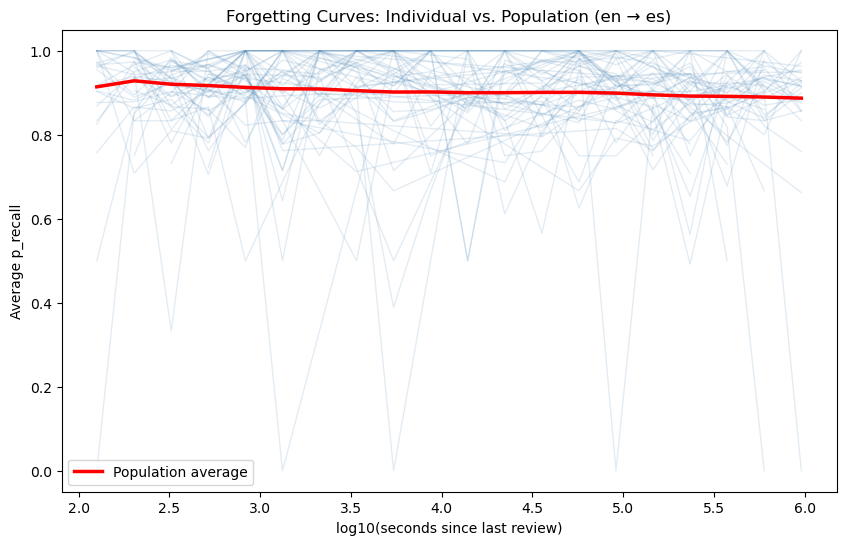


--- Step 2: Naive Half-Life Fitting ---
Fitting per-learner half-life...
Successfully fit: 11,772 users

Half-life summary (days):
count    11772.0
mean        52.5
std         44.2
min          0.0
25%         19.4
50%         43.0
75%         74.2
max        304.0
Name: half_life_days, dtype: float64


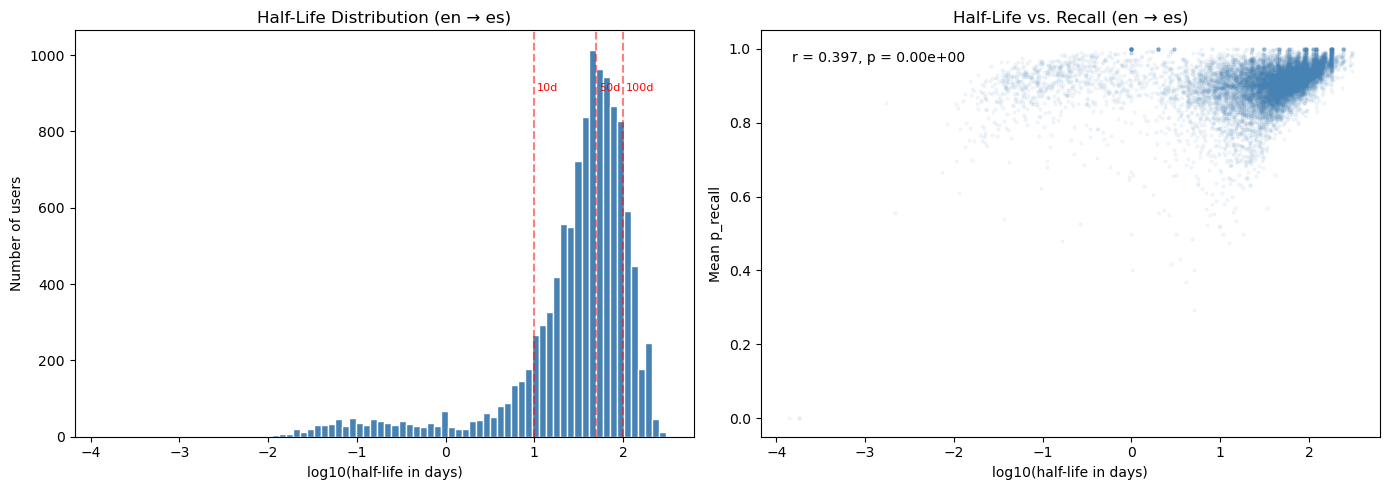


--- Step 3: Hierarchical Model ---
Sampled 500 users, 102,087 rows


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_log_h, sigma_log_h, z, sigma_obs]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1206 seconds.


              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_log_h     3.983  0.045   3.897    4.066      0.002    0.001     884.0   
sigma_log_h  0.814  0.040   0.738    0.886      0.002    0.001     700.0   
sigma_obs    0.264  0.001   0.263    0.265      0.000    0.000    6837.0   

             ess_tail  r_hat  
mu_log_h       1685.0    1.0  
sigma_log_h    1113.0    1.0  
sigma_obs      3295.0    1.0  

--- Step 4: Shrinkage & Posterior Visualization ---
Shrinkage ratio: 0.402


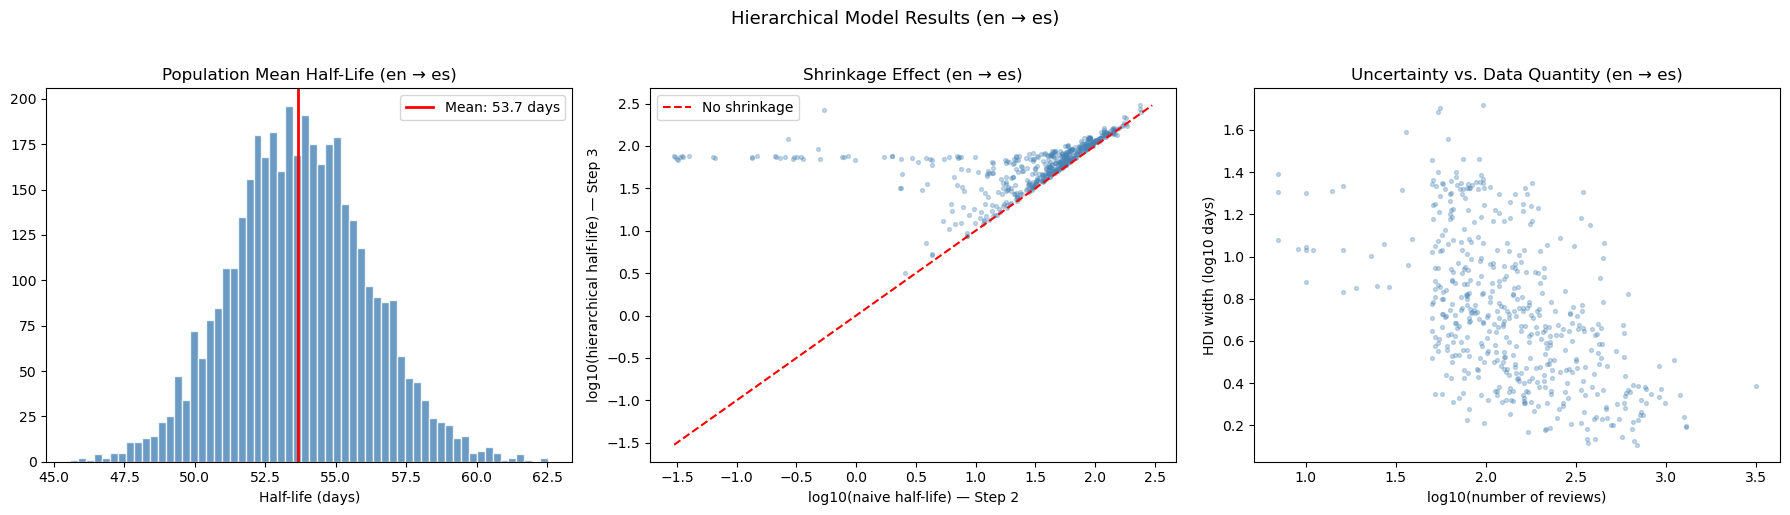


--- Step 5: Feature Engineering & Regression ---

--- Behavioral Model (en → es) ---
R²: 0.043  Adj R²: 0.036  CV R²: -0.026
Feature                                Coef       p
-------------------------------------------------------
intercept                             1.789   0.000 ***
log_n_reviews                        -0.125   0.000 ***
log_n_lexemes                         0.071   0.013 *
log_cv_delta                          0.009   0.555 
log_history_seen                      0.027   0.066 

--- Performance Model (en → es) ---
R²: 0.164  Adj R²: 0.161  CV R²: 0.124
Feature                                Coef       p
-------------------------------------------------------
intercept                             1.789   0.000 ***
mean_accuracy                         0.107   0.000 ***
log_mean_delta                        0.037   0.001 **

--- Full Model (en → es) ---
R²: 0.206  Adj R²: 0.196  CV R²: 0.131
Feature                                Coef       p
----------------------

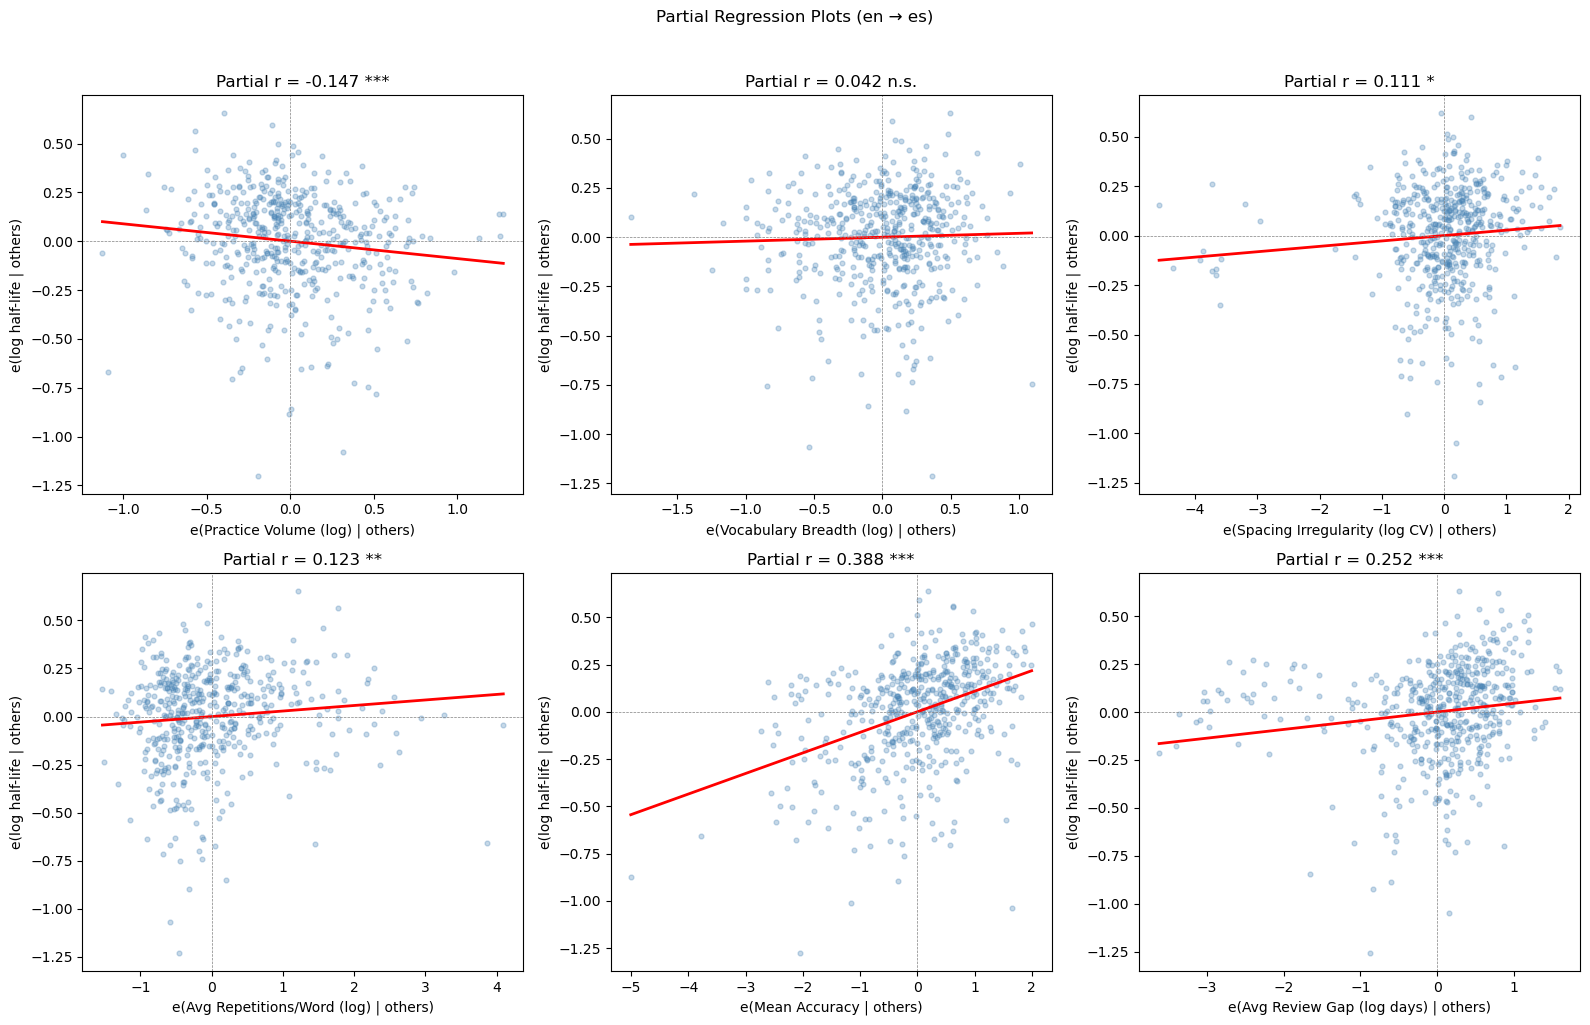


Done! (en → es)


In [27]:
# --- Run full pipeline for EN → ES ---
results_en_es = run_full_pipeline(df, ui_language='en', learning_language='es')

Language pair en → es: 2,579,121 rows, 11,772 users
Fitting per-learner half-life...
Successfully fit: 11,772 users

Half-life summary (days):
count    11772.0
mean        52.5
std         44.2
min          0.0
25%         19.4
50%         43.0
75%         74.2
max        304.0
Name: half_life_days, dtype: float64
Language pair en → fr: 1,455,317 rows, 6,631 users
Fitting per-learner half-life...
Successfully fit: 6,631 users

Half-life summary (days):
count    6631.0
mean       43.9
std        40.8
min         0.0
25%        13.9
50%        34.4
75%        60.7
max       368.0
Name: half_life_days, dtype: float64
Language pair es → en: 2,863,867 rows, 11,928 users
Fitting per-learner half-life...
Successfully fit: 11,928 users

Half-life summary (days):
count    11928.0
mean        49.9
std         44.1
min          0.0
25%         18.0
50%         39.7
75%         69.7
max        368.0
Name: half_life_days, dtype: float64


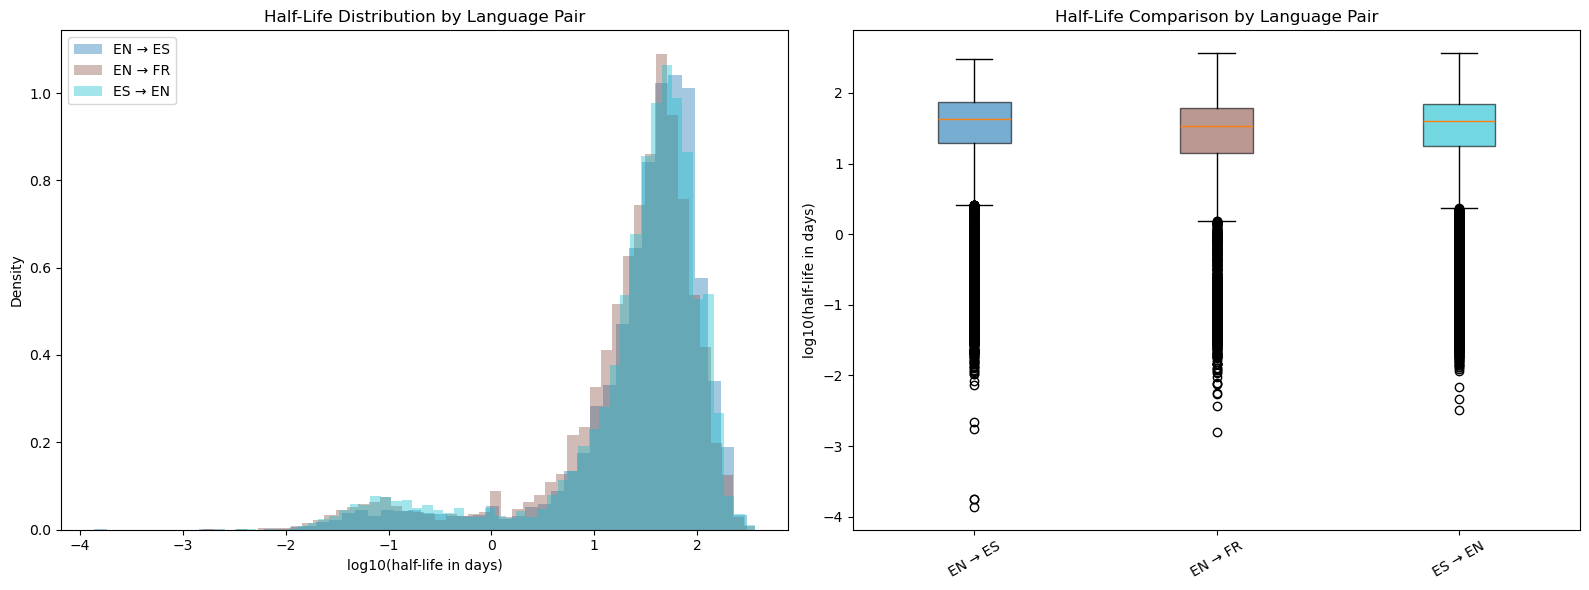


Summary statistics by language pair:
         median  mean   std  count
pair                              
EN → ES    43.0  52.5  44.2  11772
EN → FR    34.4  43.9  40.8   6631
ES → EN    39.7  49.9  44.1  11928


In [28]:
# --- Compare EN → ES vs EN → FR vs ES → EN ---
comparison_df = compare_language_pairs(df, pairs_to_compare=['en_es', 'en_fr', 'es_en'])

Estimating lexeme difficulty...
Fitting half-life for 1,975 lexemes...

Lexeme difficulty summary:
Total lexemes with >= 30 obs: 1,975

Hardest 10 lexemes (lowest mean p_recall):
                       lexeme_id  mean_p_recall  n_observations  lex_half_life_days
392bdde96dfe430ecb1b12467c4878d8       0.477778              45            4.202437
58a5e4f8624f5bfadbac373b3a9f7e49       0.538652              94            3.550087
7aa5807f2e31d0de6287d1a883798824       0.593939              55           10.998506
9eea8c46d07f1e21ef116607649f827d       0.602381              42           10.004597
35464182dc67c97fbffcc4a468c6cdf1       0.628788              33            8.157567
3dd45e18c5354740967f8b09888058d4       0.634146              41            5.571734
6c5b33db379c429c997ca7c87635203c       0.642276              41            7.956780
c7a50cf910b305a94b3788b03e1d7e9f       0.645161              31           14.547752
e5b279f87bbdd6422ed3ca8431e72ed5       0.657692             104  

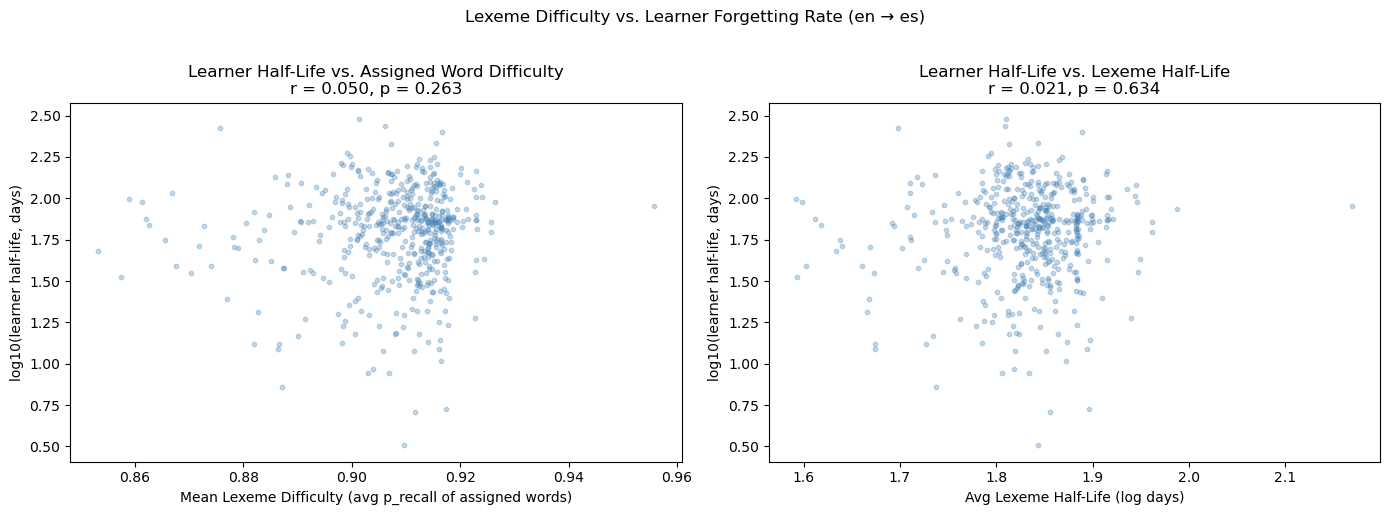

In [29]:
lexeme_df = estimate_lexeme_difficulty(results_en_es['subset'])

features_enriched = add_lexeme_difficulty_to_features(
    results_en_es['features_df'], 
    results_en_es['subset'], 
    lexeme_df
)

run_enriched_regression(features_enriched, title_suffix='(en → es)')

Clustering on 500 learners with features: ['log_h', 'mean_accuracy', 'log_mean_delta', 'log_n_reviews', 'log_cv_delta']


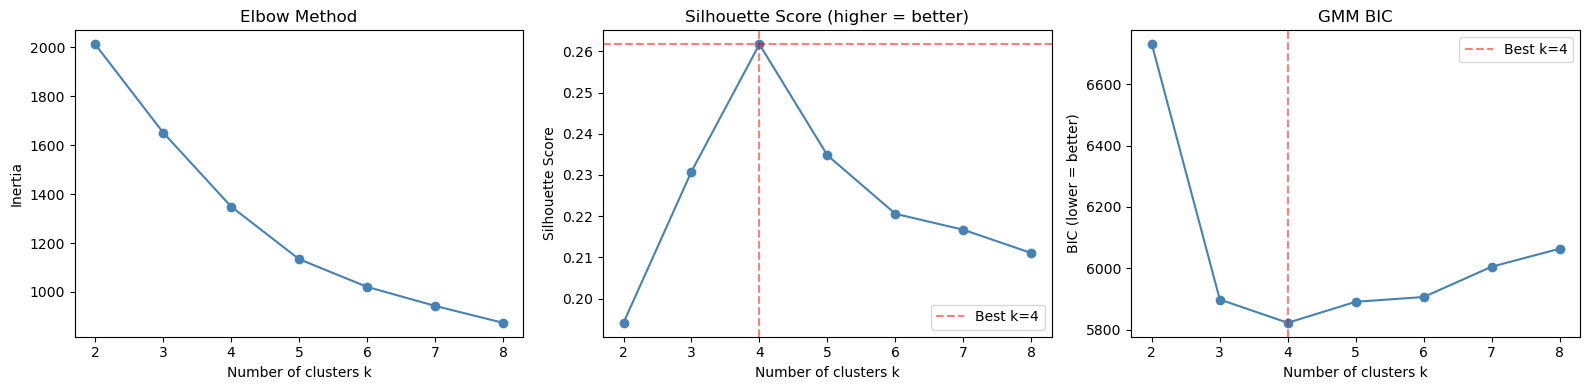


Silhouette suggests k = 4
GMM BIC suggests k   = 4

Cluster profiles:
         log_h  mean_accuracy  log_mean_delta  log_n_reviews  log_cv_delta  \
cluster                                                                      
0.0      1.827          0.903          -1.310          1.907         0.084   
1.0      1.481          0.866           0.172          2.254         0.036   
2.0      1.933          0.922           0.378          2.159         0.022   
3.0      1.957          0.946           0.415          1.117        -1.862   

         h_hierarchical  
cluster                  
0.0              68.577  
1.0              35.282  
2.0              93.261  
3.0              94.225  

Cluster sizes:
cluster
0.0     60
1.0    146
2.0    282
3.0     12
Name: count, dtype: int64


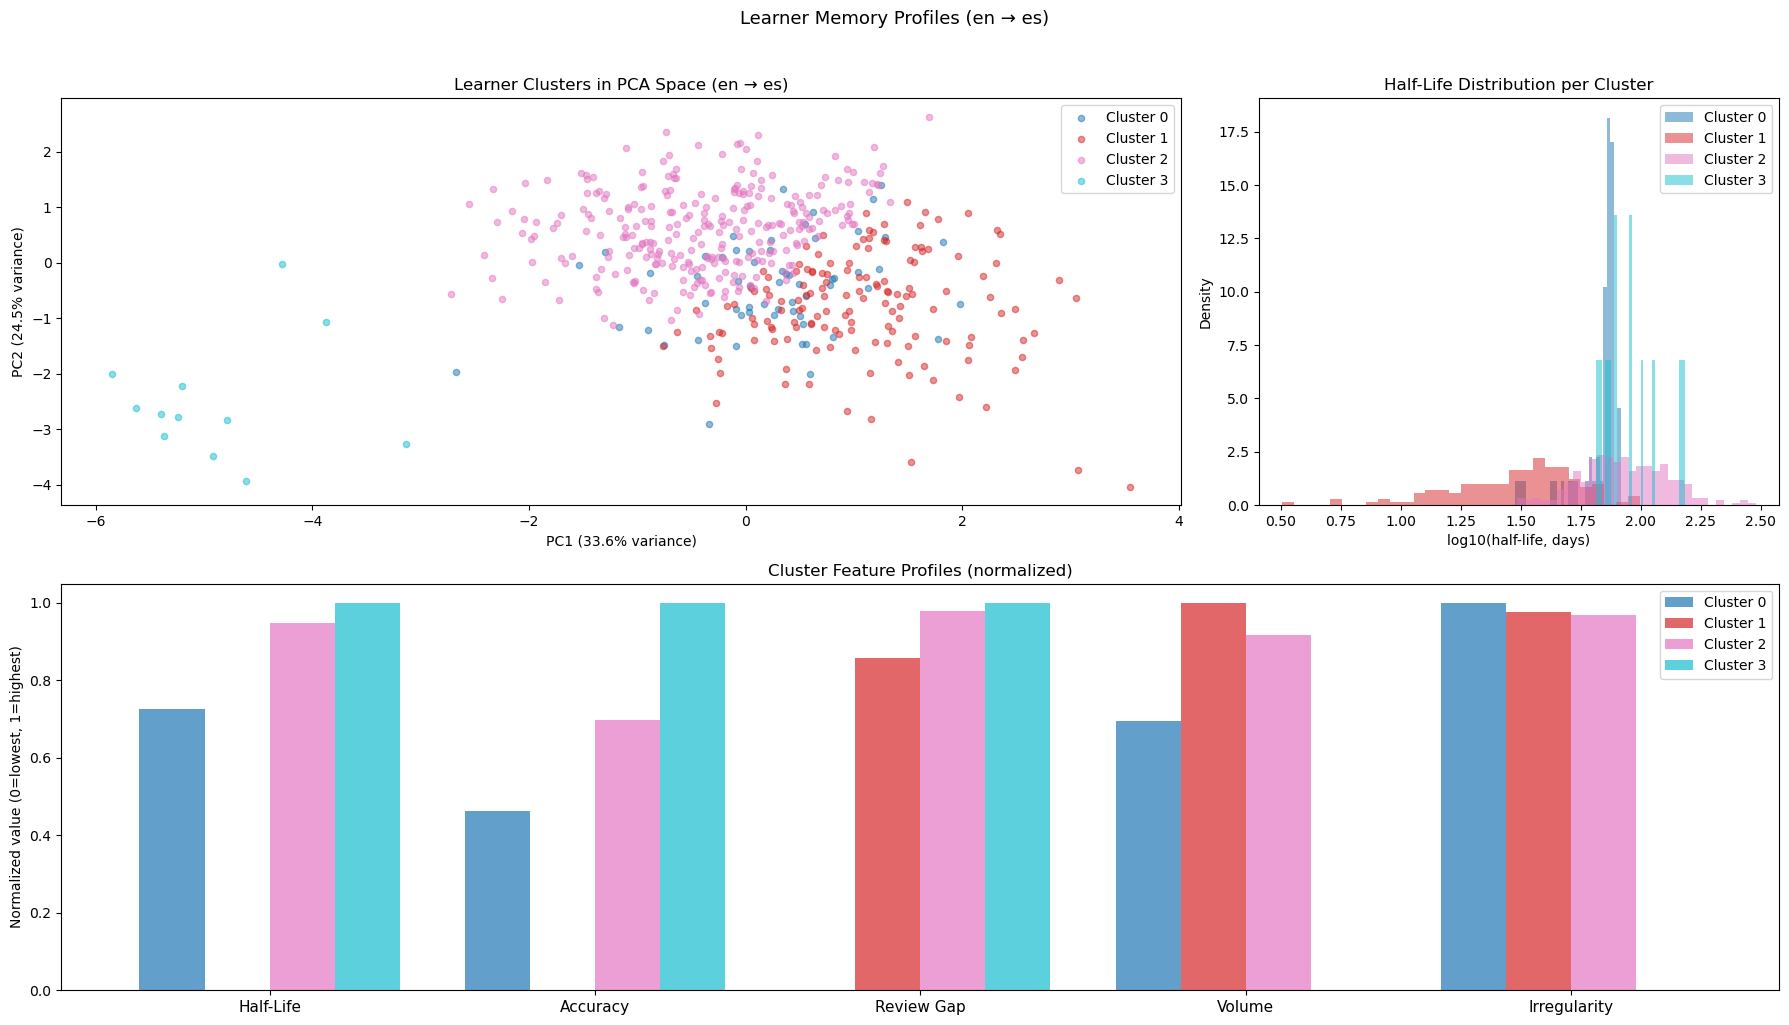

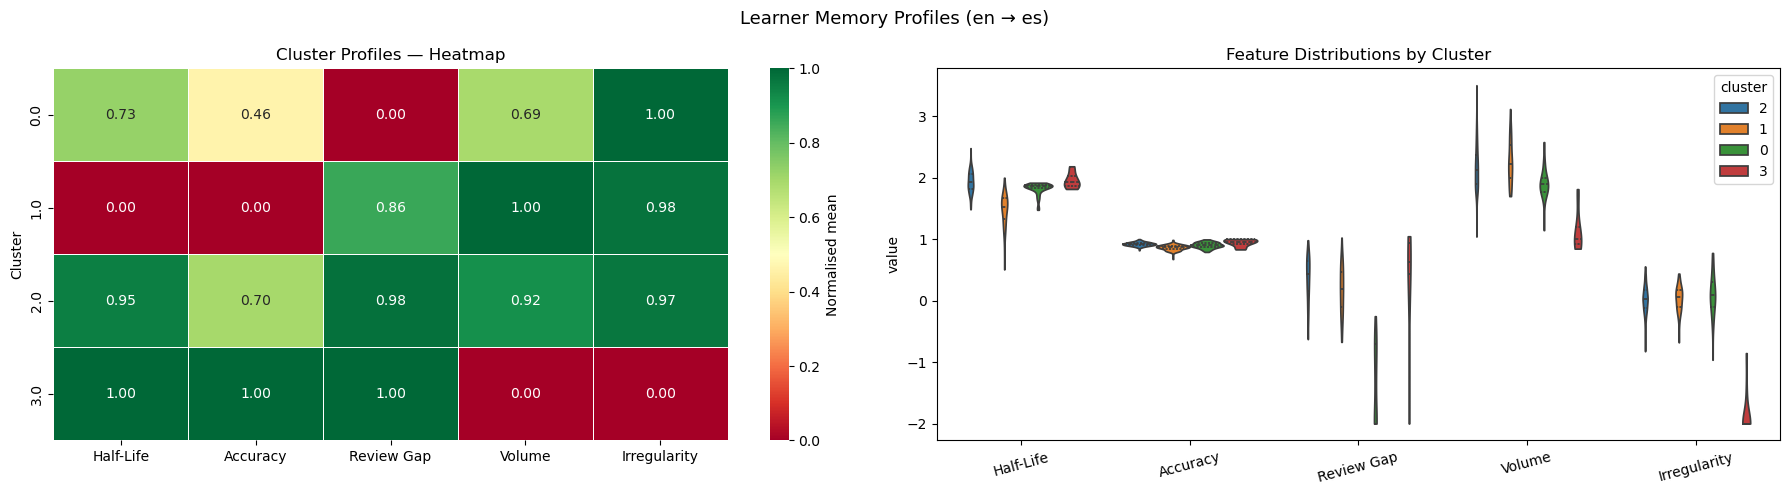

In [30]:
X_scaled, valid_idx, cluster_feats, scaler = prepare_clustering_features(
    features_enriched)

# Find optimal k
best_k_sil, best_k_bic = find_optimal_clusters(X_scaled)

# Pick k (use silhouette suggestion, or override manually)
k = best_k_sil  # or set k = 4 if you want to try a specific value

features_clustered = fit_and_profile_clusters(
    features_enriched, X_scaled, valid_idx, cluster_feats, 
    k=k, title_suffix='(en → es)')

In [31]:
cluster_names = {
    0.0: 'Disengaged Fast Forgetters',
    1.0: 'Struggling Learners',
    2.0: 'Solid Performers',
    3.0: 'Natural Learners'
}
features_clustered['cluster_name'] = features_clustered['cluster'].map(cluster_names)
print(features_clustered['cluster_name'].value_counts())

cluster_name
Solid Performers              282
Struggling Learners           146
Disengaged Fast Forgetters     60
Natural Learners               12
Name: count, dtype: int64


Computing temporal half-lives across 3 phases...
Fitted 1,290 phase estimates across 430 learners


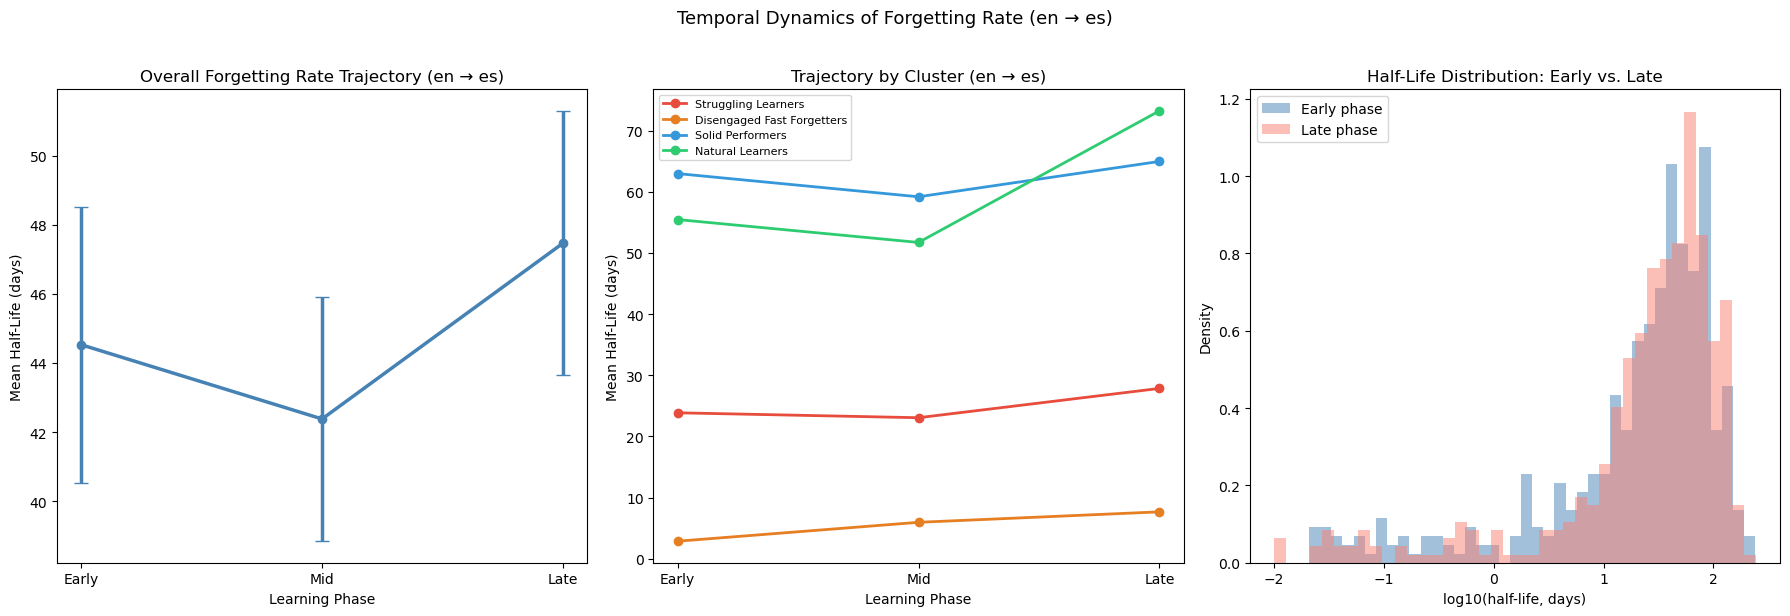


Paired Wilcoxon test (Early vs Late half-life):
  Early mean: 44.5 days
  Late mean:  47.5 days
  Half-life increased from early to late phase
  W = 40589.0, p = 0.0380 * significant

Early vs Late by cluster:
Cluster                           Early     Late   Change        p
------------------------------------------------------------
Struggling Learners                23.9     27.8     +4.0        *
Disengaged Fast Forgetters          2.9      7.7     +4.8        *
Solid Performers                   63.0     65.0     +2.0     n.s.


In [32]:
temporal_df = compute_temporal_halflife(
    results_en_es['subset'],      # or df_filtered filtered to en→es
    features_clustered,
    n_phases=3,
    min_reviews_per_phase=20,
    title_suffix='(en → es)'
)

paired_pivot = plot_temporal_dynamics(temporal_df, title_suffix='(en → es)')


--- Main Effects Only (en → es) ---
R²: 0.199  Adj R²: 0.193  CV R²: 0.145
Feature                           Coef       p
--------------------------------------------------
intercept                        1.789   0.000 ***
Mean Accuracy                    0.107   0.000 ***
Review Gap                       0.049   0.000 ***
Practice Volume                 -0.061   0.000 ***
Spacing Irregularity             0.028   0.042 *

--- Main + Interactions (en → es) ---
R²: 0.226  Adj R²: 0.215  CV R²: 0.165
Feature                           Coef       p
--------------------------------------------------
intercept                        1.790   0.000 ***
Mean Accuracy                    0.114   0.000 ***
Review Gap                       0.047   0.000 ***
Practice Volume                 -0.062   0.000 ***
Spacing Irregularity             0.012   0.404 
Accuracy × Consistency           0.002   0.897 
Accuracy × Review Gap            0.020   0.079 
Accuracy × Volume                0.037   0.008 **

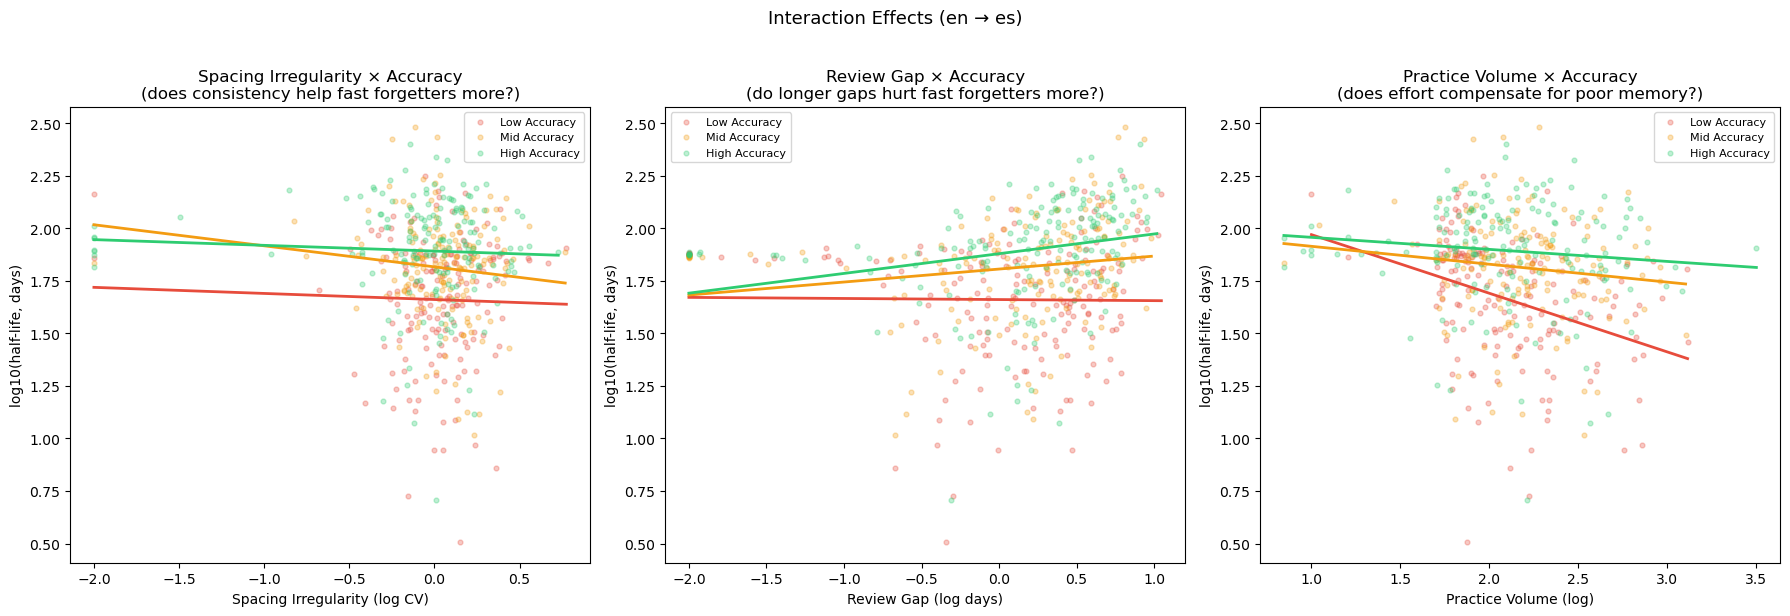

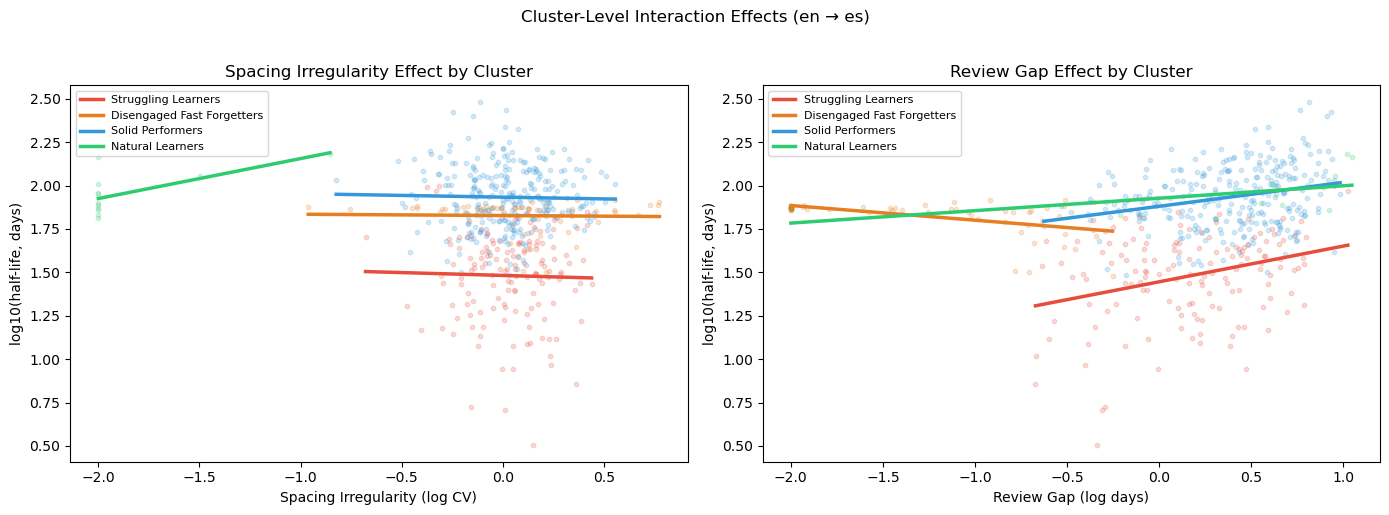

In [33]:
model_inter = run_interaction_analysis(features_clustered, title_suffix='(en → es)')

In [34]:
# =============================================================================
# EXTRACT STRUGGLING LEARNERS ACROSS ALL LANGUAGE PAIRS
# =============================================================================

def extract_struggling_learners_all_pairs(df_filtered, threshold_quantile=0.25,
                                           min_reviews=50, save_csv=True):
    """
    Identify and extract Struggling Learners across all language pairs.
    
    Struggling Learners are defined as users in the bottom quantile of 
    half-life within their language pair (default: bottom 25%).

    Parameters
    ----------
    df_filtered          : full filtered DataFrame from load_and_filter()
    threshold_quantile   : quantile cutoff for "struggling" (default: 0.25)
    min_reviews          : minimum reviews per user (default: 50)
    save_csv             : whether to save output to CSV

    Returns
    -------
    df_struggling_all    : full review history of struggling learners
    struggling_summary   : per-user summary with half-life and language pair
    """

    all_naive = []
    pair_summaries = []

    # --- Step 1: fit naive half-life per language pair ---
    pairs_found = df_filtered.groupby(['ui_language', 'learning_language']).size()
    print(f"Language pairs found: {len(pairs_found)}")
    print(pairs_found.to_string())

    for (ui_lang, learn_lang), group in df_filtered.groupby(
            ['ui_language', 'learning_language']):

        pair_label = f"{ui_lang}→{learn_lang}"
        print(f"\nFitting half-lives for {pair_label} "
              f"({group['user_id'].nunique():,} users)...")

        # Filter to users with enough reviews
        user_counts = group.groupby('user_id').size()
        eligible = user_counts[user_counts >= min_reviews].index
        group_eligible = group[group['user_id'].isin(eligible)]

        if len(eligible) < 10:
            print(f"  Skipping {pair_label} — too few eligible users ({len(eligible)})")
            continue

        # Fit naive half-life
        naive = fit_naive_halflife(group_eligible)
        naive['ui_language']       = ui_lang
        naive['learning_language'] = learn_lang
        naive['pair_label']        = pair_label

        # Define struggling threshold within this pair
        threshold = naive['half_life_days'].quantile(threshold_quantile)
        naive['is_struggling'] = naive['half_life_days'] <= threshold
        naive['hl_percentile'] = naive['half_life_days'].rank(pct=True)

        n_struggling = naive['is_struggling'].sum()
        print(f"  Threshold ({threshold_quantile:.0%} quantile): "
              f"{threshold:.1f} days | Struggling: {n_struggling:,} users")

        pair_summaries.append({
            'pair_label':    pair_label,
            'total_users':   len(naive),
            'n_struggling':  n_struggling,
            'hl_threshold':  threshold,
            'median_hl':     naive['half_life_days'].median()
        })

        all_naive.append(naive)

    # --- Step 2: combine all pairs ---
    all_naive_df = pd.concat(all_naive, ignore_index=True)
    struggling_users = all_naive_df[all_naive_df['is_struggling']]['user_id'].values

    print(f"\n{'='*60}")
    print(f"Total users across all pairs:    {len(all_naive_df):,}")
    print(f"Total struggling learners:       {len(struggling_users):,} "
          f"({100*len(struggling_users)/len(all_naive_df):.1f}%)")

    # --- Step 3: extract full review history ---
    df_struggling_all = df_filtered[
        df_filtered['user_id'].isin(struggling_users)
    ].copy()

    # Merge in user-level metadata
    df_struggling_all = df_struggling_all.merge(
        all_naive_df[['user_id', 'half_life_days', 'hl_percentile',
                      'pair_label', 'ui_language', 'learning_language']],
        on='user_id', how='left'
    )

    print(f"Total reviews from struggling learners: {len(df_struggling_all):,}")

    # --- Step 4: summary table ---
    summary_df = pd.DataFrame(pair_summaries)
    print(f"\nPer language pair breakdown:")
    print(summary_df.to_string(index=False))

    # --- Step 5: quick visualization ---
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Left: struggling count per language pair
    summary_df_sorted = summary_df.sort_values('n_struggling', ascending=True)
    axes[0].barh(summary_df_sorted['pair_label'],
                 summary_df_sorted['n_struggling'],
                 color='steelblue', edgecolor='white')
    axes[0].set_xlabel('Number of Struggling Learners')
    axes[0].set_title('Struggling Learners per Language Pair\n'
                      f'(bottom {threshold_quantile:.0%} half-life within each pair)')

    # Right: half-life distributions with threshold marked per pair
    colors = plt.cm.tab10(np.linspace(0, 1, len(all_naive_df['pair_label'].unique())))
    for (pair, pdf), color in zip(all_naive_df.groupby('pair_label'), colors):
        axes[1].hist(np.log10(pdf['half_life_days'].clip(lower=0.01)),
                     bins=40, alpha=0.4, density=True,
                     color=color, label=pair)
    axes[1].set_xlabel('log10(half-life, days)')
    axes[1].set_ylabel('Density')
    axes[1].set_title('Half-Life Distributions by Language Pair\n'
                      '(struggling = left tail of each)')
    axes[1].legend(fontsize=8)

    plt.tight_layout()
    plt.show()

    # --- Step 6: save ---
    if save_csv:
        df_struggling_all.to_csv('struggling_learners_all_pairs.csv', index=False)
        all_naive_df[all_naive_df['is_struggling']].to_csv(
            'struggling_learners_summary.csv', index=False)
        print(f"\nSaved:")
        print(f"  struggling_learners_all_pairs.csv  — full review history")
        print(f"  struggling_learners_summary.csv    — one row per user with metadata")

    return df_struggling_all, all_naive_df[all_naive_df['is_struggling']]

Language pairs found: 8
ui_language  learning_language
en           de                   1104152
             es                   2579121
             fr                   1455317
             it                    674950
             pt                    251888
es           en                   2863867
it           en                    337062
pt           en                    747969

Fitting half-lives for en→de (5,171 users)...
Fitting per-learner half-life...
Successfully fit: 4,774 users

Half-life summary (days):
count    4774.0
mean       49.7
std        42.8
min         0.0
25%        18.3
50%        39.4
75%        69.0
max       368.0
Name: half_life_days, dtype: float64
  Threshold (25% quantile): 18.3 days | Struggling: 1,194 users

Fitting half-lives for en→es (11,772 users)...
Fitting per-learner half-life...
Successfully fit: 11,386 users

Half-life summary (days):
count    11386.0
mean        53.2
std         44.2
min          0.0
25%         20.3
50%         43.6
75

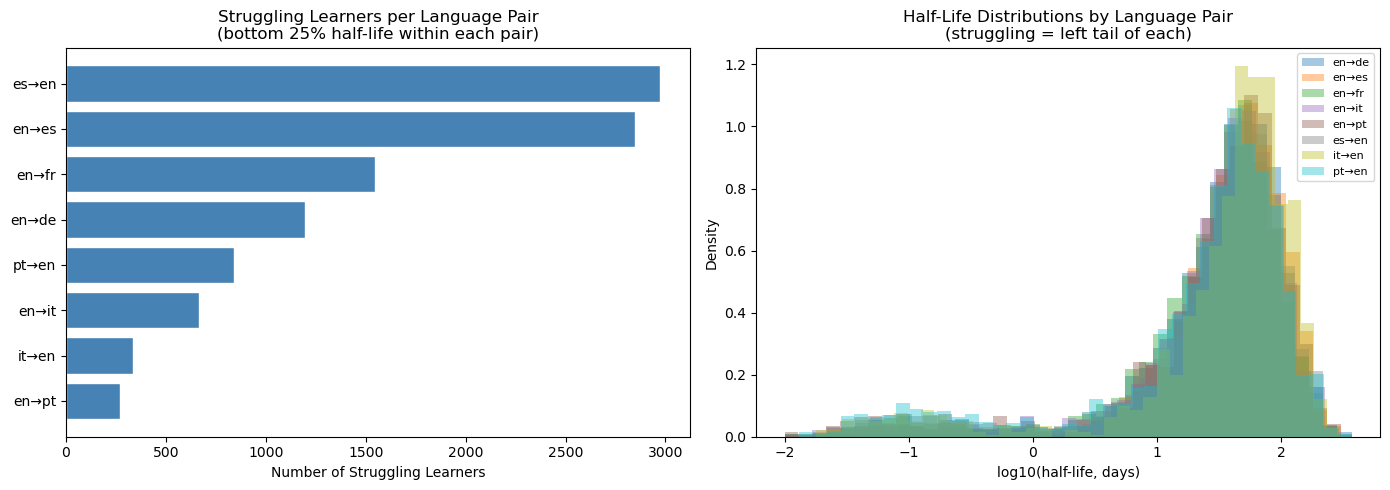


Saved:
  struggling_learners_all_pairs.csv  — full review history
  struggling_learners_summary.csv    — one row per user with metadata


In [35]:
df_struggling_all, struggling_summary = extract_struggling_learners_all_pairs(
    df,
    threshold_quantile=0.25,  # bottom 25% within each pair
    save_csv=True
)

In [ ]:
def extract_struggling_learners_all_pairs(df_filtered, save_csv=True):
    """
    Extract Struggling Learners across all language pairs using a 
    multi-feature definition that matches the cluster profile:
    
    Struggling = bottom 35% half-life
               + below median accuracy  
               + above median practice volume
               + above median review gap  ← this excludes Disengaged Fast Forgetters
                                            who have very short gaps
    """
    all_naive = []
    pair_summaries = []

    for (ui_lang, learn_lang), group in df_filtered.groupby(
        ['ui_language', 'learning_language']):

        pair_label = f"{ui_lang}→{learn_lang}"
        print(f"\nProcessing {pair_label} "
            f"({group['user_id'].nunique():,} users)...")

        user_counts = group.groupby('user_id').size()
        eligible = user_counts[user_counts >= 50].index
        group_eligible = group[group['user_id'].isin(eligible)]

        if len(eligible) < 10:
            print(f"  Skipping — too few eligible users")
            continue

        # Fit naive half-life (already includes n_reviews)
        naive = fit_naive_halflife(group_eligible)
        naive['ui_language']       = ui_lang
        naive['learning_language'] = learn_lang
        naive['pair_label']        = pair_label

        # Compute additional behavioral features (NOT n_reviews — already in naive)
        user_features = []
        for user_id, udf in group_eligible.groupby('user_id'):
            user_features.append({
                'user_id':         user_id,
                'mean_accuracy':   (udf['history_correct'] /
                                udf['history_seen'].clip(lower=1)).mean(),
                'mean_delta_days': udf['delta'].mean() / 86400,
            })
        feat_df = pd.DataFrame(user_features)
        naive = naive.merge(feat_df, on='user_id', how='left')

        # Thresholds
        hl_thresh  = naive['half_life_days'].quantile(0.35)
        acc_thresh = naive['mean_accuracy'].quantile(0.50)
        vol_thresh = naive['n_reviews'].quantile(0.50)
        gap_thresh = naive['mean_delta_days'].quantile(0.35)

        naive['is_struggling'] = (
            (naive['half_life_days'] <= hl_thresh)   &
            (naive['mean_accuracy']  <= acc_thresh)  &
            (naive['n_reviews']      >= vol_thresh)  &
            (naive['mean_delta_days']>= gap_thresh)
        )
        naive['hl_percentile'] = naive['half_life_days'].rank(pct=True)

        n_struggling = naive['is_struggling'].sum()
        pct = 100 * n_struggling / len(naive)
        print(f"  Struggling: {n_struggling:,} users ({pct:.1f}%)")
        print(f"  Thresholds — HL: {hl_thresh:.1f}d | "
            f"Acc: {acc_thresh:.3f} | "
            f"Vol: {vol_thresh:.0f} reviews | "
            f"Gap: {gap_thresh:.2f}d")

        pair_summaries.append({
            'pair_label':   pair_label,
            'total_users':  len(naive),
            'n_struggling': n_struggling,
            'pct':          pct,
            'hl_threshold': hl_thresh,
        })
        all_naive.append(naive)
    # --- Combine ---
    all_naive_df = pd.concat(all_naive, ignore_index=True)
    struggling_users = all_naive_df[all_naive_df['is_struggling']]['user_id'].values

    print(f"\n{'='*60}")
    print(f"Total users:             {len(all_naive_df):,}")
    print(f"Total struggling:        {len(struggling_users):,} "
          f"({100*len(struggling_users)/len(all_naive_df):.1f}%)")

    # --- Extract full review history ---
    df_struggling_all = df_filtered[
        df_filtered['user_id'].isin(struggling_users)
    ].copy()
    df_struggling_all = df_struggling_all.merge(
        all_naive_df[['user_id', 'half_life_days', 'hl_percentile',
                      'pair_label', 'ui_language', 'learning_language',
                      'mean_accuracy', 'mean_delta_days', 'n_reviews']],
        on='user_id', how='left'
    )

    print(f"Total reviews:           {len(df_struggling_all):,}")

    # --- Summary table ---
    summary_df = pd.DataFrame(pair_summaries)
    print(f"\nPer language pair:")
    print(summary_df.to_string(index=False))

    # --- Plot ---
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    summary_sorted = summary_df.sort_values('n_struggling', ascending=True)
    axes[0].barh(summary_sorted['pair_label'], summary_sorted['n_struggling'],
                 color='#e74c3c', edgecolor='white', alpha=0.8)
    axes[0].set_xlabel('Number of Struggling Learners')
    axes[0].set_title('Struggling Learners per Language Pair\n'
                      '(low HL + low accuracy + high volume + non-bursty)')

    # Half-life distribution: struggling vs rest
    struggling_hl = np.log10(
        all_naive_df[all_naive_df['is_struggling']]['half_life_days'].clip(lower=0.01))
    rest_hl = np.log10(
        all_naive_df[~all_naive_df['is_struggling']]['half_life_days'].clip(lower=0.01))
    axes[1].hist(rest_hl, bins=60, alpha=0.5, density=True,
                 color='steelblue', label='Other learners')
    axes[1].hist(struggling_hl, bins=60, alpha=0.6, density=True,
                 color='#e74c3c', label='Struggling Learners')
    axes[1].set_xlabel('log10(half-life, days)')
    axes[1].set_ylabel('Density')
    axes[1].set_title('Half-Life: Struggling vs. Rest')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

    # --- Save ---
    if save_csv:
        df_struggling_all.to_csv('struggling_learners_all_pairs.csv', index=False)
        all_naive_df[all_naive_df['is_struggling']].to_csv(
            'struggling_learners_summary.csv', index=False)
        print(f"\nSaved:")
        print(f"  struggling_learners_all_pairs.csv — full review history")
        print(f"  struggling_learners_summary.csv   — one row per user")

    return df_struggling_all, all_naive_df[all_naive_df['is_struggling']]

In [48]:
def extract_struggling_learners_all_pairs(df_filtered, km, cluster_feats, 
                                           save_csv=True):
    """
    Extract Struggling Learners across all language pairs using a 
    multi-feature definition that matches the cluster profile.
    
    Now also assigns cluster labels to ALL users using the fitted KMeans model.

    Parameters
    ----------
    df_filtered   : full filtered DataFrame from load_and_filter()
    km            : fitted KMeans model from fit_and_profile_clusters()
    cluster_feats : feature list used during clustering
                    ['log_h', 'mean_accuracy', 'log_mean_delta', 
                     'log_n_reviews', 'log_cv_delta']
    save_csv      : whether to save output CSVs
    """
    cluster_names = {
        0: 'Disengaged Fast Forgetters',
        1: 'Struggling Learners',
        2: 'Solid Performers',
        3: 'Natural Learners'
    }

    all_naive = []
    pair_summaries = []

    for (ui_lang, learn_lang), group in df_filtered.groupby(
        ['ui_language', 'learning_language']):

        pair_label = f"{ui_lang}→{learn_lang}"
        print(f"\nProcessing {pair_label} "
              f"({group['user_id'].nunique():,} users)...")

        user_counts = group.groupby('user_id').size()
        eligible = user_counts[user_counts >= 50].index
        group_eligible = group[group['user_id'].isin(eligible)]

        if len(eligible) < 10:
            print(f"  Skipping — too few eligible users")
            continue

        # Fit naive half-life (already includes n_reviews)
        naive = fit_naive_halflife(group_eligible)
        naive['ui_language']       = ui_lang
        naive['learning_language'] = learn_lang
        naive['pair_label']        = pair_label

        # Compute additional behavioral features
        user_features = []
        for user_id, udf in group_eligible.groupby('user_id'):
            delta_vals = udf['delta'].values
            mean_delta = delta_vals.mean()
            user_features.append({
                'user_id':         user_id,
                'mean_accuracy':   (udf['history_correct'] /
                                   udf['history_seen'].clip(lower=1)).mean(),
                'mean_delta_days': mean_delta / 86400,
                # Pre-compute clustering features here too
                'log_mean_delta':  np.log10(max(mean_delta / 86400, 0.01)),
                'log_cv_delta':    np.log10(max(
                                       delta_vals.std() / mean_delta
                                       if mean_delta > 0 else 0.01, 0.01)),
            })
        feat_df = pd.DataFrame(user_features)
        naive = naive.merge(feat_df, on='user_id', how='left')

        # Add remaining clustering features
        naive['log_h']         = np.log10(naive['half_life_days'].clip(lower=0.01))
        naive['log_n_reviews'] = np.log10(naive['n_reviews'])

        # Thresholds for struggling definition
        hl_thresh  = naive['half_life_days'].quantile(0.35)
        acc_thresh = naive['mean_accuracy'].quantile(0.50)
        vol_thresh = naive['n_reviews'].quantile(0.50)
        gap_thresh = naive['mean_delta_days'].quantile(0.35)

        naive['is_struggling'] = (
            (naive['half_life_days'] <= hl_thresh)   &
            (naive['mean_accuracy']  <= acc_thresh)  &
            (naive['n_reviews']      >= vol_thresh)  &
            (naive['mean_delta_days']>= gap_thresh)
        )
        naive['hl_percentile'] = naive['half_life_days'].rank(pct=True)

        n_struggling = naive['is_struggling'].sum()
        pct = 100 * n_struggling / len(naive)
        print(f"  Struggling: {n_struggling:,} users ({pct:.1f}%)")

        pair_summaries.append({
            'pair_label':   pair_label,
            'total_users':  len(naive),
            'n_struggling': n_struggling,
            'pct':          pct,
            'hl_threshold': hl_thresh,
        })
        all_naive.append(naive)

    # --- Combine all pairs ---
    all_naive_df = pd.concat(all_naive, ignore_index=True)

    # --- Assign cluster to ALL users using fitted KMeans ---
    print(f"\nAssigning clusters to all {len(all_naive_df):,} users...")

    # Build feature matrix — same features used in clustering
    # cluster_feats = ['log_h', 'mean_accuracy', 'log_mean_delta',
    #                  'log_n_reviews', 'log_cv_delta']
    X_all = all_naive_df[cluster_feats].copy()
    X_all = X_all.fillna(X_all.median())  # safety for any NaN

    # Standardize — refit scaler on this full population
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_all.values)

    # Predict using fitted KMeans
    all_naive_df['cluster']      = km.predict(X_scaled)
    all_naive_df['cluster_name'] = all_naive_df['cluster'].map(cluster_names)

    # --- Summary ---
    struggling_users = all_naive_df[all_naive_df['is_struggling']]['user_id'].values

    print(f"\n{'='*60}")
    print(f"Total users:             {len(all_naive_df):,}")
    print(f"Total struggling:        {len(struggling_users):,} "
          f"({100*len(struggling_users)/len(all_naive_df):.1f}%)")
    print(f"\nCluster distribution (all users):")
    print(all_naive_df['cluster_name'].value_counts())
    print(f"\nCluster × struggling cross-tab:")
    print(pd.crosstab(all_naive_df['cluster_name'], 
                      all_naive_df['is_struggling'],
                      margins=True))

    # --- Extract full review history with cluster column ---
    df_all_with_clusters = df_filtered.merge(
        all_naive_df[['user_id', 'half_life_days', 'hl_percentile',
                      'pair_label', 'ui_language', 'learning_language',
                      'mean_accuracy', 'mean_delta_days', 'n_reviews',
                      'is_struggling', 'cluster', 'cluster_name']],
        on='user_id', how='left'
    )

    # Struggling learners subset
    df_struggling_all = df_all_with_clusters[
        df_all_with_clusters['is_struggling']
    ].copy()

    print(f"\nFull dataset with clusters: {len(df_all_with_clusters):,} rows")
    print(f"Struggling learners rows:   {len(df_struggling_all):,}")

    # --- Plots ---
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Left: struggling count per pair
    summary_df = pd.DataFrame(pair_summaries)
    summary_sorted = summary_df.sort_values('n_struggling', ascending=True)
    axes[0].barh(summary_sorted['pair_label'], summary_sorted['n_struggling'],
                 color='#e74c3c', edgecolor='white', alpha=0.8)
    axes[0].set_xlabel('Number of Struggling Learners')
    axes[0].set_title('Struggling Learners per Language Pair')

    # Middle: cluster distribution overall
    cluster_counts = all_naive_df['cluster_name'].value_counts()
    colors = ['#2ecc71', '#3498db', '#e67e22', '#e74c3c']
    axes[1].bar(cluster_counts.index, cluster_counts.values,
                color=colors[:len(cluster_counts)],
                edgecolor='white', alpha=0.85)
    axes[1].set_ylabel('Number of users')
    axes[1].set_title('Cluster Distribution — All Users')
    axes[1].tick_params(axis='x', rotation=20)
    for i, (label, val) in enumerate(cluster_counts.items()):
        pct = 100 * val / len(all_naive_df)
        axes[1].text(i, val + 20, f'{pct:.1f}%', ha='center', fontsize=9)

    # Right: half-life distribution by cluster
    for cname, color in zip(
        ['Natural Learners', 'Solid Performers', 
         'Disengaged Fast Forgetters', 'Struggling Learners'],
        ['#2ecc71', '#3498db', '#e67e22', '#e74c3c']
    ):
        data = np.log10(
            all_naive_df[all_naive_df['cluster_name'] == cname]
            ['half_life_days'].clip(lower=0.01))
        if len(data) > 0:
            axes[2].hist(data, bins=40, alpha=0.5, density=True,
                         color=color, label=cname)
    axes[2].set_xlabel('log10(half-life, days)')
    axes[2].set_ylabel('Density')
    axes[2].set_title('Half-Life Distribution by Cluster')
    axes[2].legend(fontsize=8)

    plt.suptitle('Full Dataset — Cluster Assignment Across All Users',
                 fontsize=13, y=1.02)
    plt.tight_layout()
    plt.show()

    # --- Save ---
    if save_csv:
        # Full dataset with cluster column
        df_all_with_clusters.to_csv('full_dataset_with_clusters.csv', index=False)
        # Struggling learners only
        df_struggling_all.to_csv('struggling_learners_all_pairs.csv', index=False)
        # Per-user summary
        all_naive_df.to_csv('all_users_summary.csv', index=False)
        print(f"\nSaved:")
        print(f"  full_dataset_with_clusters.csv  — all users, all reviews, with cluster")
        print(f"  struggling_learners_all_pairs.csv — struggling learners only")
        print(f"  all_users_summary.csv           — one row per user with cluster")

    return df_all_with_clusters, df_struggling_all, all_naive_df

In [ ]:
df_all_with_clusters, df_struggling_all, all_users_summary = \
    extract_struggling_learners_all_pairs(
        df,
        km=km,                    # fitted KMeans from fit_and_profile_clusters()
        cluster_feats=cluster_feats,  # ['log_h', 'mean_accuracy', 'log_mean_delta',
                                      #  'log_n_reviews', 'log_cv_delta']
        save_csv=True
    )


Processing en→de (5,171 users)...
Fitting per-learner half-life...
Successfully fit: 4,774 users

Half-life summary (days):
count    4774.0
mean       49.7
std        42.8
min         0.0
25%        18.3
50%        39.4
75%        69.0
max       368.0
Name: half_life_days, dtype: float64
  Struggling: 198 users (4.1%)
  Thresholds — HL: 26.9d | Acc: 0.906 | Vol: 132 reviews | Gap: 1.19d

Processing en→es (11,772 users)...
Fitting per-learner half-life...
Successfully fit: 11,386 users

Half-life summary (days):
count    11386.0
mean        53.2
std         44.2
min          0.0
25%         20.3
50%         43.6
75%         74.6
max        304.0
Name: half_life_days, dtype: float64
  Struggling: 431 users (3.8%)
  Thresholds — HL: 29.3d | Acc: 0.903 | Vol: 131 reviews | Gap: 1.24d

Processing en→fr (6,631 users)...
Fitting per-learner half-life...
Successfully fit: 6,174 users

Half-life summary (days):
count    6174.0
mean       45.3
std        41.1
min         0.0
25%        15.0
50%

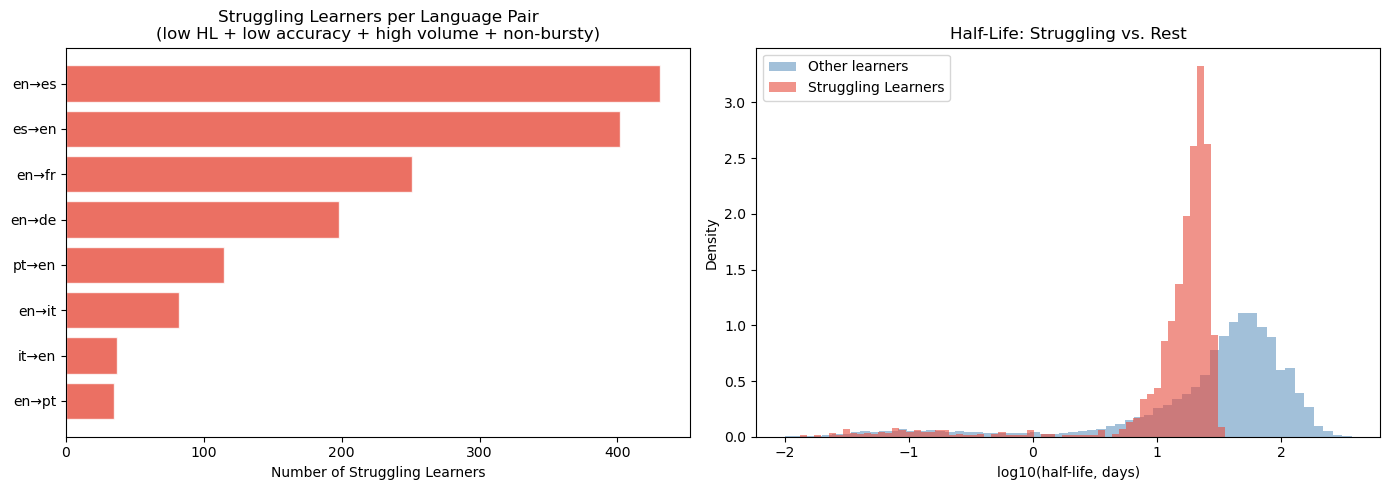


Saved:
  struggling_learners_all_pairs.csv — full review history
  struggling_learners_summary.csv   — one row per user


In [31]:
df_struggling_all, struggling_summary = extract_struggling_learners_all_pairs(
    df, save_csv=True)

In [39]:
df_struggling_all

p_recall   timestamp   delta user_id learning_language_x  \
0             1.0  1362082530  261691  u:hiS4                  fr   
1             0.5  1362082530  231391  u:hiS4                  fr   
2             1.0  1362082530  232832  u:hiS4                  fr   
3             1.0  1362082530  196898  u:hiS4                  fr   
4             0.0  1362082530  274171  u:hiS4                  fr   
...           ...         ...     ...     ...                 ...   
2155065       1.0  1363104888  100758  u:jdQ2                  de   
2155066       0.0  1363104888  100758  u:jdQ2                  de   
2155067       1.0  1363104888  100758  u:jdQ2                  de   
2155068       1.0  1363104888  100758  u:jdQ2                  de   
2155069       1.0  1363104888  100758  u:jdQ2                  de   

        ui_language_x                         lexeme_id  \
0                  en  03a546003e03b545a6d419b6620b3749   
1                  en  8bd6d060bb604e17c936418f835d87c8   
2                  en  1b279bb64bd6eba51ab37e4a61aad0c4   
3                  en  8e6df998cc5c26b86482a3040a5805e2   
4                  en  3ec6ed7d5a122ac3018def0b4f621b12   
...               ...                               ...   
2155065            en  ba88540d7ce79d5bf8353405fd321f0a   
2155066            en  819893931391551b79525db409181547   
2155067            en  40bcbd8339eeae2ed5ee89caf5c517c5   
2155068            en  2429597b6723a98e21068629ab3f4231   
2155069            en  5ac6336de0f683c21074570627e9410b   

                           lexeme_string  history_seen  history_correct  ...  \
0                 la/le<det><def><f><sg>            31               23  ...   
1               mon/mon<det><pos><m><sg>            28               27  ...   
2              mes/mon<det><pos><mf><pl>             2                2  ...   
3                 c'/ce<prn><tn><nt><sg>            19               18  ...   
4            nouveau/nouveau<adj><m><sg>             6                5  ...   
...                                  ...           ...              ...  ...   
2155065        brot/brot<n><nt><sg><acc>             6                6  ...   
2155066  essen/essen<vblex><pri><p3><pl>             1                1  ...   
2155067        brot/brot<n><nt><sg><nom>             1                1  ...   
2155068   esst/essen<vblex><pri><p2><pl>             5                4  ...   
2155069  essen/essen<vblex><pri><p1><pl>             4                4  ...   

               case  definiteness degree pronoun_type adj_declension  \
0               NaN      definite    NaN          NaN            NaN   
1               NaN    possessive    NaN          NaN            NaN   
2               NaN    possessive    NaN          NaN            NaN   
3               NaN           NaN    NaN          NaN            NaN   
4               NaN           NaN    NaN          NaN            NaN   
...             ...           ...    ...          ...            ...   
2155065  accusative           NaN    NaN          NaN            NaN   
2155066         NaN           NaN    NaN          NaN            NaN   
2155067  nominative           NaN    NaN          NaN            NaN   
2155068         NaN           NaN    NaN          NaN            NaN   
2155069         NaN           NaN    NaN          NaN            NaN   

        half_life_days hl_percentile pair_label ui_language_y  \
0             7.671305      0.149660      en→fr            en   
1             7.671305      0.149660      en→fr            en   
2             7.671305      0.149660      en→fr            en   
3             7.671305      0.149660      en→fr            en   
4             7.671305      0.149660      en→fr            en   
...                ...           ...        ...           ...   
2155065       7.191852      0.115626      en→de            en   
2155066       7.191852      0.115626      en→de            en   
2155067       7.191852      0.115626      en→de            e

In [35]:
struggling_summary

user_id     half_life  half_life_days  n_reviews  mean_p_recall  \
6       u:-t7  1.915901e+06       22.174776        311       0.718114   
9       u:1EF  7.214328e+05        8.349917        241       0.618949   
40      u:DRN  1.484653e+06       17.183486        136       0.762255   
59      u:IAx  2.115869e+06       24.489230        251       0.876494   
75      u:Ljt  2.189350e+06       25.339700        132       0.922276   
...       ...           ...             ...        ...            ...   
42485  u:ilkZ  1.755755e+06       20.321238        197       0.837563   
42544  u:ipIU  1.289121e+06       14.920383        586       0.779803   
42552  u:iprR  1.589850e+06       18.401039        184       0.763587   
42605  u:iyVh  1.718775e+06       19.893233        145       0.843153   
42613  u:iz8-  1.624183e+06       18.798416        723       0.816690   

      ui_language learning_language pair_label  mean_accuracy  \
6              en                de      en→de       0.772201   
9              en                de      en→de       0.793798   
40             en                de      en→de       0.831830   
59             en                de      en→de       0.884366   
75             en                de      en→de       0.868974   
...           ...               ...        ...            ...   
42485          pt                en      pt→en       0.872886   
42544          pt                en      pt→en       0.812110   
42552          pt                en      pt→en       0.899540   
42605          pt                en      pt→en       0.887758   
42613          pt                en      pt→en       0.862505   

       mean_delta_days  is_struggling  hl_percentile  
6             4.814862           True       0.293046  
9             1.584357           True       0.128823  
40            4.369550           True       0.237746  
59            2.169517           True       0.322371  
75            1.248840           True       0.332216  
...                ...            ...            ...  
42485         1.734851           True       0.323328  
42544         1.340750           True       0.255275  
42552         3.279764           True       0.297771  
42605         1.702662           True       0.317682  
42613         2.123521           True       0.303418  

[1551 rows x 12 columns]

In [3]:
df_struggling_all = pd.read_csv('../datasets/struggling_learners_all_pairs.csv')
df_struggling_all.to_parquet('../datasets/struggling_learners_all_pairs.parquet')

In [43]:
df_struggling = pd.read_csv('../datasets/struggling_learners_all_pairs.csv')

In [45]:
df = pd.read_csv("../datasets/duo_data.csv")

In [47]:
df_struggling

p_recall   timestamp   delta user_id learning_language_x  \
0            0.0  1362082541   28703  u:hSWF                  pt   
1            0.0  1362082541   19513  u:hSWF                  pt   
2            1.0  1362082541   77288  u:hSWF                  pt   
3            0.0  1362082541   27748  u:hSWF                  pt   
4            1.0  1362082541   23208  u:hSWF                  pt   
...          ...         ...     ...     ...                 ...   
702026       1.0  1363104890   90151  u:iZE_                  de   
702027       1.0  1363104890   90151  u:iZE_                  de   
702028       1.0  1363104890   90151  u:iZE_                  de   
702029       1.0  1363104890  543697  u:iZE_                  de   
702030       1.0  1363104890   91261  u:iZE_                  de   

       ui_language_x                         lexeme_id  \
0                 en  2d31fcb7e3781d53d073d32874dcb5f4   
1                 en  2cedf47e09d69a11efbcdc6e6a59a3c6   
2                 en  3b90f64dfa33918b221e0aabd249dc75   
3                 en  e44f3f20553dc6b97334e3c7cc574ced   
4                 en  e07321c588bfe75e4d09b4628517218a   
...              ...                               ...   
702026            en  9c71eca1890e52aa70c73f59b7d215ca   
702027            en  de7cc64f2f73345c893d3de9bf662804   
702028            en  d2c8d82b57a02448138c274e578261de   
702029            en  5aa51924d40dbbb404d78bcfd3224157   
702030            en  736c10e324d136ddb518e884285823a5   

                                lexeme_string  history_seen  history_correct  \
0                                 até/até<pr>             4                1   
1             falam/falar<vblex><pri><p3><pl>             2                2   
2                     quando/quando<adv><itg>             5                3   
3                            ontem/ontem<adv>             8                5   
4            quero/querer<vblex><pri><p1><sg>             1                1   
...                                       ...           ...              ...   
702026           lehrer/lehrer<n><m><pl><nom>             5                3   
702027        magst/mögen<vbmod><pri><p2><sg>             5                5   
702028  restaurant/restaurant<n><nt><sg><dat>             7                5   
702029             tisch/tisch<n><m><sg><acc>             3                3   
702030               mann/mann<n><m><sg><acc>             7                7   

        ...  pronoun_type  adj_declension half_life_days hl_percentile  \
0       ...           NaN             NaN      24.377594      0.317844   
1       ...           NaN             NaN      24.377594      0.317844   
2       ...           NaN             NaN      24.377594      0.317844   
3       ...           NaN             NaN      24.377594      0.317844   
4       ...           NaN             NaN      24.377594      0.317844   
...     ...           ...             ...            ...           ...   
702026  ...           NaN             NaN      24.806050      0.325723   
702027  ...           NaN             NaN      24.806050      0.325723   
702028  ...           NaN             NaN      24.806050      0.325723   
702029  ...           NaN             NaN      24.806050      0.325723   
702030  ...           NaN             NaN      24.806050      0.325723   

       pair_label ui_language_y learning_language_y mean_accuracy  \
0           en→pt            en                  pt      0.856565   
1           en→pt            en                  pt      0.856565   
2           en→pt            en                  pt      0.856565   
3           en→pt            en                  pt      0.856565   
4           en→pt            en                  pt      0.856565   
...           ...           ...                 ...           ...   
702026      en→de            en                  de      0.890212   
702027      en→de            en                  de      0.890212   
702028      en→de      

In [46]:
df

p_recall   timestamp     delta user_id learning_language  \
0         1.000000  1362076081  27649635    u:FO                de   
1         0.500000  1362076081  27649635    u:FO                de   
2         1.000000  1362076081  27649635    u:FO                de   
3         0.500000  1362076081  27649635    u:FO                de   
4         1.000000  1362076081  27649635    u:FO                de   
...            ...         ...       ...     ...               ...   
12854221  0.800000  1363104897       368  u:i5D8                en   
12854222  0.800000  1363104897       368  u:i5D8                en   
12854223  1.000000  1363104897       368  u:i5D8                en   
12854224  0.600000  1363104897       368  u:i5D8                en   
12854225  0.666667  1363104897       368  u:i5D8                en   

         ui_language                         lexeme_id  \
0                 en  76390c1350a8dac31186187e2fe1e178   
1                 en  7dfd7086f3671685e2cf1c1da72796d7   
2                 en  35a54c25a2cda8127343f6a82e6f6b7d   
3                 en  0cf63ffe3dda158bc3dbd55682b355ae   
4                 en  84920990d78044db53c1b012f5bf9ab5   
...              ...                               ...   
12854221          it  d5efc552aaea3109eb5388aa1ec8673d   
12854222          it  a826c47947d68549fa81e19cafa57ba0   
12854223          it  5e29d77697d23070a1fb92eb6c90e9b6   
12854224          it  cdfecc9247566d40bb964a218c54c783   
12854225          it  c52ab45d4e22ee7580041911159e3c0c   

                             lexeme_string  history_seen  history_correct  \
0         lernt/lernen<vblex><pri><p3><sg>             6                4   
1            die/die<det><def><f><sg><nom>             4                4   
2                 mann/mann<n><m><sg><nom>             5                4   
3                 frau/frau<n><f><sg><nom>             6                5   
4           das/das<det><def><nt><sg><nom>             4                4   
...                                    ...           ...              ...   
12854221             the/the<det><def><sp>             6                4   
12854222              eat/eat<vblex><pres>             4                4   
12854223                bread/bread<n><sg>             4                4   
12854224          drink/drink<vblex><pres>             3                2   
12854225                water/water<n><sg>             5                3   

          ...     pos_label               tense      person  \
0         ...  verb_lexical  present_indicative  3rd_person   
1         ...    determiner                 NaN         NaN   
2         ...          noun                 NaN         NaN   
3         ...          noun                 NaN         NaN   
4         ...    determiner                 NaN         NaN   
...       ...           ...                 ...         ...   
12854221  ...    determiner                 NaN         NaN   
12854222  ...  verb_lexical             present         NaN   
12854223  ...          noun                 NaN         NaN   
12854224  ...  verb_lexical             present         NaN   
12854225  ...          noun                 NaN         NaN   

                      number     gender        case definiteness degree  \
0                   singular        NaN         NaN          NaN    NaN   
1                   singular   feminine  nominative     definite    NaN   
2                   singular  masculine  nominative          NaN    NaN   
3                   singular   feminine  nominative          NaN    NaN   
4                   singular     neuter  nominative     definite    NaN   
...                      ...        ...         ...          ...    ...   
12854221  singular_or_plural        NaN         NaN     definite    NaN   
12854222                 NaN        NaN         NaN          NaN    NaN   
12854223            singular        NaN         NaN          NaN    NaN   
12854224                 NaN        NaN 

In [37]:
# =============================================================================
# COMPARE WITHIN-PAIR vs GLOBAL DEFINITION OF STRUGGLING LEARNERS
# =============================================================================

# We need the full naive half-life estimates for all users
# Refit on the full filtered dataset
print("Fitting naive half-life for ALL users across all pairs...")
results_all = fit_naive_halflife(df)

# Add behavioral features
user_features = []
for user_id, udf in df.groupby('user_id'):
    user_features.append({
        'user_id':         user_id,
        'mean_accuracy':   (udf['history_correct'] / 
                           udf['history_seen'].clip(lower=1)).mean(),
        'mean_delta_days': udf['delta'].mean() / 86400,
        'pair_label':      udf['pair_label'].iloc[0] 
                           if 'pair_label' in udf.columns 
                           else f"{udf['ui_language'].iloc[0]}→{udf['learning_language'].iloc[0]}"
    })
feat_all = pd.DataFrame(user_features)
results_all = results_all.merge(feat_all, on='user_id', how='left')

print(f"Total users: {len(results_all):,}")
print(f"\nHalf-life summary by language pair:")
print(results_all.groupby('pair_label')['half_life_days'].agg(
    ['median', 'mean', 'std', 'count']).round(1))

Fitting naive half-life for ALL users across all pairs...
Fitting per-learner half-life...
Successfully fit: 42,086 users

Half-life summary (days):
count    42086.0
mean        50.1
std         43.5
min          0.0
25%         18.2
50%         40.3
75%         70.2
max        368.0
Name: half_life_days, dtype: float64
Total users: 42,086

Half-life summary by language pair:
            median  mean   std  count
pair_label                           
en→de         39.5  49.8  42.6   4651
en→es         43.7  53.2  44.2  11253
en→fr         35.9  45.2  40.8   6033
en→it         39.5  48.8  42.0   2544
en→pt         43.0  52.2  44.8   1025
es→en         39.8  50.0  44.1  11879
it→en         50.3  58.7  45.9   1341
pt→en         37.0  46.7  43.4   3360



Global struggling:       1,571
Within-pair struggling:  10,592
In BOTH:                 690 (6.5% of within-pair)
Only in global:          881
Only in within-pair:     9,902

Overlap by language pair:
Pair           Within   Global     Both   Overlap%
--------------------------------------------------
en→de            1178      204       93       7.9%
en→es            2843      393      230       8.1%
es→en            2971      362      131       4.4%
en→fr            1524      350      122       8.0%
en→it             640       87       34       5.3%
en→pt             259       37       24       9.3%
pt→en             843      109       33       3.9%
it→en             334       29       23       6.9%


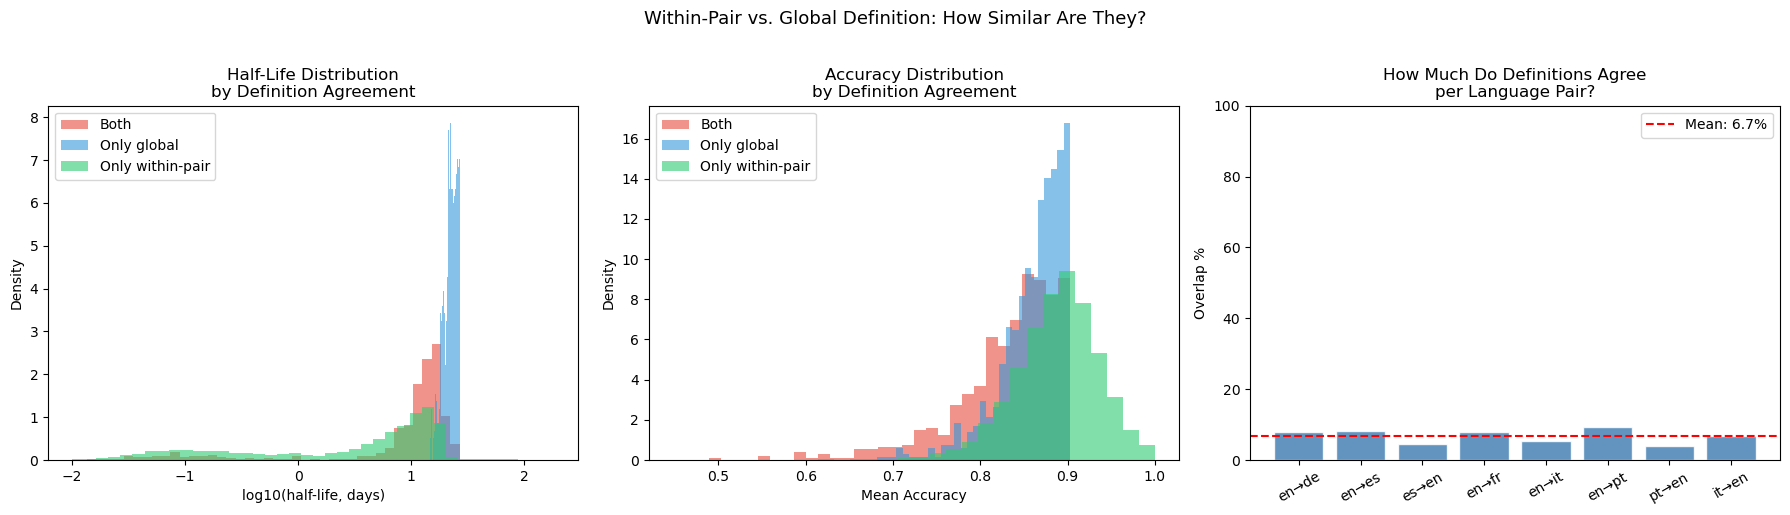

In [ ]:
# --- Global thresholds (same cutoff for everyone) ---
global_hl_thresh  = results_all['half_life_days'].quantile(0.35)
global_acc_thresh = results_all['mean_accuracy'].quantile(0.50)
global_vol_thresh = results_all['n_reviews'].quantile(0.50)
global_gap_thresh = results_all['mean_delta_days'].quantile(0.35)

results_all['struggling_global'] = (
    (results_all['half_life_days'] <= global_hl_thresh) &
    (results_all['mean_accuracy']  <= global_acc_thresh) &
    (results_all['n_reviews']      >= global_vol_thresh) &
    (results_all['mean_delta_days']>= global_gap_thresh)
)

# --- Within-pair thresholds (what we already have) ---
within_pair_struggling = set(df_struggling['user_id'].unique())
results_all['struggling_within'] = results_all['user_id'].isin(within_pair_struggling)

# --- Overlap analysis ---
both      = results_all['struggling_global'] & results_all['struggling_within']
only_global = results_all['struggling_global'] & ~results_all['struggling_within']
only_within = results_all['struggling_within'] & ~results_all['struggling_global']
neither     = ~results_all['struggling_global'] & ~results_all['struggling_within']

print(f"\n{'='*55}")
print(f"Global struggling:       {results_all['struggling_global'].sum():,}")
print(f"Within-pair struggling:  {results_all['struggling_within'].sum():,}")
print(f"In BOTH:                 {both.sum():,} "
      f"({100*both.sum()/results_all['struggling_within'].sum():.1f}% of within-pair)")
print(f"Only in global:          {only_global.sum():,}")
print(f"Only in within-pair:     {only_within.sum():,}")
print(f"{'='*55}")

# Overlap per language pair
print(f"\nOverlap by language pair:")
print(f"{'Pair':<12} {'Within':>8} {'Global':>8} {'Both':>8} {'Overlap%':>10}")
print("-" * 50)
for pair in results_all['pair_label'].dropna().unique():
    mask = results_all['pair_label'] == pair
    w = (results_all.loc[mask, 'struggling_within']).sum()
    g = (results_all.loc[mask, 'struggling_global']).sum()
    b = (results_all.loc[mask, 'struggling_within'] & 
         results_all.loc[mask, 'struggling_global']).sum()
    pct = 100*b/w if w > 0 else 0
    print(f"{pair:<12} {w:>8} {g:>8} {b:>8} {pct:>9.1f}%")

# --- Visual comparison ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Left: half-life distributions for all three groups
axes[0].hist(np.log10(results_all.loc[both, 'half_life_days'].clip(lower=0.01)),
             bins=40, alpha=0.6, density=True, color='#e74c3c', label='Both')
axes[0].hist(np.log10(results_all.loc[only_global, 'half_life_days'].clip(lower=0.01)),
             bins=40, alpha=0.6, density=True, color='#3498db', label='Only global')
axes[0].hist(np.log10(results_all.loc[only_within, 'half_life_days'].clip(lower=0.01)),
             bins=40, alpha=0.6, density=True, color='#2ecc71', label='Only within-pair')
axes[0].set_xlabel('log10(half-life, days)')
axes[0].set_ylabel('Density')
axes[0].set_title('Half-Life Distribution\nby Definition Agreement')
axes[0].legend()

# Middle: accuracy comparison
axes[1].hist(results_all.loc[both, 'mean_accuracy'],
             bins=30, alpha=0.6, density=True, color='#e74c3c', label='Both')
axes[1].hist(results_all.loc[only_global, 'mean_accuracy'],
             bins=30, alpha=0.6, density=True, color='#3498db', label='Only global')
axes[1].hist(results_all.loc[only_within, 'mean_accuracy'],
             bins=30, alpha=0.6, density=True, color='#2ecc71', label='Only within-pair')
axes[1].set_xlabel('Mean Accuracy')
axes[1].set_ylabel('Density')
axes[1].set_title('Accuracy Distribution\nby Definition Agreement')
axes[1].legend()

# Right: per language pair overlap bar chart
pairs = results_all['pair_label'].dropna().unique()
overlap_pcts = []
for pair in pairs:
    mask = results_all['pair_label'] == pair
    w = results_all.loc[mask, 'struggling_within'].sum()
    b = (results_all.loc[mask, 'struggling_within'] & 
         results_all.loc[mask, 'struggling_global']).sum()
    overlap_pcts.append(100*b/w if w > 0 else 0)

bars = axes[2].bar(pairs, overlap_pcts, color='steelblue', 
                   edgecolor='white', alpha=0.85)
axes[2].axhline(np.mean(overlap_pcts), color='red', linestyle='--',
                label=f'Mean: {np.mean(overlap_pcts):.1f}%')
axes[2].set_ylabel('Overlap %')
axes[2].set_title('How Much Do Definitions Agree\nper Language Pair?')
axes[2].tick_params(axis='x', rotation=30)
axes[2].legend()
axes[2].set_ylim(0, 100)

plt.suptitle('Within-Pair vs. Global Definition: How Similar Are They?',
             fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

In [51]:
df = load_and_filter('../datasets/duo_data.csv')
df["user_id"].unique()

Loading dataset...


Original rows:  12,854,226
Filtered rows:  10,014,326 (77.9%)
Eligible users: 42,086

Users per language pair:
ui_language  learning_language
en           de                    5171
             es                   11772
             fr                    6631
             it                    2836
             pt                    1164
es           en                   11928
it           en                    1350
pt           en                    3377


array(['u:dDwF', 'u:g3WM', 'u:dwbJ', ..., 'u:ghJI', 'u:iaS1', 'u:iuUq'],
      shape=(42086,), dtype=object)

In [52]:
df

p_recall   timestamp   delta user_id learning_language ui_language  \
7         1.000000  1362082032  444407  u:dDwF                es          en   
23        1.000000  1362082274  444649  u:dDwF                es          en   
24        1.000000  1362082274  678813  u:dDwF                es          en   
25        1.000000  1362082274  781431  u:dDwF                es          en   
26        1.000000  1362082274  678813  u:dDwF                es          en   
...            ...         ...     ...     ...               ...         ...   
12854221  0.800000  1363104897     368  u:i5D8                en          it   
12854222  0.800000  1363104897     368  u:i5D8                en          it   
12854223  1.000000  1363104897     368  u:i5D8                en          it   
12854224  0.600000  1363104897     368  u:i5D8                en          it   
12854225  0.666667  1363104897     368  u:i5D8                en          it   

                                 lexeme_id  \
7         73eecb492ca758ddab5371cf7b5cca32   
23        4bdb859f599fa07dd5eecdab0acc2d34   
24        faa6fd18132b358958e440322ee82b4b   
25        41ba24ffb11fd09f5fc715d39cc6c1ea   
26        64f2b1bdc5c91bb3f6ca1bb7a808b60a   
...                                    ...   
12854221  d5efc552aaea3109eb5388aa1ec8673d   
12854222  a826c47947d68549fa81e19cafa57ba0   
12854223  5e29d77697d23070a1fb92eb6c90e9b6   
12854224  cdfecc9247566d40bb964a218c54c783   
12854225  c52ab45d4e22ee7580041911159e3c0c   

                               lexeme_string  history_seen  history_correct  \
7                              bajo/bajo<pr>             3                3   
23                                   a/a<pr>             3                3   
24              lee/leer<vblex><pri><p3><sg>             9                9   
25                  qué/qué<prn><itg><m><sg>             3                3   
26        quieres/querer<vblex><pri><p2><sg>             3                3   
...                                      ...           ...              ...   
12854221               the/the<det><def><sp>             6                4   
12854222                eat/eat<vblex><pres>             4                4   
12854223                  bread/bread<n><sg>             4                4   
12854224            drink/drink<vblex><pres>             3                2   
12854225                  water/water<n><sg>             5                3   

          ...     pos_label               tense      person  \
7         ...   preposition                 NaN         NaN   
23        ...   preposition                 NaN         NaN   
24        ...  verb_lexical  present_indicative  3rd_person   
25        ...       pronoun                 NaN         NaN   
26        ...  verb_lexical  present_indicative  2nd_person   
...       ...           ...                 ...         ...   
12854221  ...    determiner                 NaN         NaN   
12854222  ...  verb_lexical             present         NaN   
12854223  ...          noun                 NaN         NaN   
12854224  ...  verb_lexical             present         NaN   
12854225  ...          noun                 NaN         NaN   

                      number     gender case   definiteness degree  \
7                        NaN        NaN  NaN            NaN    NaN   
23                       NaN        NaN  NaN            NaN    NaN   
24                  singular        NaN  NaN            NaN    NaN   
25                  singular  masculine  NaN  interrogative    NaN   
26                  singular        NaN  NaN            NaN    NaN   
...                      ...        ...  ...            ...    ...   
12854221  singular_or_plural        NaN  NaN       definite    NaN   
12854222                 NaN        NaN  NaN            NaN    NaN   
12854223            singular        NaN  NaN            NaN    NaN   
12854224                 NaN        NaN  NaN            NaN    NaN   
12854225            

In [41]:
results_all

user_id     half_life  half_life_days  n_reviews  mean_p_recall  \
0       u:-4V  1.359892e+06       15.739487         81       0.888889   
1       u:-4y  1.443395e+06       16.705965         51       0.955191   
2       u:-7F  1.753327e+06       20.293136        258       0.667313   
3       u:-AK  4.137176e+06       47.883985        383       0.908094   
4       u:-DF  4.504567e+06       52.136197        559       0.894743   
...       ...           ...             ...        ...            ...   
42081   u:zu0  3.545320e+06       41.033798         73       0.835616   
42082   u:zv5  6.416677e+06       74.267095         65       0.884615   
42083   u:zz3  6.319305e+06       73.140105        119       0.965266   
42084   u:zz8  6.712647e+06       77.692674        151       0.888962   
42085   u:zzv  2.560074e+06       29.630484        120       0.963699   

       mean_accuracy  mean_delta_days pair_label  struggling_global  \
0           0.928806         0.144176      en→de              False   
1           0.922811         0.714933      en→es              False   
2           0.812915         5.009946      en→es               True   
3           0.927594         1.586790      es→en              False   
4           0.932733         3.644012      es→en              False   
...              ...              ...        ...                ...   
42081       0.831520         3.585992      es→en              False   
42082       0.884402         4.785909      en→es              False   
42083       0.936309         1.071583      en→de              False   
42084       0.905726         3.887053      en→fr              False   
42085       0.869309         0.518406      en→it              False   

       struggling_within  
0                   True  
1                   True  
2                   True  
3                  False  
4                  False  
...                  ...  
42081              False  
42082              False  
42083              False  
42084              False  
42085              False  

[42086 rows x 10 columns]

Loaded 500 learners across 4 clusters
cluster_name
Solid Performers              282
Struggling Learners           146
Disengaged Fast Forgetters     60
Natural Learners               12
Name: count, dtype: int64

Saved: cluster_main.png
Saved: cluster_pie.png
Saved: cluster_radar.png

✅ All cluster visualizations saved!


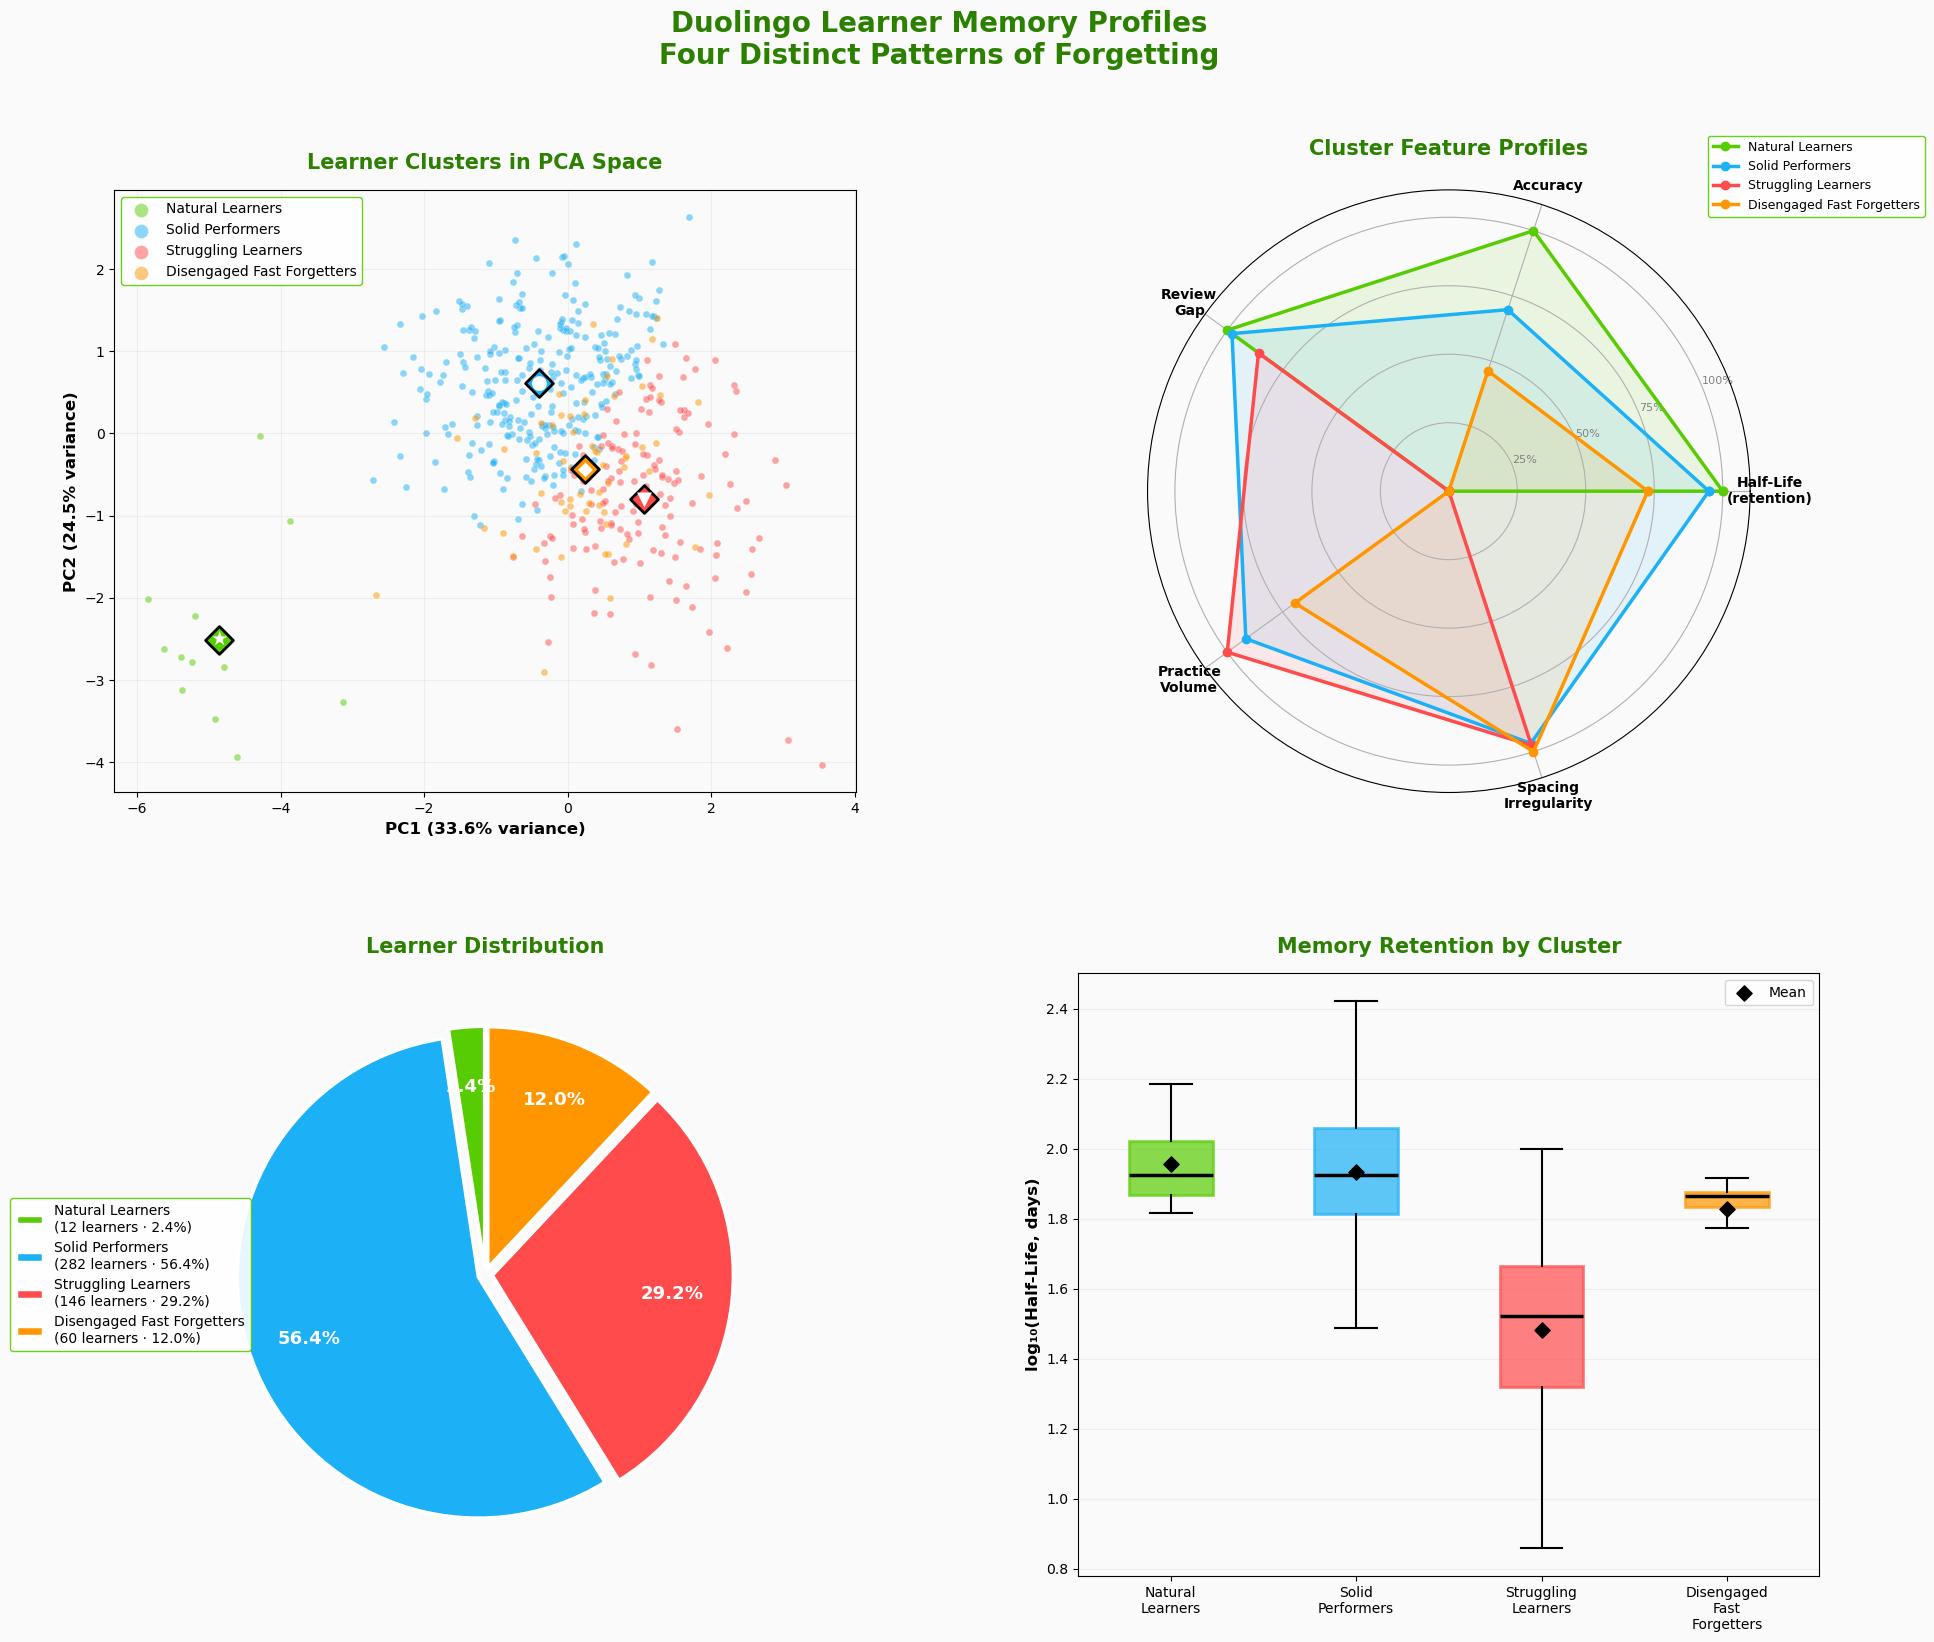

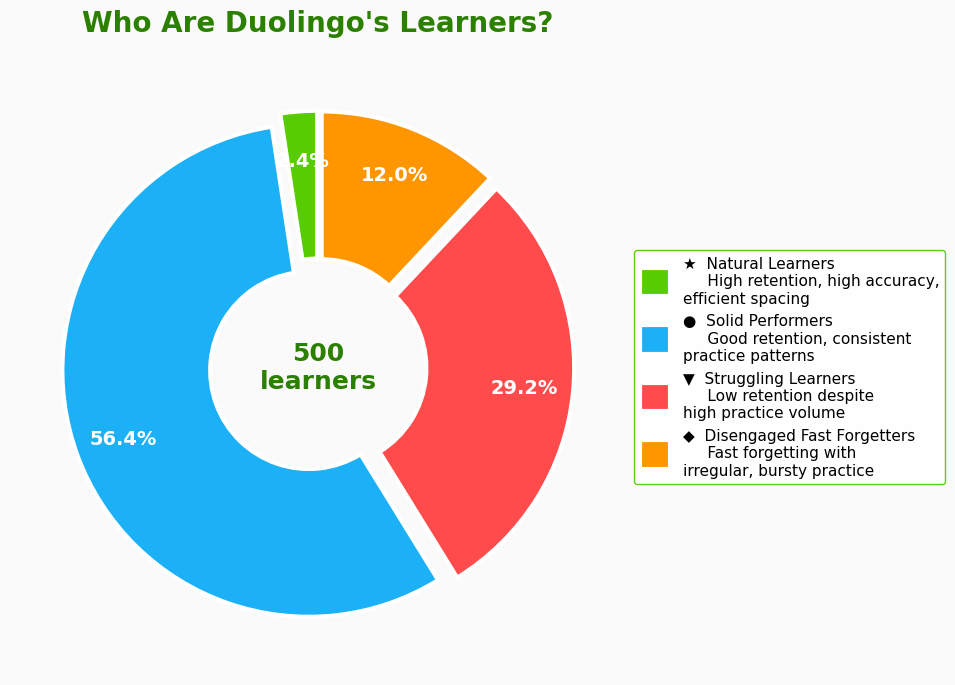

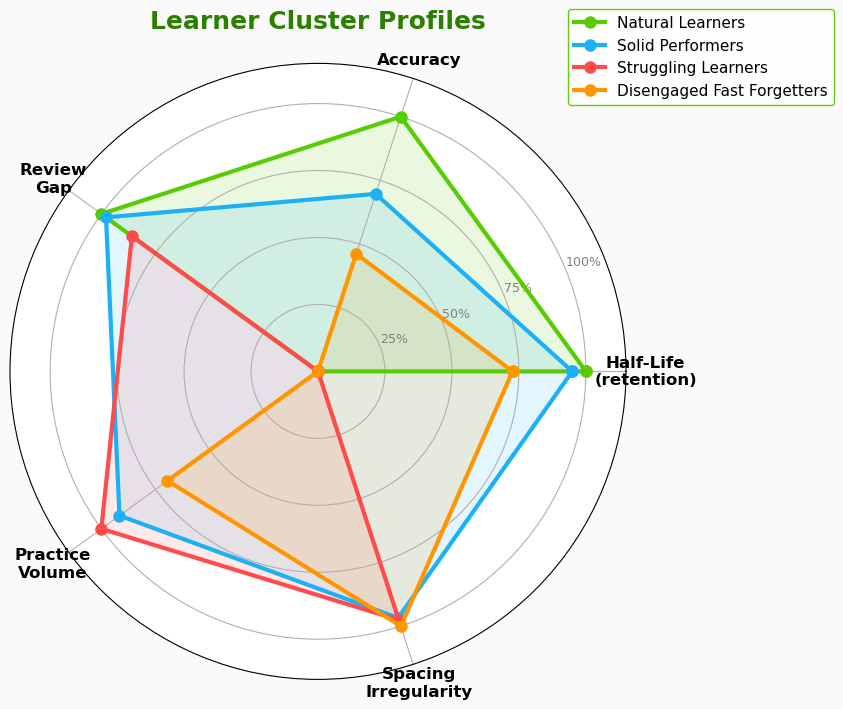

In [42]:
"""
==============================================================================
Learner Cluster Visualizations — Duolingo Theme
==============================================================================

Run locally after running ideas.py (needs features_clustered DataFrame).

Usage:
    # After running clustering in ideas.py, add this at the bottom:
    exec(open('cluster_visualizations.py').read())
    
    # OR: save features_clustered to CSV and load here:
    # features_clustered = pd.read_csv('features_clustered.csv')

Produces:
    cluster_main.png     — 4-panel: PCA scatter, radar, pie, boxplots
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import FancyBboxPatch
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# DUOLINGO COLOR PALETTE
# =============================================================================

# Duolingo's brand green and complementary colors
DUO_GREEN = '#58CC02'       # Primary Duolingo green
DUO_GREEN_DARK = '#2B8000'  # Darker green
DUO_BG = '#FAFAFA'          # Light background

# Cluster colors — themed but distinct
CLUSTER_COLORS = {
    'Natural Learners':           '#58CC02',  # Duolingo green — the best learners
    'Solid Performers':           '#1CB0F6',  # Duolingo blue
    'Struggling Learners':        '#FF4B4B',  # Duolingo red
    'Disengaged Fast Forgetters': '#FF9600',  # Duolingo orange
}

CLUSTER_ORDER = ['Natural Learners', 'Solid Performers',
                 'Struggling Learners', 'Disengaged Fast Forgetters']

CLUSTER_ICONS = {
    'Natural Learners':           '★',
    'Solid Performers':           '●',
    'Struggling Learners':        '▼',
    'Disengaged Fast Forgetters': '◆',
}

CLUSTER_DESCRIPTIONS = {
    'Natural Learners':           'High retention, high accuracy,\nefficient spacing',
    'Solid Performers':           'Good retention, consistent\npractice patterns',
    'Struggling Learners':        'Low retention despite\nhigh practice volume',
    'Disengaged Fast Forgetters': 'Fast forgetting with\nirregular, bursty practice',
}


# =============================================================================
# LOAD DATA (adapt path as needed)
# =============================================================================

# Option 1: If features_clustered is already in memory (from ideas.py), skip this.
# Option 2: Load from CSV:
# features_clustered = pd.read_csv('features_clustered.csv')

# Check that cluster_name exists
if 'cluster_name' not in features_clustered.columns:
    cluster_names = {
        0.0: 'Disengaged Fast Forgetters',
        1.0: 'Struggling Learners',
        2.0: 'Solid Performers',
        3.0: 'Natural Learners'
    }
    features_clustered['cluster_name'] = features_clustered['cluster'].map(cluster_names)

df = features_clustered.dropna(subset=['cluster_name']).copy()
print(f"Loaded {len(df):,} learners across {df['cluster_name'].nunique()} clusters")
print(df['cluster_name'].value_counts())


# =============================================================================
# FIGURE: MAIN 4-PANEL VISUALIZATION
# =============================================================================

fig = plt.figure(figsize=(22, 18), facecolor=DUO_BG)
gs = gridspec.GridSpec(2, 2, figure=fig, hspace=0.3, wspace=0.3)

# ---- (A) PCA SCATTER WITH CLUSTER SEPARATION ----
ax = fig.add_subplot(gs[0, 0], facecolor=DUO_BG)

cluster_feats = ['log_h', 'mean_accuracy', 'log_mean_delta',
                 'log_n_reviews', 'log_cv_delta']
X = df[cluster_feats].fillna(0).values
X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

for cluster in CLUSTER_ORDER:
    mask = df['cluster_name'].values == cluster
    if mask.sum() > 0:
        ax.scatter(X_pca[mask, 0], X_pca[mask, 1],
                   c=CLUSTER_COLORS[cluster], label=cluster,
                   alpha=0.5, s=25, edgecolors='white', linewidth=0.3)

# Add cluster centroids
for cluster in CLUSTER_ORDER:
    mask = df['cluster_name'].values == cluster
    if mask.sum() > 0:
        cx, cy = X_pca[mask, 0].mean(), X_pca[mask, 1].mean()
        ax.scatter(cx, cy, c=CLUSTER_COLORS[cluster],
                   s=200, edgecolors='black', linewidth=2, zorder=10, marker='D')
        ax.annotate(CLUSTER_ICONS[cluster], (cx, cy),
                    fontsize=14, ha='center', va='center',
                    fontweight='bold', color='white', zorder=11)

ev1 = pca.explained_variance_ratio_[0]
ev2 = pca.explained_variance_ratio_[1]
ax.set_xlabel(f'PC1 ({ev1:.1%} variance)', fontsize=12, fontweight='bold')
ax.set_ylabel(f'PC2 ({ev2:.1%} variance)', fontsize=12, fontweight='bold')
ax.set_title('Learner Clusters in PCA Space', fontsize=15, fontweight='bold',
             color=DUO_GREEN_DARK, pad=15)
ax.legend(fontsize=10, framealpha=0.9, edgecolor=DUO_GREEN,
          loc='best', markerscale=2)
ax.grid(True, alpha=0.15)


# ---- (B) RADAR / SPIDER CHART ----
ax_radar = fig.add_subplot(gs[0, 1], polar=True, facecolor=DUO_BG)

radar_feats = ['log_h', 'mean_accuracy', 'log_mean_delta',
               'log_n_reviews', 'log_cv_delta']
radar_labels = ['Half-Life\n(retention)', 'Accuracy', 'Review\nGap',
                'Practice\nVolume', 'Spacing\nIrregularity']

# Normalize each feature to 0-1 across clusters
cluster_means = df.groupby('cluster_name')[radar_feats].mean()
cluster_norm = (cluster_means - cluster_means.min()) / \
               (cluster_means.max() - cluster_means.min())

angles = np.linspace(0, 2 * np.pi, len(radar_feats), endpoint=False).tolist()
angles += angles[:1]

for cluster in CLUSTER_ORDER:
    if cluster in cluster_norm.index:
        values = cluster_norm.loc[cluster].tolist()
        values += values[:1]
        ax_radar.plot(angles, values, 'o-', linewidth=2.5,
                      color=CLUSTER_COLORS[cluster], label=cluster,
                      markersize=6)
        ax_radar.fill(angles, values, alpha=0.1, color=CLUSTER_COLORS[cluster])

ax_radar.set_xticks(angles[:-1])
ax_radar.set_xticklabels(radar_labels, fontsize=10, fontweight='bold')
ax_radar.set_ylim(0, 1.1)
ax_radar.set_yticks([0.25, 0.5, 0.75, 1.0])
ax_radar.set_yticklabels(['25%', '50%', '75%', '100%'], fontsize=8, color='gray')
ax_radar.set_title('Cluster Feature Profiles', fontsize=15, fontweight='bold',
                   color=DUO_GREEN_DARK, pad=25)
ax_radar.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=9,
                framealpha=0.9, edgecolor=DUO_GREEN)


# ---- (C) PIE CHART WITH PERCENTAGES ----
ax_pie = fig.add_subplot(gs[1, 0], facecolor=DUO_BG)

counts = df['cluster_name'].value_counts()
# Reorder to match CLUSTER_ORDER
sizes = [counts.get(c, 0) for c in CLUSTER_ORDER]
colors = [CLUSTER_COLORS[c] for c in CLUSTER_ORDER]
total = sum(sizes)
labels = [f'{c}\n({s:,} learners · {100*s/total:.1f}%)'
          for c, s in zip(CLUSTER_ORDER, sizes)]

explode = [0.03] * len(CLUSTER_ORDER)

wedges, texts, autotexts = ax_pie.pie(
    sizes, labels=None, colors=colors, autopct='%1.1f%%',
    startangle=90, explode=explode,
    pctdistance=0.75,
    wedgeprops=dict(edgecolor='white', linewidth=2.5),
    textprops=dict(fontsize=12, fontweight='bold'),
)

# Style the percentage text
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(13)

# Add legend instead of labels for cleaner look
ax_pie.legend(wedges, labels, loc='center left', bbox_to_anchor=(-0.3, 0.5),
              fontsize=10, framealpha=0.9, edgecolor=DUO_GREEN)
ax_pie.set_title('Learner Distribution', fontsize=15, fontweight='bold',
                 color=DUO_GREEN_DARK, pad=15)


# ---- (D) BOXPLOTS: KEY METRICS BY CLUSTER ----
ax_box = fig.add_subplot(gs[1, 1], facecolor=DUO_BG)

# Show half-life distribution per cluster (the key metric)
box_data = [df[df['cluster_name'] == c]['log_h'].dropna().values
            for c in CLUSTER_ORDER]

bp = ax_box.boxplot(box_data,
                    labels=[c.replace(' ', '\n') for c in CLUSTER_ORDER],
                    patch_artist=True, showfliers=False,
                    medianprops=dict(color='black', linewidth=2.5),
                    whiskerprops=dict(linewidth=1.5),
                    capprops=dict(linewidth=1.5))

for patch, cluster in zip(bp['boxes'], CLUSTER_ORDER):
    patch.set_facecolor(CLUSTER_COLORS[cluster])
    patch.set_alpha(0.7)
    patch.set_edgecolor(CLUSTER_COLORS[cluster])
    patch.set_linewidth(2)

# Add means as diamonds
means = [np.mean(d) for d in box_data]
ax_box.scatter(range(1, len(means) + 1), means,
               marker='D', color='black', s=60, zorder=5, label='Mean')

ax_box.set_ylabel('log₁₀(Half-Life, days)', fontsize=12, fontweight='bold')
ax_box.set_title('Memory Retention by Cluster', fontsize=15, fontweight='bold',
                 color=DUO_GREEN_DARK, pad=15)
ax_box.grid(True, alpha=0.15, axis='y')
ax_box.legend(fontsize=10)
ax_box.tick_params(axis='x', labelsize=10)


# ---- MAIN TITLE ----
fig.suptitle('Duolingo Learner Memory Profiles\n'
             'Four Distinct Patterns of Forgetting',
             fontsize=20, fontweight='bold', color=DUO_GREEN_DARK, y=0.98)

plt.savefig('cluster_main.png', dpi=150, bbox_inches='tight',
            facecolor=DUO_BG)
print("\nSaved: cluster_main.png")


# =============================================================================
# BONUS: STANDALONE PIE CHART (cleaner for slides)
# =============================================================================

fig2, ax2 = plt.subplots(figsize=(10, 8), facecolor=DUO_BG)

wedges2, texts2, autotexts2 = ax2.pie(
    sizes, labels=None, colors=colors, autopct='%1.1f%%',
    startangle=90, explode=[0.04] * len(CLUSTER_ORDER),
    pctdistance=0.8,
    wedgeprops=dict(edgecolor='white', linewidth=3, width=0.6),  # donut style
    textprops=dict(fontsize=14, fontweight='bold'),
)

for autotext in autotexts2:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(14)

# Center text
ax2.text(0, 0, f'{total:,}\nlearners', ha='center', va='center',
         fontsize=18, fontweight='bold', color=DUO_GREEN_DARK)

# Legend with descriptions
legend_labels = [f'{CLUSTER_ICONS[c]}  {c}\n     {CLUSTER_DESCRIPTIONS[c]}'
                 for c in CLUSTER_ORDER]
ax2.legend(wedges2, legend_labels, loc='center left', bbox_to_anchor=(1, 0.5),
           fontsize=11, framealpha=0.95, edgecolor=DUO_GREEN,
           handlelength=2, handleheight=2.5)

ax2.set_title('Who Are Duolingo\'s Learners?',
              fontsize=20, fontweight='bold', color=DUO_GREEN_DARK, pad=20)

plt.savefig('cluster_pie.png', dpi=150, bbox_inches='tight', facecolor=DUO_BG)
print("Saved: cluster_pie.png")


# =============================================================================
# BONUS: STANDALONE RADAR (for slides)
# =============================================================================

fig3, ax3 = plt.subplots(figsize=(10, 8), subplot_kw=dict(polar=True),
                          facecolor=DUO_BG)

for cluster in CLUSTER_ORDER:
    if cluster in cluster_norm.index:
        values = cluster_norm.loc[cluster].tolist()
        values += values[:1]
        ax3.plot(angles, values, 'o-', linewidth=3,
                 color=CLUSTER_COLORS[cluster], label=cluster,
                 markersize=8)
        ax3.fill(angles, values, alpha=0.12, color=CLUSTER_COLORS[cluster])

ax3.set_xticks(angles[:-1])
ax3.set_xticklabels(radar_labels, fontsize=12, fontweight='bold')
ax3.set_ylim(0, 1.15)
ax3.set_yticks([0.25, 0.5, 0.75, 1.0])
ax3.set_yticklabels(['25%', '50%', '75%', '100%'], fontsize=9, color='gray')
ax3.legend(loc='upper right', bbox_to_anchor=(1.35, 1.1), fontsize=11,
           framealpha=0.95, edgecolor=DUO_GREEN)
ax3.set_title('Learner Cluster Profiles',
              fontsize=18, fontweight='bold', color=DUO_GREEN_DARK, pad=25)

plt.savefig('cluster_radar.png', dpi=150, bbox_inches='tight', facecolor=DUO_BG)
print("Saved: cluster_radar.png")

print("\n✅ All cluster visualizations saved!")


Loading dataset...
Original rows:  12,854,226
Filtered rows:  10,014,326 (77.9%)
Eligible users: 42,086

Users per language pair:
ui_language  learning_language
en           de                    5171
             es                   11772
             fr                    6631
             it                    2836
             pt                    1164
es           en                   11928
it           en                    1350
pt           en                    3377
Fitting per-learner half-life...
Successfully fit: 42,086 users

Half-life summary (days):
count    42086.0
mean        50.1
std         43.5
min          0.0
25%         18.2
50%         40.3
75%         70.2
max        368.0
Name: half_life_days, dtype: float64
Clustering on 42086 learners with features: ['log_h', 'mean_accuracy', 'log_mean_delta', 'log_n_reviews', 'log_cv_delta']

Cluster profiles:
         log_h  mean_accuracy  log_mean_delta  log_n_reviews  log_cv_delta  \
cluster                             

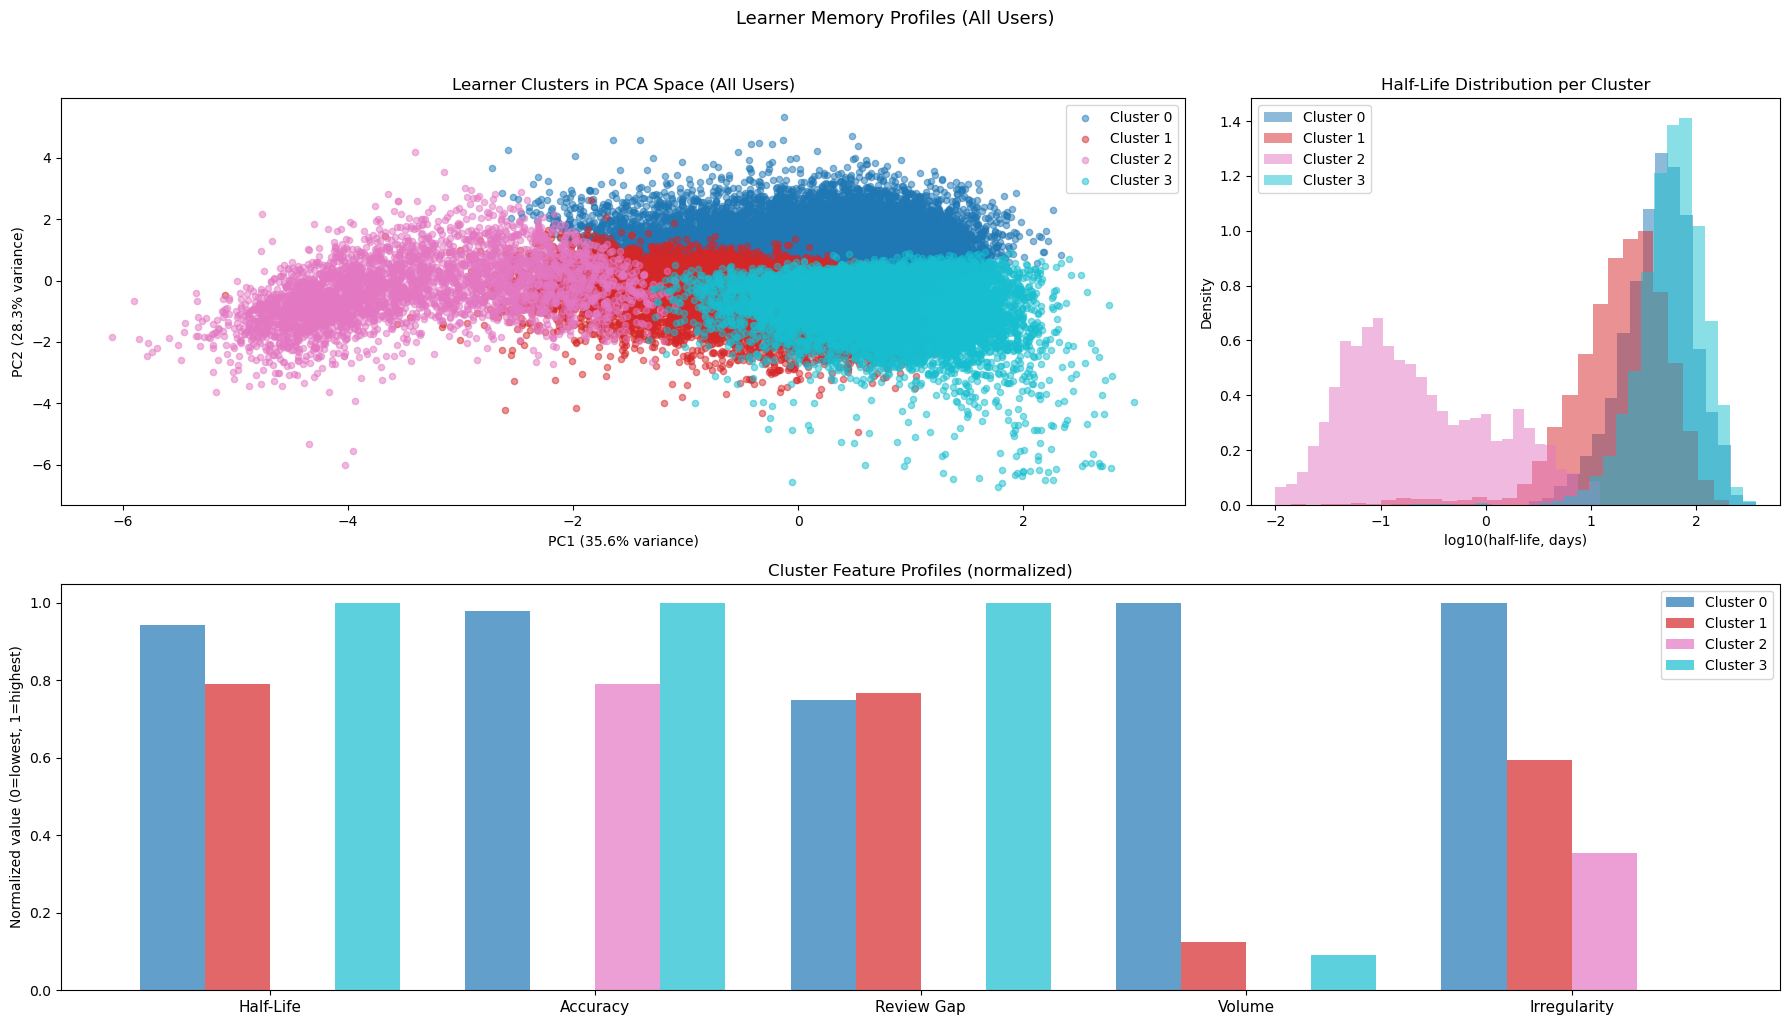

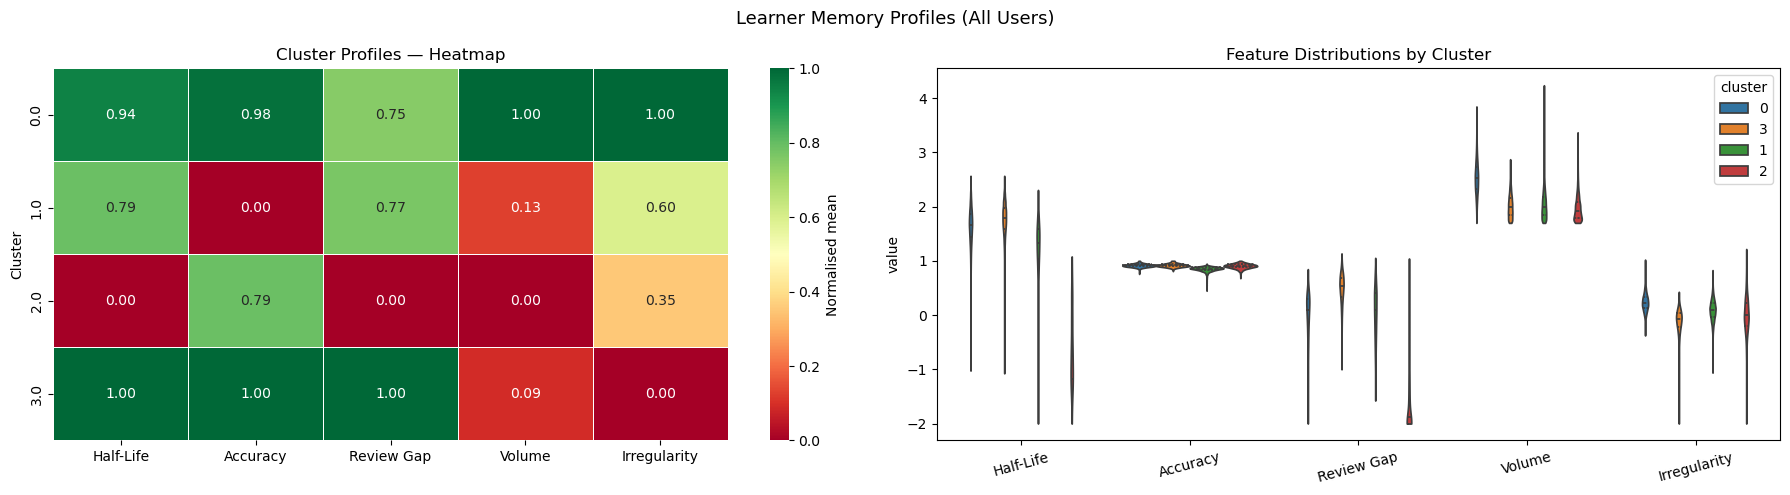

ValueError: too many values to unpack (expected 3)

In [ ]:
# =============================================================================
# SHORTEST PATH TO GET km — NO LANGUAGE PAIR FILTERING
# =============================================================================

# Step 1: Load full dataset
df_filtered = load_and_filter('../datasets/duo_data.csv')

# Step 2: Fit naive half-life on ALL users
results_naive = fit_naive_halflife(df_filtered)
results_naive['h_hierarchical'] = results_naive['half_life_days']
results_naive['log_h'] = np.log10(results_naive['half_life_days'].clip(lower=0.01))

# Step 3: Engineer features for ALL users
user_features = []
for user_id, udf in df_filtered.groupby('user_id'):
    delta_vals = udf['delta'].values
    mean_delta = delta_vals.mean()
    user_features.append({
        'user_id':        user_id,
        'mean_accuracy':  (udf['history_correct'] /
                          udf['history_seen'].clip(lower=1)).mean(),
        'log_mean_delta': np.log10(max(mean_delta / 86400, 0.01)),
        'log_cv_delta':   np.log10(max(
                              delta_vals.std() / mean_delta
                              if mean_delta > 0 else 0.01, 0.01)),
        'log_n_reviews':  np.log10(len(udf)),
    })

features_df = pd.DataFrame(user_features)
features_enriched = results_naive.merge(features_df, on='user_id', how='left')

# Step 4: Cluster on ALL users
X_scaled, valid_idx, cluster_feats, scaler = prepare_clustering_features(
    features_enriched)



In [57]:
def fit_and_profile_clusters(features_enriched, X_scaled, valid_idx,
                              cluster_feats, k, title_suffix=''):
    """
    Fit KMeans with k clusters, profile each cluster, and visualize.

    Returns
    -------
    features_enriched : DataFrame with 'cluster' and 'cluster_name' columns
    km                : fitted KMeans model  ← NEW
    cluster_feats     : feature list         ← NEW
    """
    cluster_names = {
        0: 'Disengaged Fast Forgetters',
        1: 'Struggling Learners',
        2: 'Solid Performers',
        3: 'Natural Learners'
    }

    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = km.fit_predict(X_scaled)

    features_enriched = features_enriched.copy()
    features_enriched.loc[valid_idx, 'cluster'] = labels
    features_enriched['cluster_name'] = (
        features_enriched['cluster'].map(cluster_names)
    )

    # --- Profile ---
    profile_feats = ['log_h', 'mean_accuracy', 'log_mean_delta',
                     'log_n_reviews', 'log_cv_delta', 'h_hierarchical']
    available = [f for f in profile_feats if f in features_enriched.columns]

    print("\nCluster profiles:")
    print(features_enriched.groupby('cluster_name')[available].mean().round(3))
    print("\nCluster sizes:")
    print(features_enriched['cluster_name'].value_counts())

    # --- PCA ---
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X_scaled)
    var_explained = pca.explained_variance_ratio_
    colors = plt.cm.tab10(np.linspace(0, 1, k))

    fig = plt.figure(figsize=(18, 10))
    gs = gridspec.GridSpec(2, 3, figure=fig)

    ax_pca = fig.add_subplot(gs[0, :2])
    for i in range(k):
        mask = labels == i
        label = cluster_names.get(i, f'Cluster {i}')
        ax_pca.scatter(X_pca[mask, 0], X_pca[mask, 1],
                       color=colors[i], alpha=0.5, s=20, label=label)
    ax_pca.set_xlabel(f'PC1 ({var_explained[0]:.1%} variance)')
    ax_pca.set_ylabel(f'PC2 ({var_explained[1]:.1%} variance)')
    ax_pca.set_title(f'Learner Clusters in PCA Space {title_suffix}')
    ax_pca.legend()

    ax_hl = fig.add_subplot(gs[0, 2])
    for i in range(k):
        data = features_enriched[
            features_enriched['cluster'] == i]['log_h'].dropna()
        label = cluster_names.get(i, f'Cluster {i}')
        ax_hl.hist(data, bins=30, alpha=0.5, color=colors[i],
                   label=label, density=True)
    ax_hl.set_xlabel('log10(half-life, days)')
    ax_hl.set_ylabel('Density')
    ax_hl.set_title('Half-Life Distribution per Cluster')
    ax_hl.legend(fontsize=8)

    feat_display = ['log_h', 'mean_accuracy', 'log_mean_delta',
                    'log_n_reviews', 'log_cv_delta']
    feat_labels_display = ['Half-Life', 'Accuracy', 'Review Gap',
                           'Volume', 'Irregularity']
    cluster_means = features_enriched.groupby('cluster')[feat_display].mean()
    cluster_norm  = (cluster_means - cluster_means.min()) / \
                    (cluster_means.max() - cluster_means.min())

    ax_bar = fig.add_subplot(gs[1, :])
    x = np.arange(len(feat_display))
    width = 0.8 / k
    for i in range(k):
        label = cluster_names.get(i, f'Cluster {i}')
        ax_bar.bar(x + i * width, cluster_norm.iloc[i],
                   width=width, color=colors[i], alpha=0.7, label=label)
    ax_bar.set_xticks(x + width * (k-1) / 2)
    ax_bar.set_xticklabels(feat_labels_display, fontsize=11)
    ax_bar.set_ylabel('Normalized value (0=lowest, 1=highest)')
    ax_bar.set_title('Cluster Feature Profiles (normalized)')
    ax_bar.legend()

    plt.suptitle(f'Learner Memory Profiles {title_suffix}', fontsize=13, y=1.02)
    plt.tight_layout()
    plt.show()

    return features_enriched, km, cluster_feats  # ← returns 3 values now


Cluster profiles:
                            log_h  mean_accuracy  log_mean_delta  \
cluster_name                                                       
Disengaged Fast Forgetters  1.626          0.915           0.012   
Natural Learners            1.760          0.916           0.490   
Solid Performers           -0.629          0.903          -1.414   
Struggling Learners         1.259          0.850           0.047   

                            log_n_reviews  log_cv_delta  h_hierarchical  
cluster_name                                                             
Disengaged Fast Forgetters          2.540         0.235          55.851  
Natural Learners                    2.015        -0.118          71.434  
Solid Performers                    1.963         0.007           0.857  
Struggling Learners                 2.035         0.092          27.982  

Cluster sizes:
cluster_name
Natural Learners              14406
Disengaged Fast Forgetters    14362
Struggling Learners        

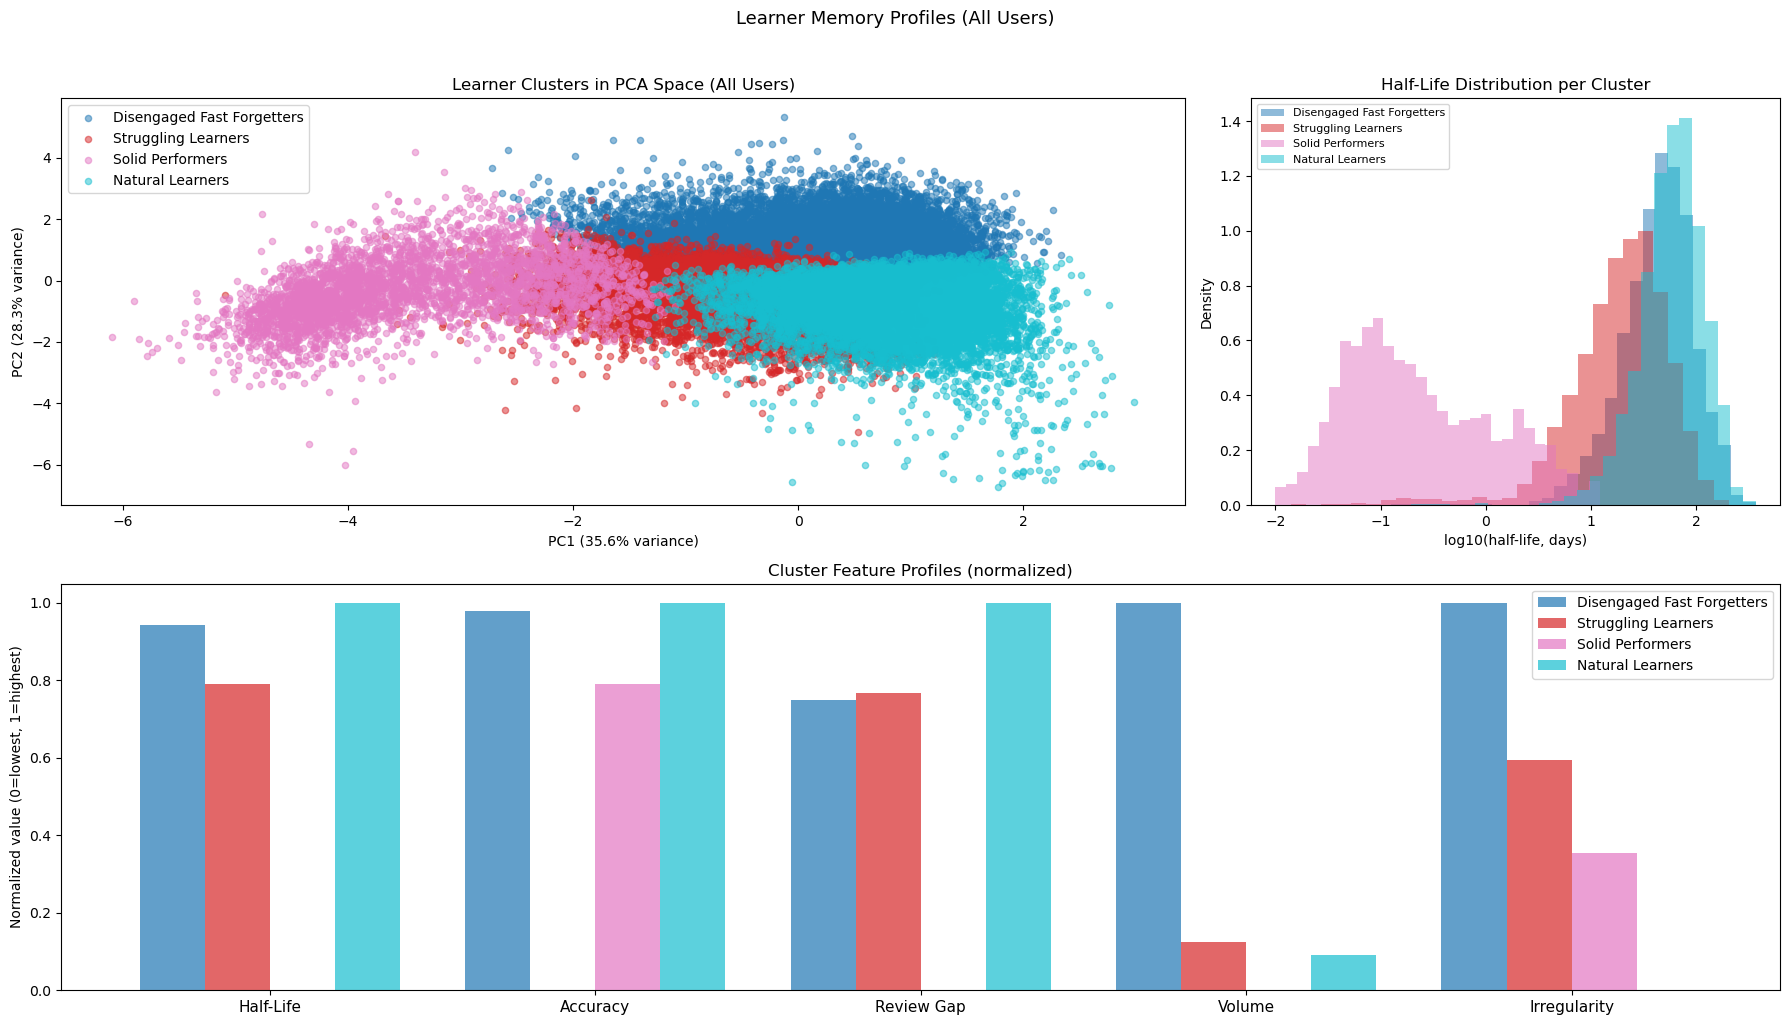

cluster_name
Natural Learners              14406
Disengaged Fast Forgetters    14362
Struggling Learners            9863
Solid Performers               3455
Name: count, dtype: int64


In [58]:
features_clustered, km, cluster_feats = fit_and_profile_clusters(
    features_enriched, X_scaled, valid_idx,
    cluster_feats, k=4, title_suffix='(All Users)')

cluster_names = {
    0.0: 'Disengaged Fast Forgetters',
    1.0: 'Struggling Learners',
    2.0: 'Solid Performers',
    3.0: 'Natural Learners'
}
features_clustered['cluster_name'] = features_clustered['cluster'].map(cluster_names)
print(features_clustered['cluster_name'].value_counts())

In [60]:
features_clustered.to_csv('../datasets/features_clustered_all_users.csv', index=False)

In [61]:
df_filtered_with_clusters = df_filtered.merge(
    features_clustered[['user_id', 'cluster', 'cluster_name']],
    on='user_id',
    how='left'  # keep all rows, users without cluster get NaN
)

# Check result
print(f"Total rows: {len(df_filtered_with_clusters):,}")
print(f"\nCluster distribution:")
print(df_filtered_with_clusters['cluster_name'].value_counts())
print(f"\nUsers with no cluster assigned: "
      f"{df_filtered_with_clusters['cluster_name'].isna().sum():,}")

print(df_filtered_with_clusters[['user_id', 'cluster', 'cluster_name']].head(10))

Total rows: 10,014,326

Cluster distribution:
cluster_name
Disengaged Fast Forgetters    6617294
Natural Learners              1697248
Struggling Learners           1331581
Solid Performers               368203
Name: count, dtype: int64

Users with no cluster assigned: 0
  user_id  cluster      cluster_name
0  u:dDwF      3.0  Natural Learners
1  u:dDwF      3.0  Natural Learners
2  u:dDwF      3.0  Natural Learners
3  u:dDwF      3.0  Natural Learners
4  u:dDwF      3.0  Natural Learners
5  u:dDwF      3.0  Natural Learners
6  u:dDwF      3.0  Natural Learners
7  u:dDwF      3.0  Natural Learners
8  u:dDwF      3.0  Natural Learners
9  u:dDwF      3.0  Natural Learners


In [63]:
df_filtered_with_clusters

p_recall   timestamp   delta user_id learning_language ui_language  \
0         1.000000  1362082032  444407  u:dDwF                es          en   
1         1.000000  1362082274  444649  u:dDwF                es          en   
2         1.000000  1362082274  678813  u:dDwF                es          en   
3         1.000000  1362082274  781431  u:dDwF                es          en   
4         1.000000  1362082274  678813  u:dDwF                es          en   
...            ...         ...     ...     ...               ...         ...   
10014321  0.800000  1363104897     368  u:i5D8                en          it   
10014322  0.800000  1363104897     368  u:i5D8                en          it   
10014323  1.000000  1363104897     368  u:i5D8                en          it   
10014324  0.600000  1363104897     368  u:i5D8                en          it   
10014325  0.666667  1363104897     368  u:i5D8                en          it   

                                 lexeme_id  \
0         73eecb492ca758ddab5371cf7b5cca32   
1         4bdb859f599fa07dd5eecdab0acc2d34   
2         faa6fd18132b358958e440322ee82b4b   
3         41ba24ffb11fd09f5fc715d39cc6c1ea   
4         64f2b1bdc5c91bb3f6ca1bb7a808b60a   
...                                    ...   
10014321  d5efc552aaea3109eb5388aa1ec8673d   
10014322  a826c47947d68549fa81e19cafa57ba0   
10014323  5e29d77697d23070a1fb92eb6c90e9b6   
10014324  cdfecc9247566d40bb964a218c54c783   
10014325  c52ab45d4e22ee7580041911159e3c0c   

                               lexeme_string  history_seen  history_correct  \
0                              bajo/bajo<pr>             3                3   
1                                    a/a<pr>             3                3   
2               lee/leer<vblex><pri><p3><sg>             9                9   
3                   qué/qué<prn><itg><m><sg>             3                3   
4         quieres/querer<vblex><pri><p2><sg>             3                3   
...                                      ...           ...              ...   
10014321               the/the<det><def><sp>             6                4   
10014322                eat/eat<vblex><pres>             4                4   
10014323                  bread/bread<n><sg>             4                4   
10014324            drink/drink<vblex><pres>             3                2   
10014325                  water/water<n><sg>             5                3   

          ...      person              number     gender case   definiteness  \
0         ...         NaN                 NaN        NaN  NaN            NaN   
1         ...         NaN                 NaN        NaN  NaN            NaN   
2         ...  3rd_person            singular        NaN  NaN            NaN   
3         ...         NaN            singular  masculine  NaN  interrogative   
4         ...  2nd_person            singular        NaN  NaN            NaN   
...       ...         ...                 ...        ...  ...            ...   
10014321  ...         NaN  singular_or_plural        NaN  NaN       definite   
10014322  ...         NaN                 NaN        NaN  NaN            NaN   
10014323  ...         NaN            singular        NaN  NaN            NaN   
10014324  ...         NaN                 NaN        NaN  NaN            NaN   
10014325  ...         NaN            singular        NaN  NaN            NaN   

         degree pronoun_type adj_declension cluster         cluster_name  
0           NaN          NaN            NaN     3.0     Natural Learners  
1           NaN          NaN            NaN     3.0     Natural Learners  
2           NaN          NaN            NaN     3.0     Natural Learners  
3           NaN          NaN            NaN     3.0     Natural Learners  
4           NaN          NaN            NaN     3.0     Natural Learners  
...         ...          ...            ...     ...                  ...  
10014321    NaN          NaN            NaN     1.0  Struggli

In [62]:
unassigned = df_filtered_with_clusters[
    df_filtered_with_clusters['cluster_name'].isna()
]['user_id'].nunique()

total = df_filtered_with_clusters['user_id'].nunique()
print(f"Unassigned users: {unassigned:,} ({100*unassigned/total:.1f}%)")

# Save
df_filtered_with_clusters.to_csv('full_dataset_with_clusters.csv', index=False)
print("Saved: full_dataset_with_clusters.csv")

Unassigned users: 0 (0.0%)
Saved: full_dataset_with_clusters.csv


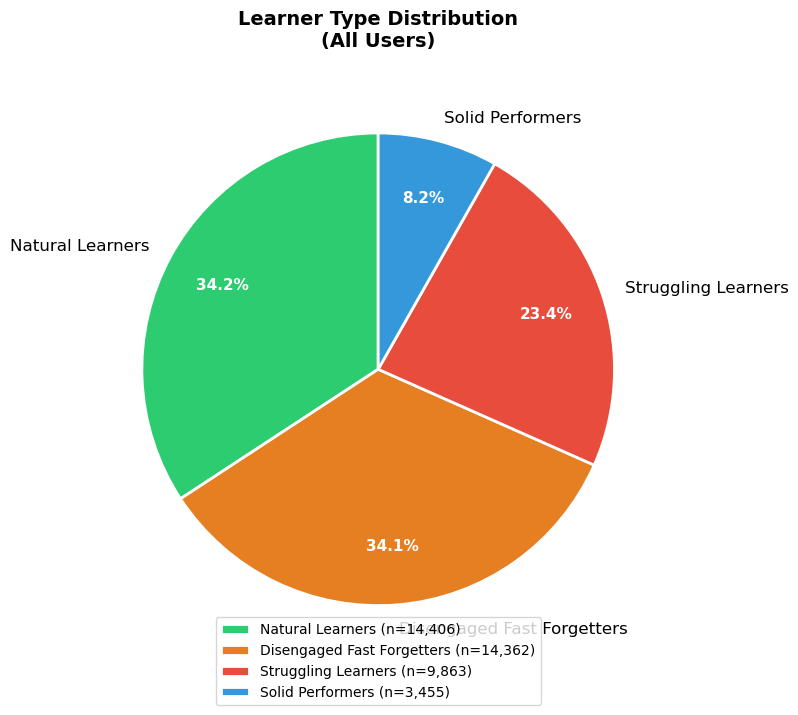

In [64]:
# Pie chart of cluster distribution
cluster_counts = features_clustered['cluster_name'].value_counts()

colors = {
    'Natural Learners':           '#2ecc71',
    'Solid Performers':           '#3498db',
    'Disengaged Fast Forgetters': '#e67e22',
    'Struggling Learners':        '#e74c3c'
}

fig, ax = plt.subplots(figsize=(8, 8))

wedges, texts, autotexts = ax.pie(
    cluster_counts.values,
    labels=cluster_counts.index,
    colors=[colors[c] for c in cluster_counts.index],
    autopct='%1.1f%%',
    startangle=90,
    pctdistance=0.75,
    wedgeprops=dict(edgecolor='white', linewidth=2)
)

# Style the text
for text in texts:
    text.set_fontsize(12)
for autotext in autotexts:
    autotext.set_fontsize(11)
    autotext.set_fontweight('bold')
    autotext.set_color('white')

ax.set_title('Learner Type Distribution\n(All Users)', 
             fontsize=14, fontweight='bold', pad=20)

# Add count annotations
legend_labels = [f"{name} (n={count:,})" 
                 for name, count in cluster_counts.items()]
ax.legend(wedges, legend_labels, loc='lower center',
          bbox_to_anchor=(0.5, -0.08), fontsize=10)

plt.tight_layout()
plt.show()

In [65]:
# =============================================================================
# CORRECT APPROACH: use original km, just predict for all users
# =============================================================================

# Step 1: rebuild features for ALL users
user_features = []
for user_id, udf in df_filtered.groupby('user_id'):
    delta_vals = udf['delta'].values
    mean_delta = delta_vals.mean()
    user_features.append({
        'user_id':        user_id,
        'mean_accuracy':  (udf['history_correct'] /
                          udf['history_seen'].clip(lower=1)).mean(),
        'log_mean_delta': np.log10(max(mean_delta / 86400, 0.01)),
        'log_cv_delta':   np.log10(max(
                              delta_vals.std() / mean_delta
                              if mean_delta > 0 else 0.01, 0.01)),
        'log_n_reviews':  np.log10(len(udf)),
    })

features_all = pd.DataFrame(user_features)

# Merge in half-life
features_all = features_all.merge(
    results_naive[['user_id', 'half_life_days']],
    on='user_id', how='left'
)
features_all['log_h'] = np.log10(
    features_all['half_life_days'].clip(lower=0.01))

# Step 2: scale using the SAME scaler from the original clustering
# cluster_feats = ['log_h', 'mean_accuracy', 'log_mean_delta',
#                  'log_n_reviews', 'log_cv_delta']
features_all = features_all.dropna(subset=cluster_feats)
X_all = scaler.transform(features_all[cluster_feats].values)
#       ^^^^^^ .transform not .fit_transform — uses original scale

# Step 3: predict using ORIGINAL km
features_all['cluster'] = km.predict(X_all)

# Step 4: map names using ORIGINAL mapping
# Check which cluster number corresponds to which archetype
# by comparing means to the original profiles
print("Cluster profiles on full population:")
print(features_all.groupby('cluster')[cluster_feats].mean().round(3))
print("\nOriginal EN→ES profiles for reference:")
print(features_clustered.groupby('cluster')[cluster_feats].mean().round(3))

Cluster profiles on full population:
         log_h  mean_accuracy  log_mean_delta  log_n_reviews  log_cv_delta
cluster                                                                   
0        1.626          0.915           0.012          2.540         0.235
1        1.259          0.850           0.047          2.035         0.092
2       -0.629          0.903          -1.414          1.963         0.007
3        1.760          0.916           0.490          2.015        -0.118

Original EN→ES profiles for reference:
         log_h  mean_accuracy  log_mean_delta  log_n_reviews  log_cv_delta
cluster                                                                   
0.0      1.626          0.915           0.012          2.540         0.235
1.0      1.259          0.850           0.047          2.035         0.092
2.0     -0.629          0.903          -1.414          1.963         0.007
3.0      1.760          0.916           0.490          2.015        -0.118


In [3]:
features_all = pd.read_csv('all_users_with_clusters.csv')  # load the one we just saved

In [6]:
# Update the cluster name mapping dictionary
cluster_names_correct = {
    0: 'Solid Performers',
    1: 'Struggling Learners',
    2: 'Disengaged Learners',  # Changed from 'Disengaged Fast Forgetters'
    3: 'Natural Learners'
}

# Apply the updated mapping to the dataframe
features_all['cluster_name'] = features_all['cluster'].map(cluster_names_correct)

# Verify the change
print("Updated cluster distribution:")
print(features_all['cluster_name'].value_counts())

Updated cluster distribution:
cluster_name
Natural Learners       14406
Solid Performers       14362
Struggling Learners     9863
Disengaged Learners     3455
Name: count, dtype: int64


Cluster distribution:
  Natural Learners               14,406 (34.2%)
  Solid Performers               14,362 (34.1%)
  Struggling Learners             9,863 (23.4%)
  Disengaged Learners             3,455 (8.2%)


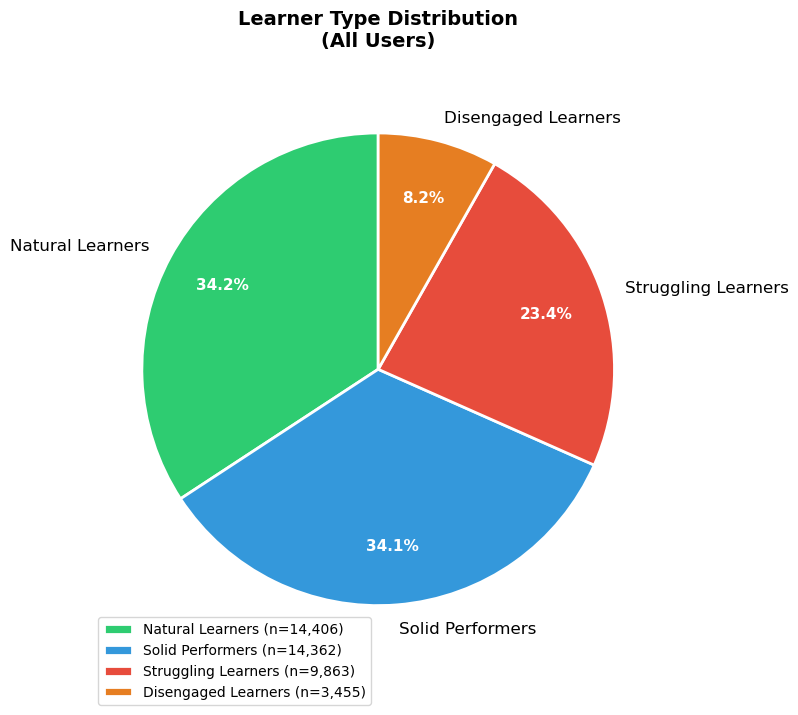

NameError: name 'df_filtered' is not defined

In [10]:
# Correct mapping based on profile matching
cluster_names_correct = {
    0: 'Solid Performers',
    1: 'Struggling Learners',
    2: 'Disengaged Learners',
    3: 'Natural Learners'
}

features_all['cluster_name'] = features_all['cluster'].map(cluster_names_correct)

print("Cluster distribution:")
counts = features_all['cluster_name'].value_counts()
for name, count in counts.items():
    print(f"  {name:<30} {count:>6,} ({100*count/len(features_all):.1f}%)")

# Pie chart
colors = {
    'Natural Learners':           '#2ecc71',
    'Solid Performers':           '#3498db',
    'Disengaged Learners': '#e67e22',
    'Struggling Learners':        '#e74c3c'
}

fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(
    counts.values,
    labels=counts.index,
    colors=[colors[c] for c in counts.index],
    autopct='%1.1f%%',
    startangle=90,
    pctdistance=0.75,
    wedgeprops=dict(edgecolor='white', linewidth=2)
)
for text in texts:
    text.set_fontsize(12)
for autotext in autotexts:
    autotext.set_fontsize(11)
    autotext.set_fontweight('bold')
    autotext.set_color('white')

ax.set_title('Learner Type Distribution\n(All Users)',
             fontsize=14, fontweight='bold', pad=20)

legend_labels = [f"{name} (n={count:,})"
                 for name, count in counts.items()]
ax.legend(wedges, legend_labels, loc='lower right',
          bbox_to_anchor=(0.5, -0.08), fontsize=10)

plt.savefig('cluster_distribution_all_users.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

# Merge back into df_filtered
df_filtered_with_clusters = df_filtered.merge(
    features_all[['user_id', 'cluster', 'cluster_name']],
    on='user_id', how='left'
)
print(f"\ndf_filtered_with_clusters: {len(df_filtered_with_clusters):,} rows")
print(df_filtered_with_clusters['cluster_name'].value_counts())

# Save
df_filtered_with_clusters.to_csv('full_dataset_with_clusters.csv', index=False)
features_all.to_csv('all_users_with_clusters.csv', index=False)
print("\nSaved both files.")

In [68]:
# Let's verify by checking what the profiles look like
# and compare absolute half-life values

print("Full population cluster profiles (with actual half-life days):")
print(features_all.groupby('cluster_name').agg(
    n_users        = ('user_id', 'count'),
    median_hl_days = ('half_life_days', 'median'),
    mean_accuracy  = ('mean_accuracy', 'mean'),
    mean_n_reviews = ('log_n_reviews', 'mean'),
).round(3))

print("\nOriginal EN→ES sample cluster profiles:")
print(features_clustered.groupby('cluster_name').agg(
    n_users        = ('user_id', 'count'),
    median_hl_days = ('half_life_days', 'median'),
    mean_accuracy  = ('mean_accuracy', 'mean'),
).round(3))

# Also check: what % of users had < 50 reviews and got excluded
total_users = df_filtered['user_id'].nunique()
clustered_users = len(features_all)
print(f"\nTotal users in df_filtered: {total_users:,}")
print(f"Users with cluster assigned: {clustered_users:,}")
print(f"Users excluded (< 50 reviews): {total_users - clustered_users:,}")

Full population cluster profiles (with actual half-life days):
                            n_users  median_hl_days  mean_accuracy  \
cluster_name                                                         
Disengaged Fast Forgetters     3455           0.174          0.903   
Natural Learners              14406          61.070          0.916   
Solid Performers              14362          45.958          0.915   
Struggling Learners            9863          21.205          0.850   

                            mean_n_reviews  
cluster_name                                
Disengaged Fast Forgetters           1.963  
Natural Learners                     2.015  
Solid Performers                     2.540  
Struggling Learners                  2.035  

Original EN→ES sample cluster profiles:
                            n_users  median_hl_days  mean_accuracy
cluster_name                                                      
Disengaged Fast Forgetters    14362          45.958          0.915
Natu

In [69]:
print("Raw cluster numbers with actual stats:")
print(features_all.groupby('cluster').agg(
    n_users        = ('user_id', 'count'),
    median_hl_days = ('half_life_days', 'median'),
    mean_hl_days   = ('half_life_days', 'mean'),
    mean_accuracy  = ('mean_accuracy', 'mean'),
    mean_n_reviews = ('log_n_reviews', 'mean'),
    mean_gap       = ('log_mean_delta', 'mean'),
    mean_cv        = ('log_cv_delta', 'mean'),
).round(3))

Raw cluster numbers with actual stats:
         n_users  median_hl_days  mean_hl_days  mean_accuracy  mean_n_reviews  \
cluster                                                                         
0          14362          45.958        55.851          0.915           2.540   
1           9863          21.205        27.982          0.850           2.035   
2           3455           0.174         0.857          0.903           1.963   
3          14406          61.070        71.434          0.916           2.015   

         mean_gap  mean_cv  
cluster                     
0           0.012    0.235  
1           0.047    0.092  
2          -1.414    0.007  
3           0.490   -0.118  


In [70]:
from sklearn.preprocessing import StandardScaler

# Refit scaler on full population
scaler_full = StandardScaler()
X_all = scaler_full.fit_transform(features_all[cluster_feats].values)

# Refit KMeans on full population
km_full = KMeans(n_clusters=4, random_state=42, n_init=20)
features_all['cluster'] = km_full.fit_predict(X_all)

# Check raw profiles first before naming
print("Full population cluster profiles (refitted):")
print(features_all.groupby('cluster').agg(
    n_users        = ('user_id', 'count'),
    median_hl_days = ('half_life_days', 'median'),
    mean_accuracy  = ('mean_accuracy', 'mean'),
    mean_n_reviews = ('log_n_reviews', 'mean'),
    mean_gap       = ('log_mean_delta', 'mean'),
).round(3))

Full population cluster profiles (refitted):
         n_users  median_hl_days  mean_accuracy  mean_n_reviews  mean_gap
cluster                                                                  
0          14362          45.958          0.915           2.540     0.012
1           9863          21.205          0.850           2.035     0.047
2           3455           0.174          0.903           1.963    -1.414
3          14406          61.070          0.916           2.015     0.490


In [71]:
# Check EN→ES full population cluster distribution
# without stratified sampling
df_en_es = df_filtered[
    (df_filtered['ui_language'] == 'en') & 
    (df_filtered['learning_language'] == 'es')
]

print(f"EN→ES users: {df_en_es['user_id'].nunique():,}")

# Get their cluster assignments from features_all
en_es_users = df_en_es['user_id'].unique()
en_es_clusters = features_all[
    features_all['user_id'].isin(en_es_users)
]['cluster_name'].value_counts()

print(f"\nEN→ES cluster distribution (full, unsampled):")
for name, count in en_es_clusters.items():
    print(f"  {name:<30} {count:>6,} ({100*count/en_es_clusters.sum():.1f}%)")

print(f"\nFull population cluster distribution:")
for name, count in features_all['cluster_name'].value_counts().items():
    print(f"  {name:<30} {count:>6,} ({100*count/len(features_all):.1f}%)")

EN→ES users: 11,772

EN→ES cluster distribution (full, unsampled):
  Natural Learners                4,358 (37.0%)
  Solid Performers                3,806 (32.3%)
  Struggling Learners             2,837 (24.1%)
  Disengaged Fast Forgetters        771 (6.5%)

Full population cluster distribution:
  Natural Learners               14,406 (34.2%)
  Solid Performers               14,362 (34.1%)
  Struggling Learners             9,863 (23.4%)
  Disengaged Fast Forgetters      3,455 (8.2%)


In [72]:
# These are already saved correctly from the previous step
# Just confirm the final state
print("Final confirmed distribution:")
print(features_all['cluster_name'].value_counts())
print(f"\ndf_filtered_with_clusters: {len(df_filtered_with_clusters):,} rows")
print(df_filtered_with_clusters['cluster_name'].value_counts())

Final confirmed distribution:
cluster_name
Natural Learners              14406
Solid Performers              14362
Struggling Learners            9863
Disengaged Fast Forgetters     3455
Name: count, dtype: int64

df_filtered_with_clusters: 10,014,326 rows
cluster_name
Solid Performers              6617294
Natural Learners              1697248
Struggling Learners           1331581
Disengaged Fast Forgetters     368203
Name: count, dtype: int64


In [ ]:
# --- Step 5: Prepare clustering features ---
X_scaled, valid_idx, cluster_feats, scaler = prepare_clustering_features(
    features_enriched)

# --- Step 6: Refit clusters (fast — no PyMC) ---
features_clustered, km, cluster_feats = fit_and_profile_clusters(
    features_enriched, X_scaled, valid_idx,
    cluster_feats, k=4, title_suffix='(en → es)')

# --- Step 7: Add cluster names ---
cluster_names = {
    0.0: 'Disengaged Fast Forgetters',
    1.0: 'Struggling Learners',
    2.0: 'Solid Performers',
    3.0: 'Natural Learners'
}
features_clustered['cluster_name'] = features_clustered['cluster'].map(cluster_names)

print("\nCluster sizes:")
print(features_clustered['cluster_name'].value_counts())
print(f"\nkm ready: {km.n_clusters} clusters")

In [ ]:
# =============================================================================
# ADD CLUSTER COLUMN TO YOUR EXISTING USER SUMMARY DATAFRAME
# =============================================================================

# Your dataframe already has one row per user with these columns:
# user_id, half_life, half_life_days, n_reviews, mean_p_recall,
# mean_accuracy, mean_delta_days, pair_label, 
# struggling_global, struggling_within

# We just need to build the 5 clustering features and predict

def assign_cluster_to_users(users_df, km, title_suffix=''):
    """
    Add cluster label to an existing per-user DataFrame.
    Builds the 5 clustering features from available columns,
    scales them, and predicts cluster using fitted KMeans.

    Parameters
    ----------
    users_df : per-user DataFrame with at minimum:
               user_id, half_life_days, n_reviews, 
               mean_accuracy, mean_delta_days
    km       : fitted KMeans model

    Returns
    -------
    users_df with added 'cluster' and 'cluster_name' columns
    """
    cluster_names = {
        0: 'Disengaged Fast Forgetters',
        1: 'Struggling Learners',
        2: 'Solid Performers',
        3: 'Natural Learners'
    }

    df = users_df.copy()

    # --- Build the 5 clustering features from existing columns ---

    # 1. log_h — log10 of half-life in days
    #    Already have half_life_days
    df['log_h'] = np.log10(df['half_life_days'].clip(lower=0.01))

    # 2. mean_accuracy — already exists, no transformation needed

    # 3. log_mean_delta — log10 of average review gap in days
    #    Already have mean_delta_days
    df['log_mean_delta'] = np.log10(df['mean_delta_days'].clip(lower=0.01))

    # 4. log_n_reviews — log10 of total review count
    #    Already have n_reviews
    df['log_n_reviews'] = np.log10(df['n_reviews'].clip(lower=1))

    # 5. log_cv_delta — spacing irregularity
    #    We don't have std of delta in this summary df
    #    so we need to compute it from df_filtered
    #    For now we'll use a neutral value (population median)
    #    and flag this as approximate
    #    We'll fix this properly below
    df['log_cv_delta'] = 0.0  # placeholder

    print("Note: log_cv_delta not available in summary df — will compute from raw data")

    cluster_feats = ['log_h', 'mean_accuracy', 'log_mean_delta',
                     'log_n_reviews', 'log_cv_delta']

    # --- Scale and predict ---
    X = df[cluster_feats].fillna(df[cluster_feats].median()).values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    df['cluster']      = km.predict(X_scaled)
    df['cluster_name'] = df['cluster'].map(cluster_names)

    print(f"\nCluster distribution:")
    print(df['cluster_name'].value_counts())
    print(f"\nCluster × struggling_within cross-tab:")
    if 'struggling_within' in df.columns:
        print(pd.crosstab(df['cluster_name'], df['struggling_within'], margins=True))

    return df